In [1]:
import modeller
import fitter

from functions.misc import knot_fn

import casadi as ca
import numpy as np
from matplotlib import pyplot as plt
from copy import copy

In [2]:
%matplotlib inline

In [3]:
raw_data = [1,1,1,1,1,1,3,5,7,9,12,24,36,40,61,76,100,124,161,185,241,329,432,540,636,736,806,864,914,981,1021,1052,1068,1100,1116,1126,1137,1142,1147]
raw_time = [11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50]

start = 0
clip = None

data = raw_data[start:clip]
time = raw_time[start:clip]

def system_2(t, y, p):
    return [
        -p[1]*y[0]*y[2]/sum(y[:4]),
        p[1]*y[0]*y[2]/sum(y[:4]) - p[2]*y[1],
        p[2]*y[1] - p[0]*y[2],
        p[0]*y[2],
        p[2]*y[1]
    ]

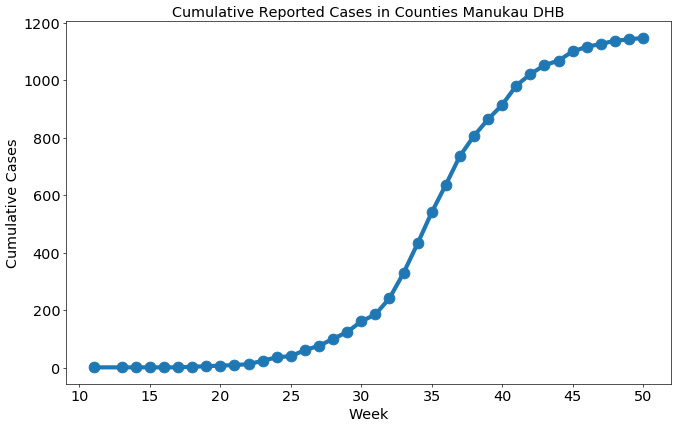

In [4]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(time, data, 'o-', markersize=13, linewidth=5)
ax.set_title("Cumulative Reported Cases in Counties Manukau DHB", size='xx-large')
ax.set_xlabel("Week", size='xx-large')
ax.set_ylabel("Cumulative Cases", size='xx-large')
ax.tick_params(labelsize='xx-large')

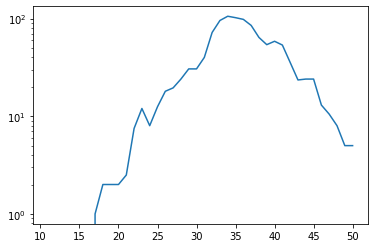

In [5]:
incidence = np.gradient(raw_data[start:clip], time)
plt.semilogy(time, incidence)


In [6]:
# data_pd = np.array(list(zip(*data)))
data_pd = np.array([[i] for i in data])
p0 = [7./8, 15, 7./8]
model_form = {"state": 5, "parameters": 3}
config = {
    "grid_size": 100,
    "basis_number": 24,
    "model_form": model_form,
    "time_span": [time[0], time[-1]*1.1],
    "knot_function": None,
    "model": system_2,
    "dataset": {"y": data_pd, "t": np.array(time)},
    "observation_vector": [-1],
    "weightings":[
        [1]*model_form['state'],
        np.sqrt(time/np.mean(time))
    ],
    "regularisation_value": copy(p0),
}

In [7]:
model = modeller.Model(config)
config['regularisation_value'][1] = model.ps[1]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}

ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 20,
        
    }
}

solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [8]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])

In [9]:
getx = ca.Function('getx', [solver_setup['x']], model.xs)

In [10]:
c0 = [np.ones(config['basis_number']) for _ in range(model_form['state'])]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*model_form['state']) + [0]*len(config['regularisation_value'])
alpha = 1e-2

In [11]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     2045

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

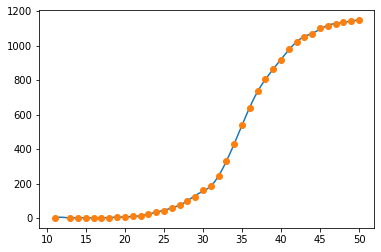

In [12]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(time, data, 'o')

In [13]:
np.hstack(pure_xs).shape

(100, 5)

In [14]:
prange = np.logspace(-6, 0, num=50)
solutions = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
    }
    solutions.append(solver(**solve_opts))
    xguess = np.array(solutions[-1]['x']).flatten()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     2045

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:      500
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

 100  9.3068419e+00 0.00e+00 8.88e-02  -8.6 5.55e+02 -12.9 1.00e+00 1.00e+00h  1
 120  9.3067486e+00 0.00e+00 1.97e-01  -8.6 1.75e+03 -13.4 1.00e+00 6.77e-01f  1
 140  9.3066352e+00 0.00e+00 7.29e-03  -8.6 1.99e+02 -12.1 1.00e+00 1.00e+00h  1
 160  9.3065961e+00 0.00e+00 1.56e-01  -8.6 7.02e+02 -13.5 1.00e+00 1.00e+00h  1
 180  9.3065525e+00 0.00e+00 8.28e-02  -8.6 2.11e+04 -13.1 5.79e-02 4.03e-02h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  9.3064749e+00 0.00e+00 1.15e-01  -8.6 6.00e+02 -12.7 1.00e+00 1.00e+00h  1
 220  9.3063833e+00 0.00e+00 3.20e-02  -8.6 3.16e+02 -12.8 1.00e+00 1.00e+00h  1
 240  9.3063243e+00 0.00e+00 1.13e-01  -8.6 1.40e+03 -13.3 1.00e+00 1.00e+00h  1
 260  9.3062916e+00 0.00e+00 4.12e-03  -8.6 4.54e+02 -12.4 1.00e+00 1.00e+00h  1
 280  9.3062657e+00 0.00e+00 3.03e-02  -8.6 3.37e+02 -12.5 1.00e+00 1.00e+00h  1
 300  9.3062201e+00 0.00e+00 1.37e-03  -8.6 2.12e+02 -12.1 1.00e+00 1.00e+00h  1
 320  9.3061744e+00 0.00e+00

  60  9.3017064e+00 0.00e+00 5.10e-04  -8.6 1.49e+04    -  3.10e-05 4.99e-02f  1
  80  9.3014560e+00 0.00e+00 1.49e-05  -9.0 3.21e+03    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 93

                                   (scaled)                 (unscaled)
Objective...............:   9.3014557258193484e+00    9.3014557258193484e+00
Dual infeasibility......:   2.5655300234702742e-10    2.5655300234702742e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909325651789983e-10    9.0909325651789983e-10
Overall NLP error.......:   9.0909325651789983e-10    9.0909325651789983e-10


Number of objective function evaluations             = 120
Number of objective gradient evaluations             = 94
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 120
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 94
N

 100  9.3074372e+00 0.00e+00 3.22e-04  -8.6 1.51e+00  -7.9 1.00e+00 1.00e+00f  1
 120  9.3072893e+00 0.00e+00 2.30e-02  -8.6 4.20e+03 -14.7 4.66e-01 5.00e-01h  2
 140  9.3029845e+00 0.00e+00 1.67e-04  -8.6 3.59e+00  -7.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 149

                                   (scaled)                 (unscaled)
Objective...............:   9.3021994436852395e+00    9.3021994436852395e+00
Dual infeasibility......:   4.6592069043011236e-10    4.6592069043011236e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   2.5059035596800622e-09    2.5059035596800622e-09


Number of objective function evaluations             = 236
Number of objective gradient evaluations             = 150
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 236
Number of equality constraint Jac

  20  9.3244527e+00 0.00e+00 7.51e-05  -5.7 1.29e+00  -5.4 9.86e-01 1.00e+00f  1
  40  9.3234538e+00 0.00e+00 1.95e-02  -8.6 2.65e+02 -11.4 1.00e+00 1.00e+00h  1
  60  9.3220318e+00 0.00e+00 2.29e-01  -8.6 2.04e+04 -11.0 3.94e-02 8.13e-03f  3
  80  9.3145797e+00 0.00e+00 2.01e-02  -8.6 1.95e+02 -12.4 1.00e+00 1.00e+00f  1
 100  9.3054617e+00 0.00e+00 3.71e-03  -8.6 1.63e+02 -10.2 1.00e+00 6.16e-01f  1
 120  9.3023423e+00 0.00e+00 2.36e-03  -8.6 1.79e+01  -8.9 1.00e+00 1.00e+00f  1

Number of Iterations....: 138

                                   (scaled)                 (unscaled)
Objective...............:   9.3020267630142417e+00    9.3020267630142417e+00
Dual infeasibility......:   9.4018086106292070e-09    9.4018086106292070e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059051601945724e-09    2.5059051601945724e-09
Overall NLP error.......:   9.4018086106292070e-09    9.4018086106292070e-09


Number of objective func

  40  9.3445957e+00 0.00e+00 3.23e-01  -8.6 3.86e+02  -8.3 4.66e-01 9.36e-02f  3
  60  9.3344028e+00 0.00e+00 1.67e-01  -8.6 3.42e+02  -9.7 1.00e+00 5.00e-01f  2
  80  9.3140514e+00 0.00e+00 4.03e-04  -8.6 4.30e+00  -6.6 1.00e+00 9.74e-01f  1
 100  9.3043129e+00 0.00e+00 7.51e-05  -8.6 2.04e+00  -8.0 1.00e+00 1.00e+00h  1

Number of Iterations....: 118

                                   (scaled)                 (unscaled)
Objective...............:   9.3033640537670603e+00    9.3033640537670603e+00
Dual infeasibility......:   9.1968244840929560e-09    9.1968244840929560e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5060004315011991e-09    2.5060004315011991e-09
Overall NLP error.......:   9.1968244840929560e-09    9.1968244840929560e-09


Number of objective function evaluations             = 174
Number of objective gradient evaluations             = 119
Number of equality constraint evaluations            = 0
Number of i

 120  9.4361780e+00 0.00e+00 1.66e-02  -3.8 1.31e+01  -9.3 1.00e+00 1.00e+00f  1
 140  9.4363731e+00 0.00e+00 5.47e+00  -3.8 8.34e+02 -11.5 1.00e+00 5.00e-01f  2
 160  9.4357754e+00 0.00e+00 4.50e+00  -5.7 1.43e+03 -12.4 1.00e+00 2.50e-01h  3
 180  9.4355293e+00 0.00e+00 8.78e-01  -5.7 1.05e+03 -12.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  9.4355273e+00 0.00e+00 4.59e-03  -5.7 1.21e+01 -11.9 1.00e+00 1.00e+00h  1
 220  9.4355316e+00 0.00e+00 6.55e-03  -5.7 2.67e+01 -12.9 1.00e+00 1.00e+00h  1
 240  9.4355341e+00 0.00e+00 2.00e-02  -5.7 7.91e+01 -13.4 1.00e+00 1.00e+00h  1
 260  9.4355378e+00 0.00e+00 1.53e-01  -5.7 5.86e+01 -13.0 1.00e+00 1.00e+00h  1
 280  9.4355407e+00 0.00e+00 1.63e-01  -5.7 7.44e+01 -13.5 1.00e+00 1.00e+00h  1
 300  9.4355445e+00 0.00e+00 7.34e-02  -5.7 4.90e+01 -13.1 1.00e+00 1.00e+00h  1
 320  9.4355472e+00 0.00e+00 1.72e-01  -5.7 6.55e+01 -12.6 1.00e+00 1.00e+00h  1
 340  9.4355497e+00 0.00e+00

  60  9.3726392e+00 0.00e+00 3.80e-05  -5.7 1.84e+00  -6.0 1.00e+00 1.00e+00f  1
  80  9.3206176e+00 0.00e+00 1.28e-02  -5.7 1.10e+01  -6.5 1.00e+00 1.00e+00f  1
 100  9.3084370e+00 0.00e+00 2.55e-02  -5.7 2.32e+02 -11.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 113

                                   (scaled)                 (unscaled)
Objective...............:   9.3071674550120722e+00    9.3071674550120722e+00
Dual infeasibility......:   8.3601141803869398e-10    8.3601141803869398e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059319475492546e-09    2.5059319475492546e-09
Overall NLP error.......:   2.5059319475492546e-09    2.5059319475492546e-09


Number of objective function evaluations             = 161
Number of objective gradient evaluations             = 114
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 161
Number of equality constraint Jac

 560  9.6081357e+00 0.00e+00 7.06e-02  -5.7 5.02e+01 -12.5 1.00e+00 1.00e+00h  1
 580  9.6081277e+00 0.00e+00 7.07e-03  -5.7 1.83e+01 -12.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  9.6081202e+00 0.00e+00 9.98e-02  -5.7 3.82e+02 -13.5 1.00e+00 1.00e+00h  1
 620  9.6081127e+00 0.00e+00 3.08e-03  -5.7 1.58e+02 -13.1 1.00e+00 1.00e+00h  1
 640  9.6081054e+00 0.00e+00 1.91e-03  -5.7 6.44e+01 -12.7 1.00e+00 1.00e+00h  1
 660  9.6080969e+00 0.00e+00 2.26e-02  -5.7 2.13e+02 -13.2 1.00e+00 1.00e+00h  1
 680  9.6080850e+00 0.00e+00 1.30e-02  -5.7 8.44e+01 -12.8 1.00e+00 1.00e+00h  1
 700  9.6080764e+00 0.00e+00 2.34e-02  -5.7 4.24e+01 -12.4 1.00e+00 1.00e+00h  1
 720  9.6080642e+00 0.00e+00 1.65e-02  -5.7 1.22e+02 -13.0 1.00e+00 1.00e+00h  1
 740  9.6080490e+00 0.00e+00 1.26e-01  -5.7 7.15e+01 -12.6 1.00e+00 1.00e+00h  1
 760  9.6080269e+00 0.00e+00 3.72e-01  -5.7 8.90e+01 -12.2 1.00e+00 1.00e+00h  1
 780  9.6080109e+00 0.00e+00

  80  9.5810716e+00 0.00e+00 1.73e-03  -5.7 4.48e+00  -6.1 1.00e+00 1.00e+00f  1
 100  9.3947301e+00 0.00e+00 6.24e-02  -5.7 2.90e+01  -6.6 1.00e+00 3.06e-01f  1
 120  9.3381041e+00 0.00e+00 1.12e-03  -5.7 3.00e+00  -6.2 1.00e+00 1.00e+00f  1

Number of Iterations....: 131

                                   (scaled)                 (unscaled)
Objective...............:   9.3344632651712232e+00    9.3344632651712232e+00
Dual infeasibility......:   3.7523930316931214e-09    3.7523930316931214e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   3.9715780521824129e-09    3.9715780521824129e-09
Overall NLP error.......:   3.9715780521824129e-09    3.9715780521824129e-09


Number of objective function evaluations             = 164
Number of objective gradient evaluations             = 132
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 164
Number of equality constraint Jac

Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:      500
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.3500600e+00 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  20  1.1361371e+01 0.00e+00 4.36e+01  -1.0 3.60e+02  -6.9 1.00e+00 1.00e+00f  1
  40  1.1249259e+01 0.00e+00 5.48e+02  -1.0 2.87e+03  -9.5 1.00e+00 1.00e+00f  1
  60  1.0511886e+01 0.00e+00 5.66e+00  -1.7 6.38e+02 -10.7 1.00e+00 1.00e+00f  1
  80  1.0360500e+01 0.00e+00 1.73e-01  -3.8 2.38e+02  -9.6 1.00e+00 1.00e+00f  1
 100  1.0288756e+01 0.00e+00 1.15e+02  -3.8 3.28e+03 -11.0 1.00e+00 5.00e-01f  2
 120  1.0254646e+01 0.00e+00 4.13e+01  -3.8 1.10e+04 -12.4 1.00e+00 2.50e-01f  3
 140  1.0249893e+01 0.00e+00 3.17e+00  -3.8 1.80e+02 -11.1 1.00e+00 1.00e+00f  1
 160  1.024797

  40  1.1523620e+01 0.00e+00 5.83e+02  -1.0 1.66e+05    -  3.33e-01 4.53e-02f  3
  60  1.1470025e+01 0.00e+00 4.68e+00  -1.0 2.13e+02  -8.5 1.00e+00 1.00e+00f  1
  80  1.1568539e+01 0.00e+00 1.38e+02  -1.0 3.02e+03    -  1.00e+00 1.00e+00f  1
 100  1.0713614e+01 0.00e+00 5.31e+01  -2.5 1.39e+03 -10.5 1.00e+00 1.00e+00f  1
 120  1.0616010e+01 0.00e+00 5.55e+01  -2.5 3.81e+03 -10.9 1.00e+00 5.00e-01f  2
 140  1.0586105e+01 0.00e+00 8.50e+01  -2.5 9.35e+03    -  1.00e+00 1.25e-01f  4
 160  1.0579307e+01 0.00e+00 1.67e+01  -2.5 6.95e+02 -12.1 1.00e+00 5.00e-01h  2
 180  1.0557047e+01 0.00e+00 8.97e+00  -3.8 2.99e+02 -11.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0555229e+01 0.00e+00 3.37e+01  -3.8 8.38e+02 -12.1 1.00e+00 5.00e-01f  2
 220  1.0553763e+01 0.00e+00 9.00e+00  -3.8 2.33e+02 -11.8 1.00e+00 1.00e+00f  1
 240  1.0551874e+01 0.00e+00 7.79e+01  -3.8 1.67e+03 -12.3 1.00e+00 5.00e-01f  2
 260  1.0549654e+01 0.00e+00

  80  1.1172938e+01 0.00e+00 3.84e+02  -2.5 4.16e+05    -  1.47e-01 1.62e-02f  4
 100  1.1033871e+01 0.00e+00 4.30e+01  -2.5 1.52e+03 -10.5 1.00e+00 1.00e+00f  1
 120  1.0996082e+01 0.00e+00 6.95e-01  -2.5 7.97e+01 -10.1 1.00e+00 1.00e+00f  1
 140  1.0984831e+01 0.00e+00 6.74e+01  -2.5 4.91e+03    -  1.00e+00 2.50e-01f  3
 160  1.0964185e+01 0.00e+00 4.41e+01  -3.8 6.48e+02 -11.6 1.00e+00 1.00e+00f  1
 180  1.0961508e+01 0.00e+00 5.88e+01  -3.8 8.96e+02 -12.1 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0959394e+01 0.00e+00 2.40e+01  -3.8 3.18e+02 -11.7 1.00e+00 1.00e+00f  1
 220  1.0956668e+01 0.00e+00 3.80e+01  -3.8 4.87e+02 -11.3 1.00e+00 1.00e+00f  1
 240  1.0953445e+01 0.00e+00 9.31e+01  -3.8 1.68e+03 -11.8 1.00e+00 5.00e-01f  2
 260  1.0949285e+01 0.00e+00 2.60e+01  -3.8 4.21e+02 -11.4 1.00e+00 1.00e+00f  1
 280  1.0946302e+01 0.00e+00 2.09e+01  -3.8 3.30e+02 -12.4 1.00e+00 1.00e+00h  1
 300  1.0945429e+01 0.00e+00

  80  1.2662602e+01 0.00e+00 3.78e+02  -1.0 4.16e+03    -  1.00e+00 5.00e-01f  2
 100  1.1706327e+01 0.00e+00 7.14e+01  -2.5 2.10e+03 -10.3 1.00e+00 1.00e+00f  1
 120  1.1567535e+01 0.00e+00 1.01e+02  -2.5 1.85e+03 -10.7 1.00e+00 1.00e+00f  1
 140  1.1525036e+01 0.00e+00 6.56e+01  -2.5 1.59e+03 -11.6 1.00e+00 5.00e-01f  2
 160  1.1518901e+01 0.00e+00 1.33e+01  -2.5 8.57e+02 -11.9 1.00e+00 5.00e-01h  2
 180  1.1502886e+01 0.00e+00 3.74e+01  -3.8 8.03e+02 -11.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.1499808e+01 0.00e+00 1.02e+02  -3.8 1.09e+03 -11.9 1.00e+00 5.00e-01f  2
 220  1.1496826e+01 0.00e+00 2.92e+01  -3.8 3.78e+03 -11.5 1.00e+00 1.25e-01f  4
 240  1.1493575e+01 0.00e+00 1.25e+02  -3.8 1.05e+03 -12.0 1.00e+00 1.00e+00f  1
 260  1.1489361e+01 0.00e+00 8.39e+01  -3.8 9.66e+02 -11.6 1.00e+00 5.00e-01f  2
 280  1.1484454e+01 0.00e+00 7.68e+01  -3.8 1.29e+03 -11.2 1.00e+00 5.00e-01f  2
 300  1.1479849e+01 0.00e+00

 180  1.2210892e+01 0.00e+00 6.09e+01  -3.8 3.39e+02 -11.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.2206652e+01 0.00e+00 8.43e+01  -3.8 9.80e+03 -11.9 1.00e+00 1.25e-01f  4
 220  1.2201445e+01 0.00e+00 3.81e+01  -3.8 5.46e+02 -11.5 1.00e+00 1.00e+00f  1
 240  1.2195205e+01 0.00e+00 6.07e+01  -3.8 5.24e+02 -11.1 1.00e+00 1.00e+00f  1
 260  1.2187116e+01 0.00e+00 2.20e+01  -3.8 6.70e+02 -11.7 1.00e+00 1.00e+00f  1
 280  1.2185138e+01 0.00e+00 1.05e+01  -3.8 2.13e+02 -12.6 1.00e+00 1.00e+00h  1
 300  1.2184875e+01 0.00e+00 9.94e+00  -3.8 6.77e+03    -  1.00e+00 3.12e-02h  6
 320  1.2184846e+01 0.00e+00 3.58e-03  -3.8 2.57e+00 -11.4 1.00e+00 1.00e+00h  1
 340  1.2184244e+01 0.00e+00 1.51e+01  -5.7 7.68e+02 -12.7 1.00e+00 5.00e-01h  2
 360  1.2184163e+01 0.00e+00 5.74e-02  -5.7 3.86e+01 -11.4 1.00e+00 1.00e+00h  1
 380  1.2184058e+01 0.00e+00 2.27e-03  -5.7 4.60e+00 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 220  1.3150095e+01 0.00e+00 3.41e+01  -3.8 3.53e+02 -11.2 1.00e+00 1.00e+00f  1
 240  1.3142524e+01 0.00e+00 9.50e+01  -3.8 1.56e+03 -11.7 1.00e+00 2.50e-01f  3
 260  1.3133079e+01 0.00e+00 4.11e+01  -3.8 3.41e+02 -10.4 1.00e+00 1.00e+00f  1
 280  1.3124326e+01 0.00e+00 8.80e+01  -3.8 6.05e+02 -11.8 1.00e+00 5.00e-01f  2
 300  1.3121672e+01 0.00e+00 1.02e+02  -3.8 8.70e+02 -12.4 1.00e+00 5.00e-01h  2
 320  1.3121241e+01 0.00e+00 4.61e-01  -3.8 4.22e+01 -11.4 1.00e+00 1.00e+00h  1
 340  1.3121126e+01 0.00e+00 3.03e+01  -3.8 1.41e+04    -  1.00e+00 1.25e-01h  4
 360  1.3120980e+01 0.00e+00 2.80e+00  -3.8 8.50e+02    -  1.00e+00 1.25e-01h  4
 380  1.3120362e+01 0.00e+00 6.25e+00  -5.7 1.22e+02 -11.6 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.3120249e+01 0.00e+00 1.12e-01  -5.7 3.53e+01 -11.2 1.00e+00 1.00e+00h  1
 420  1.3120140e+01 0.00e+00 1.35e-01  -5.7 1.11e+02 -11.7 1.00e+00 1.00e+00h  1
 440  1.3120030e+01 0.00e+00

  40  1.7201380e+01 0.00e+00 3.87e+01  -1.0 8.47e+01  -6.8 1.00e+00 1.00e+00f  1
  60  1.7280052e+01 0.00e+00 3.20e+02  -1.0 7.36e+02  -8.1 1.00e+00 1.00e+00f  1
  80  1.7670514e+01 0.00e+00 4.88e+03  -1.0 6.29e+04    -  4.77e-01 6.25e-02f  5
 100  1.7566751e+01 0.00e+00 1.81e+03  -1.0 1.38e+04    -  1.00e+00 1.25e-01f  4
 120  1.7484001e+01 0.00e+00 6.15e+02  -1.7 2.17e+04    -  8.47e-01 1.25e-01f  4
 140  1.6472982e+01 0.00e+00 2.05e+02  -1.7 1.68e+03 -10.1 1.00e+00 1.00e+00f  1
 160  1.6333288e+01 0.00e+00 9.27e+01  -1.7 3.48e+03    -  1.00e+00 2.50e-01f  3
 180  1.6180666e+01 0.00e+00 2.31e+02  -2.5 1.85e+03  -9.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.6094159e+01 0.00e+00 2.56e+02  -2.5 9.24e+02 -11.2 1.00e+00 1.00e+00f  1
 220  1.6086916e+01 0.00e+00 3.91e+00  -2.5 6.81e+01 -10.3 1.00e+00 1.00e+00f  1
 240  1.6080856e+01 0.00e+00 1.64e+02  -2.5 8.74e+02 -12.0 1.00e+00 5.00e-01f  2
 260  1.6074109e+01 0.00e+00


Number of Iterations....: 86

                                   (scaled)                 (unscaled)
Objective...............:   9.5140569258259546e+00    9.5140569258259546e+00
Dual infeasibility......:   9.8467948249190802e-09    9.8467948249190802e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   9.8467948249190802e-09    9.8467948249190802e-09


Number of objective function evaluations             = 130
Number of objective gradient evaluations             = 87
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 130
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 87
Number of Lagrangian Hessian evaluations             = 86
Total CPU secs in IPOPT (w/o function evaluations)   =      0.180
Total CPU secs in NLP function evaluati

 780  2.4834858e+01 0.00e+00 6.26e+00  -5.7 2.08e+02 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  2.4820850e+01 0.00e+00 1.11e+00  -5.7 3.10e+01  -8.9 1.00e+00 1.00e+00f  1
 820  2.4803135e+01 0.00e+00 1.55e+00  -5.7 9.86e+01  -9.4 1.00e+00 1.00e+00f  1
 840  2.4765690e+01 0.00e+00 1.89e+02  -5.7 6.66e+02  -9.9 1.00e+00 1.00e+00f  1
 860  2.4692471e+01 0.00e+00 4.12e+02  -5.7 6.61e+02  -9.5 1.00e+00 1.00e+00f  1
 880  2.4458648e+01 0.00e+00 7.21e+01  -5.7 1.92e+02  -8.2 1.00e+00 1.00e+00f  1
 900  2.3232429e+01 0.00e+00 2.64e+03  -5.7 1.28e+03  -8.7 8.87e-01 2.50e-01f  3
 920  1.9961561e+01 0.00e+00 2.37e+02  -5.7 5.00e+02  -9.2 1.00e+00 1.00e+00f  1
 940  1.9783102e+01 0.00e+00 4.32e-04  -5.7 1.07e+00  -7.0 1.00e+00 1.00e+00h  1
 960  1.9745479e+01 0.00e+00 5.09e+01  -5.7 9.90e+02 -10.2 1.00e+00 1.00e+00f  1
 980  1.9720832e+01 0.00e+00 6.85e-04  -5.7 4.31e+00  -8.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

  20  2.6213267e+01 0.00e+00 5.44e+01  -1.0 3.94e+04    -  1.00e+00 5.00e-01f  2
  40  3.8334277e+01 0.00e+00 9.07e+01  -1.0 2.93e+02  -6.8 1.00e+00 1.00e+00f  1
  60  3.8175797e+01 0.00e+00 1.84e+02  -1.0 2.93e+02  -7.6 1.00e+00 1.00e+00f  1
  80  3.8309530e+01 0.00e+00 5.06e+01  -1.0 1.40e+02  -7.5 1.00e+00 1.00e+00f  1
 100  3.8547822e+01 0.00e+00 3.47e+03  -1.0 2.13e+03  -8.8 1.00e+00 1.00e+00f  1
 120  3.8620070e+01 0.00e+00 6.11e+03  -1.0 3.97e+04    -  1.00e+00 1.25e-01f  4
 140  3.8455252e+01 0.00e+00 5.23e+03  -1.0 3.30e+04    -  1.00e+00 6.25e-02f  5
 160  3.8440757e+01 0.00e+00 5.82e+03  -1.0 1.31e+03  -9.7 1.00e+00 1.00e+00f  1
 180  3.8401457e+01 0.00e+00 1.88e+03  -1.0 1.19e+03 -10.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.8398078e+01 0.00e+00 1.55e+01  -1.0 8.52e+01 -10.0 1.00e+00 1.00e+00f  1
 220  3.6990759e+01 0.00e+00 5.54e+02  -2.5 2.98e+02  -8.9 1.00e+00 6.58e-01f  1
 240  3.6906235e+01 0.00e+00

  40  4.9107291e+01 0.00e+00 1.23e+03  -1.0 3.38e+02  -6.5 1.00e+00 1.00e+00f  1
  60  4.7137141e+01 0.00e+00 6.05e+01  -1.0 4.57e+01  -6.5 1.00e+00 1.00e+00f  1
  80  4.8782248e+01 0.00e+00 8.50e+03  -1.0 1.17e+03  -8.3 1.00e+00 1.00e+00f  1
 100  4.7578063e+01 0.00e+00 5.31e+03  -1.0 8.97e+03  -9.1 1.00e+00 2.50e-01f  3
 120  4.7710409e+01 0.00e+00 1.10e+04  -1.0 1.14e+05    -  5.72e-01 2.48e-02f  6
 140  4.7521163e+01 0.00e+00 5.63e+02  -1.0 1.05e+03  -9.1 1.00e+00 1.00e+00f  1
 160  4.7418800e+01 0.00e+00 3.26e+02  -1.0 6.34e+02  -9.2 1.00e+00 1.00e+00f  1
 180  4.7322254e+01 0.00e+00 1.53e+03  -1.0 1.40e+03  -9.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.7244855e+01 0.00e+00 5.13e+02  -1.0 1.82e+04    -  1.00e+00 3.12e-02f  6
 220  4.6016804e+01 0.00e+00 7.34e+02  -1.7 8.67e+02 -10.7 1.00e+00 1.00e+00f  1
 240  4.5942847e+01 0.00e+00 2.57e+02  -1.7 2.46e+02 -10.3 1.00e+00 1.00e+00f  1
 260  4.5916329e+01 0.00e+00

  20  1.0294256e+01 0.00e+00 5.49e-02  -3.8 8.45e-01  -3.1 1.00e+00 1.00e+00f  1
  40  1.0046320e+01 0.00e+00 4.45e-07  -5.7 1.34e-01  -7.2 1.00e+00 1.00e+00h  1
  60  1.0034963e+01 0.00e+00 1.04e-06  -8.6 1.56e-02  -5.7 1.00e+00 1.00e+00h  1

Number of Iterations....: 62

                                   (scaled)                 (unscaled)
Objective...............:   1.0034963071769671e+01    1.0034963071769671e+01
Dual infeasibility......:   7.0049535810110373e-09    7.0049535810110373e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0230032405708483e-09    1.0230032405708483e-09
Overall NLP error.......:   7.0049535810110373e-09    7.0049535810110373e-09


Number of objective function evaluations             = 91
Number of objective gradient evaluations             = 63
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 91
Number of equality constraint Jacobia

  40  1.0940531e+01 0.00e+00 4.72e-01  -3.8 8.29e-01  -3.2 1.00e+00 1.00e+00f  1
  60  1.0667073e+01 0.00e+00 3.09e-05  -8.6 5.58e+01 -10.0 1.00e+00 1.00e+00f  1

Number of Iterations....: 69

                                   (scaled)                 (unscaled)
Objective...............:   1.0663376702962434e+01    1.0663376702962434e+01
Dual infeasibility......:   8.9842753028169665e-09    8.9842753028169665e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   8.9842753028169665e-09    8.9842753028169665e-09


Number of objective function evaluations             = 82
Number of objective gradient evaluations             = 70
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 82
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 70
Num

Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:      500
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.2252840e+01 0.00e+00 1.02e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  20  1.2805902e+01 0.00e+00 1.71e-01  -3.8 5.61e-01  -2.3 1.00e+00 1.00e+00f  1
  40  1.2211548e+01 0.00e+00 6.19e-08  -8.6 1.78e+00  -8.2 1.00e+00 1.00e+00h  1
  60  1.2204775e+01 0.00e+00 1.19e-08  -9.0 3.42e-01  -7.5 1.00e+00 1.00e+00h  1
  80  1.2199551e+01 0.00e+00 1.06e-06  -9.0 6.32e+00  -8.7 1.00e+00 1.00e+00h  1
 100  1.2191008e+01 0.00e+00 4.93e-08  -9.0 1.23e+00  -7.9 1.00e+00 1.00e+00h  1
 120  1.2183464e+01 0.00e+00 1.77e-08  -9.0 2.33e-01  -7.1 1.00e+00 1.00e+00h  1
 140  1.2160738e+01 0.00e+00 2.51e-08  -9.0 5.50e-02  -6.3 1.00e+00 1.00e+00h  1
 160  1.214891

  40  1.3580264e+01 0.00e+00 1.75e+00  -2.5 1.15e+00  -2.7 1.00e+00 5.00e-01f  2
  60  1.3404447e+01 0.00e+00 3.65e-03  -3.8 2.15e-02  -3.5 1.00e+00 1.00e+00f  1
  80  1.3402397e+01 0.00e+00 3.11e-08  -8.6 4.58e-03  -8.3 1.00e+00 1.00e+00h  1

Number of Iterations....: 81

                                   (scaled)                 (unscaled)
Objective...............:   1.3402397383492298e+01    1.3402397383492298e+01
Dual infeasibility......:   4.0765951239969367e-10    4.0765951239969367e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596820276e-09    2.5059035596820276e-09
Overall NLP error.......:   2.5059035596820276e-09    2.5059035596820276e-09


Number of objective function evaluations             = 191
Number of objective gradient evaluations             = 82
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 191
Number of equality constraint Jacob

In [15]:
prange2 = np.logspace(0, 6, num=50)
solutions2 = []
for p in prange2:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
    }
    solutions2.append(solver(**solve_opts))
    xguess = np.array(solutions[-1]['x']).flatten()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     2045

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:      500
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

Total CPU secs in IPOPT (w/o function evaluations)   =      0.212
Total CPU secs in NLP function evaluations           =      0.103

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  12.51ms ( 49.25us)  12.53ms ( 49.33us)       254
       nlp_g  |   3.33ms ( 13.10us)   3.29ms ( 12.95us)       254
    nlp_grad  |  99.00us ( 99.00us)  98.01us ( 98.01us)         1
  nlp_grad_f  |  10.42ms ( 97.36us)  10.39ms ( 97.10us)       107
  nlp_hess_l  |  74.19ms (706.54us)  74.19ms (706.59us)       105
   nlp_jac_g  |   1.93ms ( 18.00us)   1.94ms ( 18.14us)       107
       total  | 323.48ms (323.48ms) 322.70ms (322.70ms)         1
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessi

  80  1.7487211e+01 0.00e+00 5.84e-01  -5.7 1.75e+04    -  8.63e-01 1.85e-01f  3
 100  1.7428830e+01 0.00e+00 7.57e-03  -5.7 1.73e-02  -2.7 1.00e+00 1.00e+00f  1
 120  1.7409099e+01 0.00e+00 1.05e-03  -5.7 7.75e-03  -3.8 1.00e+00 1.00e+00f  1
 140  1.7408232e+01 0.00e+00 1.41e-02  -8.6 9.00e+04    -  1.00e+00 1.25e-01h  4
 160  1.7408171e+01 0.00e+00 3.61e-08  -9.0 8.83e-01 -13.8 1.00e+00 5.00e-01h  2

Number of Iterations....: 161

                                   (scaled)                 (unscaled)
Objective...............:   1.7408171231645895e+01    1.7408171231645895e+01
Dual infeasibility......:   6.2646743001493199e-10    6.2646743001493199e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   9.0909090909090931e-10    9.0909090909090931e-10


Number of objective function evaluations             = 414
Number of objective gradient evaluations      

  40  2.1705361e+01 0.00e+00 1.16e+01  -2.5 3.01e+05    -  1.00e+00 1.90e-01f  3
  60  2.1221915e+01 0.00e+00 1.39e-02  -5.7 1.37e-01  -2.9 8.85e-01 8.42e-01f  1
  80  2.1082265e+01 0.00e+00 3.75e-04  -8.6 3.88e-03  -2.3 1.00e+00 1.00e+00f  1
 100  2.1035704e+01 0.00e+00 2.46e-01  -8.6 2.65e+05    -  8.30e-01 6.25e-02f  5
 120  2.1032217e+01 0.00e+00 4.93e-03  -8.6 4.18e-01  -5.6 1.00e+00 1.00e+00f  1
 140  2.1031659e+01 0.00e+00 2.19e-05  -8.6 1.19e+00  -7.7 1.00e+00 1.00e+00h  1

Number of Iterations....: 154

                                   (scaled)                 (unscaled)
Objective...............:   2.1031528956493649e+01    2.1031528956493649e+01
Dual infeasibility......:   3.2575464873528021e-10    3.2575464873528021e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035601638011e-09    2.5059035601638011e-09
Overall NLP error.......:   2.5059035601638011e-09    2.5059035601638011e-09


Number of objective func

  80  2.6580027e+01 0.00e+00 1.65e-03  -5.7 6.30e-03  -1.9 1.00e+00 1.00e+00f  1
 100  2.6204467e+01 0.00e+00 8.13e-02  -5.7 3.80e-02  -1.7 1.00e+00 1.00e+00f  1
 120  2.6072759e+01 0.00e+00 1.07e+00  -5.7 1.76e+05    -  1.00e+00 6.25e-02f  5
 140  2.6045639e+01 0.00e+00 1.91e-05  -8.6 2.56e-02  -3.7 1.00e+00 1.00e+00f  1
 160  2.6044531e+01 0.00e+00 1.23e-01  -8.6 2.07e+05    -  1.00e+00 6.25e-02f  5

Number of Iterations....: 174

                                   (scaled)                 (unscaled)
Objective...............:   2.6044056649851026e+01    2.6044056649851026e+01
Dual infeasibility......:   8.1754287305552972e-10    8.1754287305552972e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800957e-09    2.5059035596800957e-09
Overall NLP error.......:   2.5059035596800957e-09    2.5059035596800957e-09


Number of objective function evaluations             = 479
Number of objective gradient evaluations      

 140  3.2780389e+01 0.00e+00 1.15e-04  -8.6 1.74e-03  -2.3 1.00e+00 1.00e+00f  1
 160  3.2756378e+01 0.00e+00 8.99e-01  -8.6 9.75e+04    -  1.00e+00 1.25e-01f  4
 180  3.2754934e+01 0.00e+00 2.10e-04  -8.6 3.59e-02  -5.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  3.2754469e+01 0.00e+00 7.23e-02  -8.6 4.29e+06    -  9.46e-02 1.56e-02f  7

Number of Iterations....: 207

                                   (scaled)                 (unscaled)
Objective...............:   3.2754466717889528e+01    3.2754466717889528e+01
Dual infeasibility......:   3.8737101780570249e-09    3.8737101780570249e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   3.8737101780570249e-09    3.8737101780570249e-09


Number of objective function evaluations             = 654
Number of objective gradient evaluations      

  80  4.3706880e+01 0.00e+00 1.07e+01  -3.8 4.44e+04    -  1.00e+00 6.25e-02f  5
 100  4.2555039e+01 0.00e+00 9.14e+00  -5.7 4.61e+04    -  1.00e+00 6.25e-02f  5
 120  4.1837326e+01 0.00e+00 1.61e-02  -5.7 1.02e-02  -1.3 1.00e+00 1.00e+00f  1
 140  4.1595425e+01 0.00e+00 1.74e-04  -5.7 1.58e-03  -1.6 1.00e+00 1.00e+00f  1
 160  4.1494729e+01 0.00e+00 1.95e-04  -5.7 2.23e-03  -1.8 1.00e+00 1.00e+00f  1
 180  4.1492766e+01 0.00e+00 1.69e-01  -8.6 5.39e+04    -  1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 194

                                   (scaled)                 (unscaled)
Objective...............:   4.1492672824321410e+01    4.1492672824321410e+01
Dual infeasibility......:   8.9467738660257994e-09    8.9467738660257994e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909092359714262e-10    9.0909092359714262e-10
Overall NLP error.....

 140  5.0966198e+01 0.00e+00 1.09e+00  -5.7 5.73e+07    -  6.03e-03 2.86e-04f 12
 160  5.0030867e+01 0.00e+00 2.36e-03  -5.7 2.64e-02  -2.8 1.00e+00 1.00e+00f  1
 180  4.9420348e+01 0.00e+00 5.52e-04  -5.7 1.49e-02  -2.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.8966213e+01 0.00e+00 7.73e+00  -5.7 4.12e+05    -  7.16e-01 6.25e-02f  5
 220  4.8956441e+01 0.00e+00 7.44e-01  -5.7 7.11e-01  -4.7 1.00e+00 2.50e-01f  3
 240  4.8769363e+01 0.00e+00 1.27e-03  -5.7 2.79e-03  -1.0 1.00e+00 1.00e+00f  1
 260  4.8679579e+01 0.00e+00 1.04e-02  -8.6 6.86e-03  -3.1 1.00e+00 1.00e+00h  1
 280  4.8668424e+01 0.00e+00 2.45e+00  -8.6 1.22e+02  -9.9 1.00e+00 1.00e+00f  1
 300  4.8666105e+01 0.00e+00 2.45e-06  -8.6 4.10e-03  -3.5 1.00e+00 1.00e+00h  1
 320  4.8665948e+01 0.00e+00 5.72e-03  -8.6 5.63e+00  -8.4 1.00e+00 1.00e+00h  1
 340  4.8665817e+01 0.00e+00 3.61e-03  -8.6 1.57e+03 -15.1 1.00e+00 1.00e+00h  1
 360  5.4400394e+01 0.00e+00

 120  7.5589427e+01 0.00e+00 2.17e+01  -5.7 7.34e+06    -  6.30e-02 3.41e-03f  6
 140  7.5386362e+01 0.00e+00 1.55e-02  -5.7 9.24e-03  -2.3 1.00e+00 1.00e+00h  1
 160  7.5202859e+01 0.00e+00 3.33e-03  -5.7 7.80e-02  -3.3 1.00e+00 1.00e+00f  1
 180r 9.8939682e+01 0.00e+00 4.12e+00  -5.7 4.10e-02    -  9.34e-01 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  7.4675096e+01 0.00e+00 8.74e-01  -5.7 4.11e+00  -5.1 1.00e+00 1.00e+00f  1
 220  7.4036828e+01 0.00e+00 5.18e+01  -5.7 5.22e+05    -  1.00e+00 1.46e-02f  4
 240  7.2968856e+01 0.00e+00 5.52e-05  -5.7 1.88e-04  -0.5 1.00e+00 1.00e+00h  1
 260  7.1618584e+01 0.00e+00 2.89e-05  -5.7 4.31e-02  -3.2 1.00e+00 1.00e+00f  1
 280  7.0472304e+01 0.00e+00 3.37e-04  -5.7 7.90e-04  -0.4 1.00e+00 1.00e+00h  1
 300  6.8408558e+01 0.00e+00 9.04e-04  -5.7 4.68e-03  -2.2 1.00e+00 1.00e+00h  1
 320  6.8083875e+01 0.00e+00 6.76e+00  -5.7 1.56e+01  -4.0 1.00e+00 2.50e-01f  3
 340  6.6887467e+01 0.00e+00

 520  7.4735696e+01 0.00e+00 2.71e+00  -5.7 9.18e+08    -  1.48e-01 6.01e-05f  5
 540  7.4182752e+01 0.00e+00 1.12e-01  -5.7 7.32e-03  -1.8 1.00e+00 1.00e+00h  1
 560  7.3609453e+01 0.00e+00 9.00e-05  -5.7 2.66e-03  -1.7 1.00e+00 1.00e+00h  1
 580  7.3503005e+01 0.00e+00 5.55e-01  -5.7 2.01e+00  -5.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  7.3314185e+01 0.00e+00 4.30e-01  -5.7 1.75e+00  -4.8 1.00e+00 1.00e+00f  1
 620  7.3037002e+01 0.00e+00 1.26e+01  -5.7 1.55e+07    -  5.79e-02 3.00e-03f  7
 640  7.2244241e+01 0.00e+00 3.54e-03  -5.7 1.45e-03  -1.2 1.00e+00 1.00e+00h  1
 660  7.0824352e+01 0.00e+00 2.29e+00  -5.7 8.90e+00  -5.7 1.00e+00 1.00e+00f  1
 680  7.0717492e+01 0.00e+00 2.42e-01  -5.7 1.37e+00  -4.8 1.00e+00 1.00e+00f  1
 700  6.9337882e+01 0.00e+00 6.28e-01  -5.7 1.87e+01  -6.1 1.00e+00 1.00e+00f  1
 720  6.8546717e+01 0.00e+00 1.12e-02  -5.7 2.60e-01  -4.3 1.00e+00 1.00e+00f  1
 740  6.7663332e+01 0.00e+00

 500  7.8141889e+01 0.00e+00 6.99e-02  -5.7 8.95e-01  -4.7 1.00e+00 1.00e+00f  1
 520  7.6412645e+01 0.00e+00 1.72e-01  -5.7 5.31e+00  -5.5 1.00e+00 1.00e+00f  1
 540  7.4990010e+01 0.00e+00 4.99e-03  -5.7 2.30e-02  -2.2 1.00e+00 1.00e+00f  1
 560  7.4599255e+01 0.00e+00 1.05e+01  -5.7 5.45e+07    -  6.70e-03 9.70e-04f 10
 580  7.3615653e+01 0.00e+00 1.60e-03  -5.7 2.25e-01  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  7.2788395e+01 0.00e+00 5.08e-02  -5.7 1.95e-01  -4.2 1.00e+00 1.00e+00f  1
 620  7.2198147e+01 0.00e+00 1.87e-03  -5.7 1.28e-03  -0.9 1.00e+00 1.00e+00f  1
 640  7.0312912e+01 0.00e+00 1.52e+01  -5.7 8.50e+04    -  9.49e-01 2.86e-02f  5
 660  6.9105993e+01 0.00e+00 1.08e-02  -5.7 6.21e-02  -3.8 1.00e+00 1.00e+00f  1
 680  6.8669761e+01 0.00e+00 1.72e+00  -5.7 3.67e+01  -6.9 1.00e+00 1.00e+00f  1
 700  6.8204750e+01 0.00e+00 9.59e-03  -5.7 3.67e-03  -1.9 1.00e+00 1.00e+00h  1
 720  6.7503833e+01 0.00e+00

 780  8.8035913e+01 0.00e+00 1.76e+00  -5.7 5.03e-01  -4.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  8.6954632e+01 0.00e+00 1.34e-02  -5.7 1.83e-03  -0.2 1.00e+00 1.00e+00f  1
 820  8.6803711e+01 0.00e+00 2.44e-01  -5.7 1.42e+00  -4.8 1.00e+00 1.00e+00f  1
 840  8.6256873e+01 0.00e+00 2.12e+00  -5.7 1.19e+01  -5.7 1.00e+00 1.00e+00f  1
 860  8.6062576e+01 0.00e+00 3.15e-01  -5.7 1.01e-02  -0.6 1.00e+00 1.00e+00f  1
 880  8.5955267e+01 0.00e+00 3.73e-01  -5.7 9.86e+00  -5.7 1.00e+00 1.00e+00f  1
 900  8.5329982e+01 0.00e+00 6.09e-02  -5.7 4.81e-01  -4.4 1.00e+00 1.00e+00f  1
 920  8.5117255e+01 0.00e+00 6.87e-03  -5.7 1.93e-01  -4.0 1.00e+00 1.00e+00f  1
 940  8.4778121e+01 0.00e+00 1.07e+01  -5.7 4.08e+01  -6.3 1.00e+00 2.50e-01f  3
 960  8.4600757e+01 0.00e+00 1.10e+01  -5.7 1.47e-01  -1.4 1.00e+00 5.00e-01f  2
 980  8.4422658e+01 0.00e+00 1.05e-01  -5.7 6.40e-03  -1.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 120  1.0769403e+02 0.00e+00 8.27e+00  -3.8 1.32e+00  -4.1 1.00e+00 1.00e+00f  1
 140  1.0746032e+02 0.00e+00 1.33e+00  -3.8 5.82e-01  -2.8 1.00e+00 1.00e+00f  1
 160  1.0725362e+02 0.00e+00 4.29e+00  -3.8 1.01e+00  -4.2 1.00e+00 1.00e+00f  1
 180  1.0698243e+02 0.00e+00 8.51e-02  -3.8 1.03e-02  -1.1 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0668270e+02 0.00e+00 2.99e+00  -3.8 4.07e+01  -6.1 1.00e+00 1.00e+00f  1
 220  1.0625253e+02 0.00e+00 1.10e+01  -3.8 2.23e+00  -4.8 1.00e+00 1.00e+00f  1
 240  1.0543327e+02 0.00e+00 9.22e-03  -3.8 8.58e-04   0.8 1.00e+00 1.00e+00h  1
 260  1.0532462e+02 0.00e+00 3.09e+00  -3.8 7.73e-01  -3.7 1.00e+00 1.00e+00f  1
 280  1.0512676e+02 0.00e+00 1.33e+01  -3.8 8.50e-02  -0.9 1.00e+00 1.00e+00F  1
 300  1.0492396e+02 0.00e+00 4.88e-01  -3.8 3.77e-01  -3.6 1.00e+00 1.00e+00f  1
 320  1.0478735e+02 0.00e+00 2.10e-01  -3.8 8.48e-02  -2.3 1.00e+00 1.00e+00f  1
 340  1.0435382e+02 0.00e+00

  80  1.1492966e+02 0.00e+00 2.36e+00  -2.5 3.90e-01  -3.1 1.00e+00 1.00e+00f  1
 100  1.1399194e+02 0.00e+00 1.45e+02  -3.8 9.73e+01  -7.2 1.00e+00 1.00e+00f  1
 120  1.1356408e+02 0.00e+00 4.68e-02  -3.8 7.65e-02  -2.1 1.00e+00 1.00e+00h  1
 140  1.1306919e+02 0.00e+00 5.57e-02  -3.8 2.22e-03   0.3 1.00e+00 1.00e+00f  1
 160  1.1278185e+02 0.00e+00 1.90e-03  -5.7 4.89e-04   0.5 1.00e+00 1.00e+00h  1
 180  1.1236409e+02 0.00e+00 5.27e-01  -5.7 2.77e-01  -2.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.1211554e+02 0.00e+00 2.15e+00  -5.7 6.85e-01  -3.9 1.00e+00 1.00e+00f  1
 220  1.1193863e+02 0.00e+00 4.41e+00  -5.7 1.56e+00  -3.5 1.00e+00 5.00e-01f  2
 240  1.1172990e+02 0.00e+00 1.18e-01  -5.7 4.14e-03  -0.4 1.00e+00 1.00e+00f  1
 260  1.1162640e+02 0.00e+00 1.16e+01  -5.7 2.70e+00  -5.0 1.00e+00 1.00e+00f  1
 280  1.1140469e+02 0.00e+00 2.12e-02  -5.7 7.17e-02  -2.3 1.00e+00 1.00e+00f  1
 300  1.1124137e+02 0.00e+00

  60  1.2400652e+02 0.00e+00 5.07e+00  -3.8 5.88e+00  -5.5 1.00e+00 1.00e+00f  1
  80  1.2380050e+02 0.00e+00 1.34e-02  -3.8 6.34e-02  -2.4 1.00e+00 1.00e+00h  1
 100  1.2331064e+02 0.00e+00 2.99e+00  -3.8 1.16e+00  -3.8 1.00e+00 1.00e+00f  1
 120  1.2288621e+02 0.00e+00 2.91e+00  -3.8 9.77e-01  -3.4 1.00e+00 1.00e+00f  1
 140  1.2263564e+02 0.00e+00 1.00e+01  -3.8 1.59e+00  -4.6 1.00e+00 1.00e+00f  1
 160  1.2196359e+02 0.00e+00 2.94e+00  -3.8 1.49e-02  -0.4 1.00e+00 1.00e+00f  1
 180  1.2176610e+02 0.00e+00 1.88e+00  -3.8 1.26e-02  -0.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.2160423e+02 0.00e+00 1.44e+01  -3.8 2.72e+00  -5.1 1.00e+00 5.00e-01f  2
 220  1.2119070e+02 0.00e+00 6.22e+00  -3.8 9.15e-01  -2.7 1.00e+00 5.00e-01f  2
 240  1.2105658e+02 0.00e+00 1.20e+01  -3.8 1.54e+02  -5.0 1.00e+00 7.81e-03f  8
 260  1.2065725e+02 0.00e+00 6.87e+00  -3.8 4.91e-01  -2.8 1.00e+00 1.00e+00f  1
 280  1.2046994e+02 0.00e+00

1940  9.6259617e+01 0.00e+00 9.89e-04  -8.6 8.62e-04  -0.3 1.00e+00 1.00e+00f  1
1960  9.5992295e+01 0.00e+00 1.89e-01  -8.6 3.21e-01  -4.0 1.00e+00 1.00e+00h  1
1980  9.5687615e+01 0.00e+00 6.19e-01  -8.6 2.06e-02   0.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  9.5551172e+01 0.00e+00 3.06e-01  -8.6 1.48e-02  -1.0 1.00e+00 1.00e+00h  1
2020  9.5192542e+01 0.00e+00 2.87e+00  -8.6 4.55e-02  -0.2 1.00e+00 1.00e+00f  1
2040  9.5052433e+01 0.00e+00 6.18e-05  -8.6 2.34e-04  -1.0 1.00e+00 1.00e+00h  1
2060  9.4532108e+01 0.00e+00 9.50e+01  -8.6 2.30e+02  -8.2 1.00e+00 1.00e+00f  1
2080  9.4369990e+01 0.00e+00 1.01e+01  -8.6 7.90e+01  -7.4 1.00e+00 1.00e+00f  1
2100  9.4127700e+01 0.00e+00 4.35e+01  -8.6 2.15e+00  -0.3 1.00e+00 5.73e-02f  5
2120  9.4030805e+01 0.00e+00 6.75e-01  -8.6 6.22e-01  -4.4 1.00e+00 1.00e+00h  1
2140  9.3879571e+01 0.00e+00 4.72e+00  -8.6 3.94e+01  -7.2 1.00e+00 1.00e+00f  1
2160  9.3769086e+01 0.00e+00

 900  1.2178522e+02 0.00e+00 9.43e-01  -5.7 6.75e-01  -4.1 1.00e+00 1.00e+00f  1
 920  1.2136673e+02 0.00e+00 2.04e-01  -5.7 6.54e-02  -2.6 1.00e+00 1.00e+00f  1
 940  1.2110576e+02 0.00e+00 3.43e-02  -5.7 9.76e-02  -2.9 1.00e+00 1.00e+00h  1
 960  1.2045180e+02 0.00e+00 1.75e-03  -5.7 3.68e-02  -2.5 1.00e+00 1.00e+00h  1
 980  1.2019054e+02 0.00e+00 2.57e+00  -5.7 1.16e+00  -3.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.1994231e+02 0.00e+00 9.97e-05  -5.7 8.14e-05   0.1 1.00e+00 1.00e+00h  1
1020  1.1983744e+02 0.00e+00 1.51e+01  -5.7 2.02e+01  -6.3 1.00e+00 5.00e-01f  2
1040  1.1956668e+02 0.00e+00 1.09e+00  -5.7 2.34e+00  -5.3 1.00e+00 1.00e+00f  1
1060  1.1924148e+02 0.00e+00 7.33e+00  -5.7 1.78e+01  -6.2 1.00e+00 1.00e+00f  1
1080  1.1877803e+02 0.00e+00 3.05e-03  -5.7 2.22e-04   1.1 1.00e+00 1.00e+00f  1
1100  1.1847464e+02 0.00e+00 1.09e-01  -5.7 4.46e-03  -0.1 1.00e+00 1.00e+00f  1
1120  1.1807920e+02 0.00e+00

 160  1.3736063e+02 0.00e+00 1.78e+00  -5.7 7.70e-01  -3.4 1.00e+00 1.00e+00f  1
 180  1.3722916e+02 0.00e+00 1.87e+00  -5.7 2.98e-01  -3.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.3711900e+02 0.00e+00 1.72e+01  -5.7 1.21e+01  -6.2 1.00e+00 5.00e-01f  2
 220  1.3640063e+02 0.00e+00 1.57e+01  -5.7 2.07e+00  -5.4 1.00e+00 1.00e+00f  1
 240  1.3624466e+02 0.00e+00 5.52e-02  -5.7 1.36e-02  -3.0 1.00e+00 1.00e+00f  1
 260  1.3607353e+02 0.00e+00 3.04e+01  -5.7 7.58e+01  -7.2 1.00e+00 2.50e-01f  3
 280  1.3576095e+02 0.00e+00 4.79e-04  -5.7 5.37e-04  -0.1 1.00e+00 1.00e+00h  1
 300  1.3558271e+02 0.00e+00 5.48e-01  -5.7 1.27e-01  -2.4 1.00e+00 1.00e+00f  1
 320  1.3548221e+02 0.00e+00 5.71e+00  -5.7 3.38e+00  -5.6 1.00e+00 1.00e+00f  1
 340  1.3538134e+02 0.00e+00 4.57e-01  -5.7 4.07e-01  -4.3 1.00e+00 1.00e+00f  1
 360  1.3526486e+02 0.00e+00 1.25e-02  -5.7 5.16e-02  -1.9 1.00e+00 1.00e+00h  1
Restoration phase converged 

1020  1.3546426e+02 0.00e+00 2.80e-02  -5.7 1.79e-01  -4.1 1.00e+00 1.00e+00h  1
1040  1.3508082e+02 0.00e+00 3.34e+01  -5.7 1.23e+02  -7.8 1.00e+00 5.00e-01f  2
1060  1.3450235e+02 0.00e+00 6.48e-04  -5.7 1.68e-02  -3.6 1.00e+00 1.00e+00h  1
1080  1.3418040e+02 0.00e+00 2.93e-01  -5.7 4.04e-01  -4.9 1.00e+00 1.00e+00f  1
1100  1.3373373e+02 0.00e+00 1.54e+01  -5.7 9.57e+05    -  7.33e-01 4.15e-03f  7
1120  1.3338663e+02 0.00e+00 3.01e-01  -5.7 2.89e+00  -5.8 1.00e+00 1.00e+00f  1
1140  1.3319338e+02 0.00e+00 4.42e-04  -8.6 2.10e-02  -3.6 1.00e+00 1.00e+00h  1
1160  1.3288202e+02 0.00e+00 1.64e-03  -8.6 1.66e-02  -3.6 1.00e+00 1.00e+00h  1
1180  1.3277684e+02 0.00e+00 9.44e-01  -8.6 1.93e-01  -4.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.3270391e+02 0.00e+00 1.04e-01  -8.6 1.30e+00  -5.5 1.00e+00 1.00e+00f  1
1220  1.3243236e+02 0.00e+00 6.35e-01  -8.6 7.15e+00  -6.2 1.00e+00 1.00e+00f  1
1240  1.3211246e+02 0.00e+00

  40  1.5829819e+02 0.00e+00 1.74e+01  -3.8 1.91e-01  -1.4 9.42e-01 1.00e+00f  1
  60  1.5408669e+02 0.00e+00 3.40e+00  -3.8 1.36e+00  -5.5 1.00e+00 1.00e+00f  1
  80  1.5392939e+02 0.00e+00 1.74e+00  -3.8 1.11e+00  -4.2 1.00e+00 1.00e+00f  1
 100  1.5367065e+02 0.00e+00 1.57e+01  -3.8 1.50e+01  -6.5 1.00e+00 5.00e-01f  2
 120  1.5349886e+02 0.00e+00 1.88e+01  -3.8 1.33e+02  -8.0 1.00e+00 1.25e-01f  4
 140  1.5319231e+02 0.00e+00 2.14e+00  -3.8 1.31e+00  -4.7 1.00e+00 1.00e+00f  1
 160  1.5309269e+02 0.00e+00 1.09e+01  -3.8 3.35e+00  -6.1 1.00e+00 1.00e+00f  1
 180  1.5294864e+02 0.00e+00 4.07e+01  -3.8 1.43e+01  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.5282756e+02 0.00e+00 4.04e+00  -3.8 3.63e+01  -4.4 1.00e+00 6.25e-02f  5
 220  1.5247116e+02 0.00e+00 6.04e+00  -3.8 4.46e+00  -5.8 1.00e+00 5.00e-01f  2
 240  1.5230728e+02 0.00e+00 2.18e+01  -3.8 4.63e+01  -7.2 1.00e+00 5.00e-01f  2
 260  1.5212837e+02 0.00e+00

1940  1.2942038e+02 0.00e+00 1.32e-02  -8.6 3.41e-03  -1.4 1.00e+00 1.00e+00h  1
1960  1.2921433e+02 0.00e+00 1.78e-02  -8.6 2.82e+00  -6.7 1.00e+00 1.00e+00f  1
1980  1.2916242e+02 0.00e+00 1.54e+00  -8.6 4.50e+01  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  1.2900411e+02 0.00e+00 1.95e-01  -8.6 4.11e-01  -4.8 1.00e+00 1.00e+00h  1
2020  1.2884434e+02 0.00e+00 4.57e+00  -8.6 2.78e+01  -7.9 1.00e+00 1.00e+00f  1
2040  1.2871024e+02 0.00e+00 1.88e+01  -8.6 1.43e+03  -9.7 1.00e+00 8.38e-03f  6
2060  1.2865869e+02 0.00e+00 1.02e+00  -8.6 4.12e+01  -8.2 1.00e+00 1.00e+00f  1
2080  1.2861994e+02 0.00e+00 2.19e-02  -8.6 5.14e+00  -7.3 1.00e+00 1.00e+00f  1
2100  1.2852664e+02 0.00e+00 1.22e+00  -8.6 3.62e-02  -1.1 1.00e+00 1.00e+00f  1
2120  1.2849083e+02 0.00e+00 9.66e+00  -8.6 4.72e-01  -1.4 1.00e+00 2.50e-01f  3
2140  1.2845071e+02 0.00e+00 1.08e+01  -8.6 1.26e+02  -9.1 3.65e-01 3.75e-01f  1
2160  1.2843182e+02 0.00e+00

 840  1.6097306e+02 0.00e+00 4.06e-02  -8.6 3.92e-02  -4.3 1.00e+00 1.00e+00h  1
 860  1.6094295e+02 0.00e+00 3.71e-02  -8.6 8.53e-01  -5.7 1.00e+00 1.00e+00f  1
 880  1.6076660e+02 0.00e+00 8.77e-02  -8.6 1.45e-01  -4.9 1.00e+00 1.00e+00h  1
 900  1.6073267e+02 0.00e+00 7.84e-01  -8.6 1.77e-01  -4.5 1.00e+00 1.00e+00h  1
 920  1.6070258e+02 0.00e+00 5.76e+00  -8.6 1.23e+01  -6.8 1.00e+00 1.00e+00f  1
 940  1.6067181e+02 0.00e+00 1.65e-03  -8.6 2.93e-03  -2.8 1.00e+00 1.00e+00h  1
 960  1.6063436e+02 0.00e+00 2.09e-01  -8.6 2.02e+00  -6.1 1.00e+00 1.00e+00f  1
 980  1.6046670e+02 0.00e+00 1.79e+00  -8.6 6.62e+00  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.6043449e+02 0.00e+00 3.11e-01  -8.6 2.72e+00  -6.2 1.00e+00 1.00e+00f  1
1020  1.6041595e+02 0.00e+00 5.41e-01  -8.6 1.63e-01  -4.9 1.00e+00 1.00e+00h  1
1040  1.6039212e+02 0.00e+00 1.38e+00  -8.6 3.59e+00  -6.3 1.00e+00 1.00e+00f  1
1060  1.6033042e+02 0.00e+00

2860  1.4642191e+02 0.00e+00 8.42e-04  -8.6 7.17e-04  -0.3 1.00e+00 1.00e+00h  1
2880  1.4613713e+02 0.00e+00 3.55e-03  -8.6 1.17e-03  -0.6 1.00e+00 1.00e+00f  1
2900  1.4588243e+02 0.00e+00 6.95e-05  -8.6 6.88e-03  -2.9 1.00e+00 1.00e+00h  1
2920  1.4555991e+02 0.00e+00 3.33e-03  -8.6 8.97e-03  -3.1 1.00e+00 1.00e+00h  1
2940  1.4505689e+02 0.00e+00 5.33e+00  -8.6 1.53e+01  -7.1 1.00e+00 1.00e+00f  1
2960  1.4469351e+02 0.00e+00 1.42e-03  -8.6 2.13e-03  -3.0 1.00e+00 1.00e+00h  1
2980  1.4445753e+02 0.00e+00 1.31e+00  -8.6 1.29e+01  -7.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  1.4429374e+02 0.00e+00 8.52e-02  -8.6 2.10e+00  -6.3 1.00e+00 1.00e+00f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   2.3230868862335257e+01    1.4429374108108973e+02
Dual infeasibility......:   8.5181013265370129e-02    5.2908426051450919e-01
Constraint vi

1160  1.6686748e+02 0.00e+00 2.23e+01  -8.6 5.58e+05    -  3.24e-01 1.98e-03f  8
1180  1.6648090e+02 0.00e+00 3.82e-01  -8.6 4.52e-01  -3.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  1.6630950e+02 0.00e+00 9.59e+00  -8.6 3.98e+05    -  3.80e-01 1.42e-03f  9
1220  1.6594723e+02 0.00e+00 1.41e+01  -8.6 9.53e+01  -8.4 1.00e+00 1.00e+00f  1
1240  1.6558140e+02 0.00e+00 5.82e-02  -8.6 1.66e-01  -3.5 1.00e+00 1.00e+00f  1
1260  1.6542589e+02 0.00e+00 1.72e+01  -8.6 4.23e+04    -  4.11e-01 2.17e-03f  8
1280  1.6526901e+02 0.00e+00 1.14e-01  -8.6 4.81e+00  -6.6 1.00e+00 1.00e+00f  1
1300  1.6520223e+02 0.00e+00 9.92e+00  -8.6 1.59e+01  -7.1 1.00e+00 1.00e+00f  1
1320  1.6501657e+02 0.00e+00 1.53e-02  -8.6 1.16e-02  -3.3 1.00e+00 1.00e+00h  1
1340  1.6470147e+02 0.00e+00 1.80e-04  -8.6 6.79e-03  -3.8 1.00e+00 1.00e+00f  1
1360  1.6405941e+02 0.00e+00 1.94e+00  -8.6 9.46e-01  -3.1 1.00e+00 1.00e+00f  1
1380  1.6386086e+02 0.00e+00

 100  1.8783464e+02 0.00e+00 2.34e+01  -3.8 2.88e+01  -7.7 1.00e+00 5.00e-01f  2
 120  1.8770285e+02 0.00e+00 4.43e-01  -3.8 3.88e-01  -3.7 1.00e+00 1.00e+00f  1
 140  1.8759932e+02 0.00e+00 3.27e+00  -3.8 7.55e+00  -6.9 1.00e+00 1.00e+00f  1
 160  1.8754950e+02 0.00e+00 3.70e+00  -3.8 1.33e+00  -6.0 1.00e+00 5.00e-01f  2
 180  1.8741944e+02 0.00e+00 2.99e+00  -3.8 7.97e+00  -7.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.8735089e+02 0.00e+00 8.86e-02  -3.8 1.59e-01  -3.0 1.00e+00 1.00e+00h  1
 220  1.8729273e+02 0.00e+00 2.98e-01  -3.8 2.34e-01  -3.5 1.00e+00 1.00e+00f  1
 240  1.8723046e+02 0.00e+00 1.96e+00  -3.8 3.53e+00  -6.6 1.00e+00 1.00e+00f  1
 260  1.8714580e+02 0.00e+00 3.93e+00  -3.8 1.45e+00  -6.3 1.00e+00 5.00e-01f  2
 280  1.8708529e+02 0.00e+00 2.76e-01  -3.8 4.74e+00  -6.8 1.00e+00 1.00e+00f  1
 300  1.8701822e+02 0.00e+00 1.46e+01  -3.8 1.90e+06    -  1.00e+00 4.01e-03f  7
 320  1.8694691e+02 0.00e+00

 220  2.0376629e+02 0.00e+00 9.87e-01  -3.8 5.69e+00  -5.8 1.00e+00 1.25e-01f  4
 240  2.0365009e+02 0.00e+00 3.64e+00  -3.8 1.42e+00  -6.3 1.00e+00 1.00e+00f  1
 260  2.0356636e+02 0.00e+00 4.12e-01  -3.8 4.96e-01  -5.9 1.00e+00 1.00e+00f  1
 280  2.0344259e+02 0.00e+00 1.72e+01  -3.8 1.53e+01  -7.3 1.00e+00 1.00e+00f  1
 300  2.0336872e+02 0.00e+00 2.10e+00  -3.8 5.89e+00  -7.0 1.00e+00 1.00e+00f  1
 320  2.0325073e+02 0.00e+00 5.53e+00  -3.8 2.75e+01  -7.5 1.00e+00 2.50e-01f  3
 340  2.0312889e+02 0.00e+00 7.33e+00  -3.8 7.66e+01  -8.0 1.00e+00 1.25e-01f  4
 360  2.0306526e+02 0.00e+00 5.50e-01  -3.8 5.89e-01  -5.8 1.00e+00 1.00e+00f  1
 380  2.0291904e+02 0.00e+00 9.50e-01  -3.8 9.17e+00  -7.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  2.0276833e+02 0.00e+00 1.08e+00  -3.8 9.22e-01  -4.1 1.00e+00 1.00e+00f  1
 420  2.0266198e+02 0.00e+00 7.41e-01  -3.8 5.63e-01  -4.6 1.00e+00 1.00e+00f  1
 440  2.0254982e+02 0.00e+00

 460  2.2329774e+02 0.00e+00 4.40e-02  -5.7 9.66e-02  -2.8 1.00e+00 1.00e+00h  1
 480  2.2324177e+02 0.00e+00 2.95e+00  -5.7 5.88e+00  -6.9 1.00e+00 1.00e+00f  1
 500  2.2321178e+02 0.00e+00 1.03e+00  -5.7 1.61e+01  -6.5 1.00e+00 1.56e-02f  7
 520  2.2316138e+02 0.00e+00 2.60e-01  -5.7 7.63e-01  -6.2 1.00e+00 1.00e+00f  1
 540  2.2312160e+02 0.00e+00 1.06e+00  -5.7 3.10e-01  -5.8 1.00e+00 1.00e+00h  1
 560  2.2305623e+02 0.00e+00 3.17e+00  -5.7 8.69e+00  -7.2 1.00e+00 1.00e+00f  1
 580  2.2298614e+02 0.00e+00 6.48e-02  -5.7 3.31e+00  -6.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  2.2295381e+02 0.00e+00 5.62e-01  -5.7 1.30e+00  -6.4 1.00e+00 1.00e+00f  1
 620  2.2289920e+02 0.00e+00 7.19e-01  -5.7 1.89e-01  -3.3 1.00e+00 1.00e+00h  1
 640  2.2268177e+02 0.00e+00 9.85e+00  -5.7 2.21e+01  -7.4 1.00e+00 5.00e-01f  2
 660  2.2264082e+02 0.00e+00 1.05e-01  -5.7 2.30e-01  -5.6 1.00e+00 1.00e+00h  1
 680  2.2260797e+02 0.00e+00

2400  2.1933573e+02 0.00e+00 1.19e+00  -8.6 5.50e+00  -7.1 1.00e+00 2.50e-01f  3
2420  2.1924479e+02 0.00e+00 1.50e-01  -8.6 3.07e-01  -5.8 1.00e+00 1.00e+00f  1
2440  2.1912158e+02 0.00e+00 1.77e+00  -8.6 1.09e+00  -5.2 1.00e+00 1.00e+00H  1
2460  2.1900774e+02 0.00e+00 2.68e+00  -8.6 2.16e+01  -7.5 1.00e+00 2.50e-01f  3
2480  2.1887809e+02 0.00e+00 4.79e-01  -8.6 5.68e-01  -4.4 1.00e+00 1.00e+00h  1
2500  2.1879054e+02 0.00e+00 2.41e-01  -8.6 4.25e-01  -4.0 1.00e+00 1.00e+00h  1
2520  2.1867752e+02 0.00e+00 1.27e+00  -8.6 8.49e+00  -7.2 1.00e+00 1.00e+00f  1
2540  2.1852741e+02 0.00e+00 1.08e+00  -8.6 4.90e-01  -5.9 1.00e+00 1.00e+00f  1
2560  2.1842223e+02 0.00e+00 9.89e+00  -8.6 1.32e+01  -7.3 1.00e+00 1.00e+00f  1
2580  2.1834236e+02 0.00e+00 1.44e-02  -8.6 5.51e-01  -6.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  2.1826397e+02 0.00e+00 1.11e+00  -8.6 1.44e+01  -7.5 1.00e+00 1.00e+00f  1
2620  2.1818747e+02 0.00e+00

 720  2.4532375e+02 0.00e+00 9.40e-01  -3.8 2.86e+02  -7.7 3.66e-01 3.91e-03f  9
 740  2.4522896e+02 0.00e+00 9.78e-01  -3.8 3.63e+00  -5.5 1.00e+00 2.50e-01f  3
 760  2.4511325e+02 0.00e+00 2.96e+00  -3.8 1.94e+06    -  2.83e-01 9.45e-04f  9
 780  2.4503638e+02 0.00e+00 9.52e-01  -3.8 1.07e+01  -7.4 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  2.4494490e+02 0.00e+00 7.60e-01  -3.8 8.17e-01  -5.2 1.00e+00 1.00e+00h  1
 820  2.4484748e+02 0.00e+00 2.59e+00  -3.8 1.79e+01  -7.5 1.00e+00 2.50e-01f  3
 840  2.4457619e+02 0.00e+00 1.49e-01  -3.8 1.08e-01  -5.1 1.00e+00 1.00e+00f  1
 860  2.4446315e+02 0.00e+00 6.17e-01  -3.8 7.28e-01  -4.7 1.00e+00 1.00e+00h  1
 880  2.4439616e+02 0.00e+00 2.08e+00  -3.8 2.64e+00  -5.2 1.00e+00 5.00e-01h  2
 900  2.4423161e+02 0.00e+00 8.65e-01  -3.8 4.18e-01  -4.3 1.00e+00 1.00e+00f  1
 920  2.4395841e+02 0.00e+00 1.41e+00  -3.8 1.77e+00  -6.6 1.00e+00 1.00e+00f  1
 940  2.4387956e+02 0.00e+00

2660  2.2807135e+02 0.00e+00 3.85e-02  -8.6 1.31e-01  -5.8 1.00e+00 1.00e+00h  1
2680  2.2796617e+02 0.00e+00 1.58e-05  -8.6 1.21e-04  -1.8 1.00e+00 1.00e+00h  1
2700  2.2781952e+02 0.00e+00 1.05e-01  -8.6 9.80e-03  -0.5 1.00e+00 1.00e+00h  1
2720  2.2771117e+02 0.00e+00 7.31e-03  -8.6 1.04e-02  -3.7 1.00e+00 1.00e+00h  1
2740  2.2762452e+02 0.00e+00 7.12e-04  -8.6 2.08e-02  -4.4 1.00e+00 1.00e+00h  1
2760  2.2741873e+02 0.00e+00 4.11e-02  -8.6 4.70e+00  -7.5 1.00e+00 1.00e+00f  1
2780  2.2720204e+02 0.00e+00 2.51e-01  -8.6 1.18e+01  -7.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  2.2701024e+02 0.00e+00 1.30e-02  -8.6 7.75e-01  -6.7 1.00e+00 1.00e+00h  1
2820  2.2689798e+02 0.00e+00 3.02e+00  -8.6 1.52e+02  -8.5 1.00e+00 3.12e-02f  6
2840  2.2681074e+02 0.00e+00 1.57e-05  -8.6 1.27e-04  -1.4 1.00e+00 1.00e+00h  1
2860  2.2667541e+02 0.00e+00 1.73e-02  -8.6 4.21e-03  -2.7 1.00e+00 1.00e+00f  1
2880  2.2665216e+02 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  2.7514750e+02 0.00e+00 2.10e-01  -5.7 4.00e-01  -5.4 1.00e+00 1.00e+00h  1
1020  2.7508616e+02 0.00e+00 1.53e-01  -5.7 2.87e+00  -6.9 1.00e+00 1.00e+00f  1
1040  2.7496316e+02 0.00e+00 3.73e-01  -5.7 4.81e-01  -3.8 1.00e+00 1.00e+00f  1
1060  2.7486664e+02 0.00e+00 3.45e-01  -5.7 1.23e+00  -6.5 1.00e+00 1.00e+00h  1
1080  2.7482318e+02 0.00e+00 1.56e-01  -5.7 3.99e+00  -7.0 1.00e+00 1.00e+00f  1
1100  2.7470469e+02 0.00e+00 5.05e+00  -5.7 1.23e+01  -7.5 1.00e+00 1.00e+00f  1
1120  2.7460777e+02 0.00e+00 1.41e-01  -5.7 3.27e-01  -4.8 1.00e+00 1.00e+00h  1
1140  2.7447997e+02 0.00e+00 1.66e-01  -5.7 2.81e-02  -3.9 1.00e+00 1.00e+00h  1
1160  2.7440126e+02 0.00e+00 5.32e-03  -5.7 6.22e-02  -4.4 1.00e+00 1.00e+00h  1
1180  2.7426129e+02 0.00e+00 1.84e-04  -5.7 1.15e-02  -3.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  2.7420085e+02 0.00e+00

2840  2.6157126e+02 0.00e+00 1.93e-04  -8.6 8.84e-03  -3.6 1.00e+00 1.00e+00h  1
2860  2.6152005e+02 0.00e+00 5.71e-01  -8.6 1.28e+01  -7.7 1.00e+00 1.00e+00f  1
2880  2.6122066e+02 0.00e+00 5.61e+00  -8.6 6.89e+04    -  8.69e-02 3.49e-03f  9
2900  2.6103752e+02 0.00e+00 1.48e-02  -8.6 1.16e-01  -5.7 1.00e+00 1.00e+00h  1
2920  2.6088699e+02 0.00e+00 5.40e-04  -8.6 1.33e-02  -4.4 1.00e+00 1.00e+00h  1
2940  2.6075064e+02 0.00e+00 1.73e-06  -8.6 2.30e-04  -2.1 1.00e+00 1.00e+00h  1
2960  2.6064756e+02 0.00e+00 1.11e-03  -8.6 1.47e-02  -3.5 1.00e+00 1.00e+00f  1
2980  2.6035399e+02 0.00e+00 1.16e-03  -8.6 6.27e-03  -2.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  2.6007263e+02 0.00e+00 3.31e-03  -8.6 1.76e+00  -6.9 1.00e+00 1.00e+00h  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   7.7121590343473700e+00    2.6007263237051200e+02
Dual infe

1260  3.1034811e+02 0.00e+00 6.61e-02  -5.7 2.48e-01  -5.8 1.00e+00 1.00e+00h  1
1280  3.1010576e+02 0.00e+00 9.33e+00  -5.7 2.70e+04    -  2.91e-01 7.99e-04f  9
1300  3.0986810e+02 0.00e+00 9.20e+00  -8.6 2.74e+04    -  2.87e-01 7.88e-04f  9
1320  3.0969542e+02 0.00e+00 1.57e+00  -8.6 1.10e+01  -7.5 1.00e+00 1.00e+00f  1
1340  3.0953282e+02 0.00e+00 9.38e+00  -8.6 3.14e+04    -  2.82e-01 7.86e-04f  9
1360  3.0943619e+02 0.00e+00 2.35e-01  -8.6 4.28e+00  -7.1 1.00e+00 1.00e+00f  1
1380  3.0937476e+02 0.00e+00 7.51e-01  -8.6 4.63e+00  -7.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1400  3.0927076e+02 0.00e+00 7.35e-02  -8.6 1.88e+00  -6.7 1.00e+00 1.00e+00h  1
1420  3.0918278e+02 0.00e+00 1.69e-02  -8.6 7.61e-01  -6.3 1.00e+00 1.00e+00h  1
1440  3.0899484e+02 0.00e+00 3.69e-02  -8.6 2.44e-01  -5.8 1.00e+00 1.00e+00h  1
1460  3.0878746e+02 0.00e+00 1.54e-02  -8.6 1.20e-01  -5.0 1.00e+00 1.00e+00h  1
1480  3.0852660e+02 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1870
Number of nonzeros in Lagrangian Hessian.............:     2045

Total number of variables............................:      123
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      500
        inequality constraints with only lower bounds:      500
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.7577324e+05 0.00e+00 6.74e+01  -1.0 0.00e+00    -  0.00e+00 0.

1800  3.5366657e+02 0.00e+00 5.30e-02  -8.6 9.36e-01  -6.5 1.00e+00 1.00e+00h  1
1820  3.5343134e+02 0.00e+00 1.88e-02  -8.6 1.34e-01  -5.2 1.00e+00 1.00e+00h  1
1840  3.5334586e+02 0.00e+00 2.17e+00  -8.6 9.79e+00  -7.5 1.00e+00 1.00e+00f  1
1860  3.5309700e+02 0.00e+00 6.47e+00  -8.6 7.35e-01  -4.4 1.00e+00 2.50e-01f  3
1880  3.5265481e+02 0.00e+00 4.03e-02  -8.6 1.90e-01  -4.9 1.00e+00 1.00e+00h  1
1900  3.5248171e+02 0.00e+00 2.15e-02  -8.6 2.19e-01  -5.8 1.00e+00 1.00e+00h  1
1920  3.5243540e+02 0.00e+00 5.06e-02  -8.6 2.15e-01  -5.4 1.00e+00 1.00e+00h  1
1940  3.5232476e+02 0.00e+00 7.54e-03  -8.6 8.29e-02  -5.0 1.00e+00 1.00e+00h  1
1960  3.5218887e+02 0.00e+00 3.06e-01  -8.6 7.33e+00  -7.4 1.00e+00 1.00e+00f  1
1980  3.5208830e+02 0.00e+00 5.63e+00  -8.6 2.38e+01  -7.9 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  3.5194513e+02 0.00e+00 1.21e-01  -8.6 2.51e-02  -3.9 1.00e+00 1.00e+00h  1
2020  3.5186344e+02 0.00e+00

 260  4.3329406e+02 0.00e+00 1.24e+00  -5.7 2.48e+00  -6.7 1.00e+00 2.50e-01f  3
 280  4.3235515e+02 0.00e+00 4.18e-01  -5.7 2.71e-01  -5.2 1.00e+00 1.00e+00f  1
 300  4.3208937e+02 0.00e+00 1.37e+00  -5.7 5.55e-01  -3.9 1.00e+00 1.00e+00f  1
 320  4.3188205e+02 0.00e+00 4.20e-01  -5.7 3.13e-01  -4.5 1.00e+00 1.00e+00h  1
 340  4.3165073e+02 0.00e+00 1.66e-01  -5.7 1.83e-01  -5.0 1.00e+00 1.00e+00f  1
 360  4.3123174e+02 0.00e+00 6.29e+00  -5.7 1.40e+00  -5.5 1.00e+00 1.25e-01f  4
 380  4.3082828e+02 0.00e+00 7.28e-01  -5.7 4.73e-01  -4.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  4.3031319e+02 0.00e+00 7.12e-01  -5.7 4.38e-01  -5.6 1.00e+00 1.00e+00h  1
 420  4.2975360e+02 0.00e+00 1.76e-01  -5.7 2.16e-01  -5.2 1.00e+00 1.00e+00f  1
 440  4.2945088e+02 0.00e+00 8.90e-01  -5.7 4.86e-01  -4.8 1.00e+00 1.00e+00h  1
 460  4.2927872e+02 0.00e+00 2.13e+00  -5.7 8.28e-01  -5.3 1.00e+00 1.00e+00f  1
 480  4.2906114e+02 0.00e+00

2160  4.0742257e+02 0.00e+00 4.49e-05  -8.6 1.23e-03  -3.3 1.00e+00 1.00e+00f  1
2180  4.0827260e+02 0.00e+00 3.94e+01  -8.6 3.99e+00  -6.5 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  4.0662696e+02 0.00e+00 1.03e+01  -8.6 7.74e+04    -  2.90e-01 9.27e-04f  7
2220  4.0636140e+02 0.00e+00 1.08e-04  -8.6 1.14e-02  -4.5 1.00e+00 1.00e+00h  1
2240  4.0614169e+02 0.00e+00 5.90e-02  -8.6 2.05e+00  -6.8 1.00e+00 1.00e+00h  1
2260  4.0601108e+02 0.00e+00 4.10e-01  -8.6 6.64e+00  -7.4 1.00e+00 1.00e+00f  1
2280  4.0587232e+02 0.00e+00 1.77e-03  -8.6 3.37e-01  -6.1 1.00e+00 1.00e+00h  1
2300  4.0567096e+02 0.00e+00 1.84e-02  -8.6 3.64e-01  -6.1 1.00e+00 1.00e+00h  1
2320  4.0559602e+02 0.00e+00 2.64e-02  -8.6 1.48e-01  -5.7 1.00e+00 1.00e+00h  1
2340  4.0549100e+02 0.00e+00 5.61e-03  -8.6 4.80e-01  -6.2 1.00e+00 1.00e+00h  1
2360  4.0538953e+02 0.00e+00 1.66e-02  -8.6 1.73e-01  -5.8 1.00e+00 1.00e+00h  1
2380  4.0516191e+02 0.00e+00

 400  5.0527908e+02 0.00e+00 2.31e-01  -5.7 1.65e+00  -6.6 1.00e+00 1.00e+00f  1
 420  5.0497951e+02 0.00e+00 1.84e+00  -5.7 5.30e+00  -7.1 1.00e+00 1.00e+00f  1
 440  5.0466168e+02 0.00e+00 7.71e-01  -5.7 2.12e+00  -6.7 1.00e+00 1.00e+00f  1
 460  5.0434693e+02 0.00e+00 2.02e+00  -5.7 1.07e+00  -5.4 1.00e+00 1.00e+00h  1
 480  5.0353543e+02 0.00e+00 2.11e+00  -5.7 4.05e+00  -6.8 1.00e+00 2.50e-01f  3
 500  5.0330952e+02 0.00e+00 5.60e+00  -5.7 8.69e+00  -7.4 1.00e+00 5.00e-01f  2
 520  5.0298978e+02 0.00e+00 4.09e+00  -5.7 3.75e+01  -8.8 1.00e+00 5.00e-01f  2
 540  5.0240229e+02 0.00e+00 1.94e+00  -5.7 1.13e+00  -5.5 1.00e+00 1.00e+00h  1
 560  5.0217617e+02 0.00e+00 1.77e+01  -5.7 2.85e+01  -7.8 1.00e+00 5.00e-01f  2
 580  5.0185031e+02 0.00e+00 1.68e+00  -5.7 5.78e-01  -4.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  5.0159070e+02 0.00e+00 4.67e+00  -5.7 3.18e+01  -7.9 1.00e+00 2.50e-01f  3
 620  5.0134767e+02 0.00e+00

2360  4.7481756e+02 0.00e+00 7.09e-03  -5.7 8.30e-02  -5.0 1.00e+00 1.00e+00h  1
2380  4.7457272e+02 0.00e+00 6.68e-02  -5.7 7.48e-01  -6.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  4.7421618e+02 0.00e+00 7.40e-02  -5.7 2.42e+00  -6.9 1.00e+00 1.00e+00h  1
2420  4.7401549e+02 0.00e+00 9.15e-01  -5.7 8.00e+00  -7.5 1.00e+00 1.00e+00f  1
2440  4.7373077e+02 0.00e+00 8.73e-02  -8.6 2.51e+00  -7.0 1.00e+00 1.00e+00h  1
2460  4.7339054e+02 0.00e+00 6.62e-04  -8.6 2.58e-02  -4.8 1.00e+00 1.00e+00h  1
2480  4.7329017e+02 0.00e+00 1.31e-01  -8.6 3.30e+00  -7.1 1.00e+00 1.00e+00f  1
2500  4.7310720e+02 0.00e+00 2.22e-01  -8.6 4.79e-01  -6.2 1.00e+00 1.00e+00h  1
2520  4.7286685e+02 0.00e+00 1.67e-01  -8.6 3.86e+00  -7.2 1.00e+00 1.00e+00f  1
2540  4.7273560e+02 0.00e+00 2.91e-02  -8.6 1.56e+00  -6.8 1.00e+00 1.00e+00h  1
2560  4.7256402e+02 0.00e+00 2.41e-02  -8.6 6.34e-01  -6.4 1.00e+00 1.00e+00h  1
2580  4.7226179e+02 0.00e+00

 640  5.9078172e+02 0.00e+00 7.68e-01  -5.7 8.60e-01  -4.3 1.00e+00 1.00e+00h  1
 660  5.9057417e+02 0.00e+00 2.11e+00  -5.7 1.34e+00  -6.6 1.00e+00 1.00e+00f  1
 680  5.9023744e+02 0.00e+00 2.47e+00  -5.7 1.45e+00  -5.3 1.00e+00 1.00e+00H  1
 700  5.8959487e+02 0.00e+00 1.99e+00  -5.7 4.85e+00  -6.7 1.00e+00 2.50e-01f  3
 720  5.8927901e+02 0.00e+00 7.47e-01  -5.7 5.78e+00  -7.2 1.00e+00 1.00e+00f  1
 740  5.8894224e+02 0.00e+00 3.82e-02  -5.7 2.82e-01  -5.9 1.00e+00 1.00e+00f  1
 760  5.8868346e+02 0.00e+00 1.71e+00  -5.7 7.84e+00  -7.4 1.00e+00 1.00e+00f  1
 780  5.8820459e+02 0.00e+00 2.84e+00  -5.7 2.77e+00  -6.5 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 800  5.8787174e+02 0.00e+00 6.85e-01  -5.7 1.01e+00  -5.2 1.00e+00 1.00e+00h  1
 820  5.8759050e+02 0.00e+00 9.65e+00  -5.7 1.19e+01  -7.5 1.00e+00 1.00e+00f  1
 840  5.8739063e+02 0.00e+00 1.08e-01  -5.7 5.19e-01  -6.2 1.00e+00 1.00e+00f  1
 860  5.8660870e+02 0.00e+00

2580  5.5229069e+02 0.00e+00 1.45e-01  -8.6 3.86e-01  -5.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  5.5195114e+02 0.00e+00 1.22e-02  -8.6 1.13e-01  -5.5 1.00e+00 1.00e+00h  1
2620  5.5167108e+02 0.00e+00 6.15e-03  -8.6 2.00e-02  -4.6 1.00e+00 1.00e+00h  1
2640  5.5132080e+02 0.00e+00 2.06e-02  -8.6 1.45e-01  -5.5 1.00e+00 1.00e+00h  1
2660  5.5064323e+02 0.00e+00 5.93e-02  -8.6 2.70e-01  -6.0 1.00e+00 1.00e+00h  1
2680  5.5005969e+02 0.00e+00 1.86e-04  -8.6 5.17e-03  -3.4 1.00e+00 1.00e+00f  1
2700  5.4969675e+02 0.00e+00 3.74e+00  -8.6 6.09e+05    -  2.75e-03 5.66e-04f  6
2720  5.4958886e+02 0.00e+00 2.11e-02  -8.6 1.46e-01  -5.7 1.00e+00 1.00e+00h  1
2740  5.4941995e+02 0.00e+00 7.85e-02  -8.6 2.93e+00  -7.1 1.00e+00 1.00e+00h  1
2760  5.4921170e+02 0.00e+00 2.29e-02  -8.6 1.19e+00  -6.7 1.00e+00 1.00e+00h  1
2780  5.4882108e+02 0.00e+00 4.78e+00  -8.6 1.09e+02  -9.9 4.73e-01 5.00e-01f  2
iter    objective    inf_pr 

 880  6.9413368e+02 0.00e+00 4.07e+00  -3.8 3.17e+00  -6.4 1.00e+00 5.00e-01h  2
 900  6.9379194e+02 0.00e+00 6.95e+00  -3.8 2.10e+01  -7.8 1.00e+00 5.00e-01f  2
 920  6.9357148e+02 0.00e+00 5.40e-01  -3.8 3.28e-01  -5.6 1.00e+00 1.00e+00f  1
 940  6.9333392e+02 0.00e+00 3.40e-01  -3.8 7.06e-01  -5.2 1.00e+00 1.00e+00h  1
 960  6.9294337e+02 0.00e+00 8.00e-01  -3.8 9.75e+00  -7.6 1.00e+00 1.00e+00f  1
 980  6.9252860e+02 0.00e+00 7.91e-01  -3.8 6.82e-01  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  6.9233588e+02 0.00e+00 2.69e-01  -3.8 5.52e-02  -3.6 1.00e+00 1.00e+00f  1
1020  6.9182741e+02 0.00e+00 9.89e-01  -3.8 1.68e+00  -6.8 1.00e+00 1.00e+00f  1
1040  6.9136682e+02 0.00e+00 7.39e-01  -3.8 6.74e-01  -4.6 1.00e+00 1.00e+00h  1
1060  6.9092003e+02 0.00e+00 1.32e+00  -3.8 9.74e-01  -5.1 1.00e+00 1.00e+00h  1
1080  6.9063774e+02 0.00e+00 4.15e+00  -3.8 2.04e+06    -  6.93e-01 1.89e-03f  8
1100  6.9035199e+02 0.00e+00

2920  6.4657628e+02 0.00e+00 1.41e-04  -8.6 1.25e-02  -4.7 1.00e+00 1.00e+00h  1
2940  6.4576821e+02 0.00e+00 1.54e-01  -8.6 4.88e+00  -7.4 1.00e+00 1.00e+00f  1
2960  6.4515550e+02 0.00e+00 3.00e+00  -8.6 3.52e+01  -8.2 1.00e+00 5.00e-01f  2
2980  6.4411410e+02 0.00e+00 4.26e+00  -8.6 1.39e+05    -  3.99e-03 5.91e-04f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  6.4385636e+02 0.00e+00 3.21e-04  -8.6 7.15e-04  -3.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   3.5169691531646672e+00    6.4385635940833038e+02
Dual infeasibility......:   3.2124514557247525e-04    5.8810788749675685e-02
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035597367096e-09    4.5875919655099425e-07
Overall NLP error.......:   3.2124514557247525e-04    5.8810788749675685e-02


Number of objective fun

1180  8.0947504e+02 0.00e+00 4.55e+00  -5.7 1.97e+00  -4.9 1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1200  8.0918753e+02 0.00e+00 9.99e-01  -5.7 1.03e+00  -4.5 1.00e+00 1.00e+00h  1
1220  8.0903065e+02 0.00e+00 9.19e+00  -5.7 3.09e+00  -5.0 1.00e+00 1.00e+00h  1
1240  8.0867739e+02 0.00e+00 1.60e+00  -5.7 4.79e+00  -6.4 1.00e+00 2.50e-01h  3
1260  8.0816319e+02 0.00e+00 1.08e+00  -5.7 1.01e+00  -6.0 1.00e+00 1.00e+00h  1
1280  8.0792486e+02 0.00e+00 6.02e-01  -5.7 9.57e-01  -4.7 1.00e+00 1.00e+00h  1
1300  8.0701002e+02 0.00e+00 3.93e+00  -5.7 1.73e+01  -7.9 1.00e+00 1.00e+00f  1
1320  8.0656489e+02 0.00e+00 7.55e-01  -5.7 1.39e+01  -6.7 1.00e+00 6.25e-02h  5
1340  8.0528555e+02 0.00e+00 3.37e-01  -5.7 3.30e-01  -4.3 1.00e+00 1.00e+00h  1
1360  8.0471806e+02 0.00e+00 2.06e+00  -5.7 7.09e+00  -7.5 1.00e+00 1.00e+00f  1
1380  8.0454741e+02 0.00e+00 1.53e-01  -5.7 4.15e-01  -4.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

  60  1.2321120e+03 0.00e+00 4.38e+01  -3.8 8.17e-01  -3.1 1.00e+00 1.00e+00f  1
  80  1.0857209e+03 0.00e+00 2.98e+01  -3.8 1.01e+01  -3.6 1.00e+00 2.50e-01f  3
 100  1.0067916e+03 0.00e+00 9.84e-01  -3.8 6.84e-02  -2.3 1.00e+00 1.00e+00f  1
 120  9.8761200e+02 0.00e+00 1.78e+00  -3.8 3.79e-01  -3.7 1.00e+00 1.00e+00f  1
 140  9.8509046e+02 0.00e+00 8.62e+00  -3.8 2.51e+00  -6.0 1.00e+00 2.50e-01h  3
 160  9.8455528e+02 0.00e+00 2.39e-01  -3.8 2.72e-01  -4.8 1.00e+00 1.00e+00h  1
 180  9.8413962e+02 0.00e+00 4.18e+00  -3.8 8.24e+01  -8.9 1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  9.8316862e+02 0.00e+00 3.23e-01  -3.8 3.12e-01  -4.9 1.00e+00 1.00e+00h  1
 220  9.8286745e+02 0.00e+00 1.36e+00  -3.8 2.83e+00  -6.3 1.00e+00 2.50e-01h  3
 240  9.8215440e+02 0.00e+00 4.82e+00  -3.8 1.09e+01  -7.7 1.00e+00 5.00e-01f  2
 260  9.8130834e+02 0.00e+00 5.78e+00  -3.8 1.59e+00  -4.6 1.00e+00 1.00e+00h  1
 280  9.8085076e+02 0.00e+00

2040  9.3544097e+02 0.00e+00 5.36e+00  -5.7 1.56e+06    -  1.54e-01 2.75e-04f  9
2060  9.3505243e+02 0.00e+00 1.10e-01  -5.7 4.00e-01  -6.3 1.00e+00 1.00e+00h  1
2080  9.3482237e+02 0.00e+00 2.79e-02  -5.7 1.11e+00  -6.8 1.00e+00 1.00e+00h  1
2100  9.3435524e+02 0.00e+00 3.03e-02  -8.6 1.07e+00  -6.8 1.00e+00 1.00e+00h  1
2120  9.3375058e+02 0.00e+00 8.88e-04  -8.6 4.28e-02  -5.4 1.00e+00 1.00e+00h  1
2140  9.3338386e+02 0.00e+00 2.02e-04  -8.6 4.63e-02  -5.4 1.00e+00 1.00e+00h  1
2160  9.3283124e+02 0.00e+00 8.30e-03  -8.6 8.55e-02  -4.1 1.00e+00 1.00e+00f  1
2180  9.3255961e+02 0.00e+00 5.64e+00  -8.6 1.27e+07    -  4.26e-02 7.92e-05f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2200  9.3221927e+02 0.00e+00 3.41e-03  -8.6 1.76e-01  -6.0 1.00e+00 1.00e+00h  1
2220  9.3199094e+02 0.00e+00 6.01e-03  -8.6 5.70e-01  -6.5 1.00e+00 1.00e+00h  1
2240  9.3176006e+02 0.00e+00 3.74e-03  -8.6 2.31e-01  -6.1 1.00e+00 1.00e+00h  1
2260  9.3144303e+02 0.00e+00

 300  1.1532828e+03 0.00e+00 9.03e-01  -5.7 2.21e+00  -6.4 1.00e+00 2.50e-01h  3
 320  1.1526711e+03 0.00e+00 4.90e+00  -5.7 2.32e+01  -8.7 1.00e+00 2.50e-01f  3
 340  1.1521276e+03 0.00e+00 3.04e+00  -5.7 5.39e+00  -7.4 1.00e+00 1.00e+00f  1
 360  1.1517602e+03 0.00e+00 3.00e+00  -5.7 1.94e+01  -8.0 1.00e+00 2.50e-01f  3
 380  1.1513115e+03 0.00e+00 3.05e-01  -5.7 4.16e-01  -4.9 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.1510812e+03 0.00e+00 4.34e+00  -5.7 1.45e+00  -6.3 1.00e+00 1.00e+00H  1
 420  1.1502372e+03 0.00e+00 1.43e+00  -5.7 3.43e-01  -5.9 1.00e+00 1.00e+00h  1
 440  1.1499428e+03 0.00e+00 7.61e-01  -5.7 6.32e-01  -5.5 1.00e+00 1.00e+00h  1
 460  1.1494366e+03 0.00e+00 4.12e-01  -5.7 3.33e-01  -6.0 1.00e+00 1.00e+00h  1
 480  1.1490553e+03 0.00e+00 1.22e+00  -5.7 9.22e-01  -4.7 1.00e+00 2.50e-01h  3
 500  1.1484631e+03 0.00e+00 2.16e+00  -5.7 1.39e+01  -7.9 1.00e+00 5.00e-01f  2
 520  1.1478375e+03 0.00e+00

2260  1.1072193e+03 0.00e+00 3.40e-01  -5.7 1.61e+00  -7.1 1.00e+00 1.00e+00h  1
2280  1.1062693e+03 0.00e+00 8.38e-02  -5.7 6.52e-01  -6.7 1.00e+00 1.00e+00h  1
2300  1.1057916e+03 0.00e+00 5.66e-03  -5.7 1.01e-01  -5.3 1.00e+00 1.00e+00h  1
2320  1.1055681e+03 0.00e+00 4.63e-02  -5.7 7.61e-01  -6.7 1.00e+00 1.00e+00h  1
2340  1.1052425e+03 0.00e+00 6.18e-02  -5.7 2.47e+00  -7.2 1.00e+00 1.00e+00h  1
2360  1.1037892e+03 0.00e+00 3.22e-05  -5.7 3.26e-03  -4.4 1.00e+00 1.00e+00f  1
2380  1.1033823e+03 0.00e+00 4.64e-03  -8.6 8.49e-02  -5.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2400  1.1019056e+03 0.00e+00 6.35e-02  -8.6 1.24e+00  -7.0 1.00e+00 1.00e+00h  1
2420  1.1013580e+03 0.00e+00 4.15e-03  -8.6 2.80e-02  -5.2 1.00e+00 1.00e+00h  1
2440  1.1003726e+03 0.00e+00 6.13e+00  -8.6 7.35e+04    -  1.62e-01 3.32e-04f  9
2460  1.0997514e+03 0.00e+00 2.03e-02  -8.6 3.26e-01  -6.4 1.00e+00 1.00e+00h  1
2480  1.0987850e+03 0.00e+00

 540  1.3468898e+03 0.00e+00 4.56e-01  -3.8 4.16e-01  -6.2 1.00e+00 1.00e+00h  1
 560  1.3465754e+03 0.00e+00 7.53e-02  -3.8 2.35e-01  -5.8 1.00e+00 1.00e+00h  1
 580  1.3462491e+03 0.00e+00 1.27e+00  -3.8 3.18e+00  -5.5 1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 600  1.3456347e+03 0.00e+00 8.35e-01  -3.8 7.59e-01  -4.6 1.00e+00 1.00e+00h  1
 620  1.3453827e+03 0.00e+00 3.37e+00  -3.8 2.91e-01  -6.0 1.00e+00 1.00e+00f  1
 640  1.3450541e+03 0.00e+00 7.30e-01  -3.8 4.68e-01  -3.8 1.00e+00 1.00e+00f  1
 660  1.3447136e+03 0.00e+00 1.30e-02  -3.8 1.08e-01  -4.3 1.00e+00 1.00e+00f  1
 680  1.3444322e+03 0.00e+00 1.23e+00  -3.8 2.97e+00  -6.6 1.00e+00 2.50e-01h  3
 700  1.3439883e+03 0.00e+00 9.53e-01  -3.8 1.07e+01  -7.6 1.00e+00 6.25e-02f  5
 720  1.3435157e+03 0.00e+00 3.47e+00  -3.8 2.28e+00  -7.2 1.00e+00 5.00e-01h  2
 740  1.3432077e+03 0.00e+00 1.78e-01  -3.8 3.73e-01  -5.9 1.00e+00 1.00e+00h  1
 760  1.3426389e+03 0.00e+00

2520  1.3022217e+03 0.00e+00 1.04e-01  -8.6 2.31e+00  -7.3 1.00e+00 1.00e+00h  1
2540  1.3016276e+03 0.00e+00 3.41e+00  -8.6 3.34e+01  -8.7 1.00e+00 5.00e-01f  2
2560  1.3009494e+03 0.00e+00 3.72e-04  -8.6 3.45e-02  -4.6 1.00e+00 1.00e+00f  1
2580  1.3003865e+03 0.00e+00 8.99e-05  -8.6 3.13e-03  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2600  1.2999035e+03 0.00e+00 1.56e-04  -8.6 8.83e-03  -4.5 1.00e+00 1.00e+00f  1
2620  1.2994036e+03 0.00e+00 6.37e-03  -8.6 7.06e-01  -6.8 1.00e+00 1.00e+00h  1
2640  1.2987314e+03 0.00e+00 3.10e-03  -8.6 2.26e-01  -6.3 1.00e+00 1.00e+00h  1
2660  1.2983685e+03 0.00e+00 1.19e-02  -8.6 7.32e-01  -6.8 1.00e+00 1.00e+00h  1
2680  1.2974810e+03 0.00e+00 1.03e+00  -8.6 2.37e+00  -7.3 1.00e+00 1.00e+00h  1
2700  1.2969582e+03 0.00e+00 6.45e-01  -8.6 7.61e+00  -7.8 1.00e+00 1.00e+00f  1
2720  1.2962086e+03 0.00e+00 6.96e-02  -8.6 4.24e-01  -6.5 1.00e+00 1.00e+00h  1
2740  1.2953924e+03 0.00e+00

 840  1.5646204e+03 0.00e+00 2.04e-02  -5.7 1.51e-01  -4.4 1.00e+00 1.00e+00f  1
 860  1.5641763e+03 0.00e+00 6.32e-01  -5.7 7.89e-01  -4.9 1.00e+00 1.00e+00h  1
 880  1.5637972e+03 0.00e+00 5.65e-01  -5.7 4.86e-01  -6.3 1.00e+00 1.00e+00h  1
 900  1.5634421e+03 0.00e+00 1.71e-01  -5.7 3.16e-01  -4.1 1.00e+00 1.00e+00h  1
 920  1.5628617e+03 0.00e+00 1.30e+00  -5.7 8.18e-01  -4.6 1.00e+00 1.00e+00h  1
 940  1.5625317e+03 0.00e+00 5.72e-01  -5.7 6.55e-01  -4.2 1.00e+00 1.00e+00h  1
 960  1.5622094e+03 0.00e+00 1.78e+00  -5.7 1.74e+00  -6.5 1.00e+00 5.00e-01h  2
 980  1.5617610e+03 0.00e+00 1.85e-03  -5.7 3.58e-02  -3.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.5614262e+03 0.00e+00 1.69e+00  -5.7 2.50e+01  -4.8 1.00e+00 3.12e-02f  6
1020  1.5610895e+03 0.00e+00 1.51e-01  -5.7 1.56e-01  -4.4 1.00e+00 1.00e+00f  1
1040  1.5607775e+03 0.00e+00 1.01e-01  -5.7 2.44e-01  -4.0 1.00e+00 1.00e+00h  1
1060  1.5598497e+03 0.00e+00

2700  1.5200880e+03 0.00e+00 4.28e-02  -8.6 3.40e-01  -5.8 1.00e+00 1.00e+00h  1
2720  1.5197310e+03 0.00e+00 2.47e-02  -8.6 2.74e-01  -6.3 1.00e+00 1.00e+00h  1
2740  1.5193444e+03 0.00e+00 9.26e-02  -8.6 5.60e-01  -6.8 1.00e+00 1.00e+00h  1
2760  1.5181889e+03 0.00e+00 4.25e-01  -8.6 1.05e+00  -6.4 1.00e+00 1.00e+00h  1
2780  1.5178411e+03 0.00e+00 1.58e-02  -8.6 2.10e-01  -6.0 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2800  1.5174488e+03 0.00e+00 3.51e-03  -8.6 6.97e-02  -5.6 1.00e+00 1.00e+00h  1
2820  1.5163817e+03 0.00e+00 7.38e-01  -8.6 1.24e-01  -5.2 1.00e+00 1.00e+00h  1
2840  1.5146046e+03 0.00e+00 3.59e-01  -8.6 8.62e-02  -4.8 1.00e+00 1.00e+00h  1
2860  1.5144107e+03 0.00e+00 1.30e+00  -8.6 9.44e+00  -8.0 1.00e+00 1.00e+00f  1
2880  1.5140973e+03 0.00e+00 3.01e-05  -8.6 9.26e-03  -4.5 1.00e+00 1.00e+00h  1
2900  1.5137961e+03 0.00e+00 4.95e-02  -8.6 3.39e-01  -5.9 1.00e+00 1.00e+00h  1
2920  1.5131782e+03 0.00e+00

In [16]:
sols = solutions + solutions2
pranges = np.concatenate([prange, prange2])

In [17]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

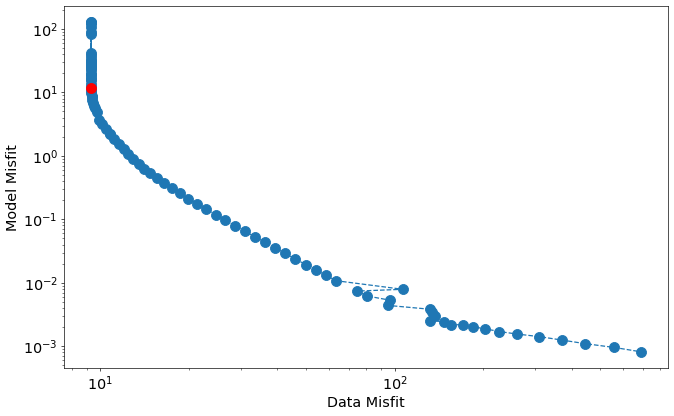

In [18]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.loglog(*fsvals.T, 'o--', markersize=12)
ax.set_xlabel("Data Misfit", size='xx-large')
ax.set_ylabel("Model Misfit", size='xx-large')
idx = 35
ax.loglog(*fsvals[idx], 'ro', markersize=12)
ax.tick_params(labelsize='xx-large')

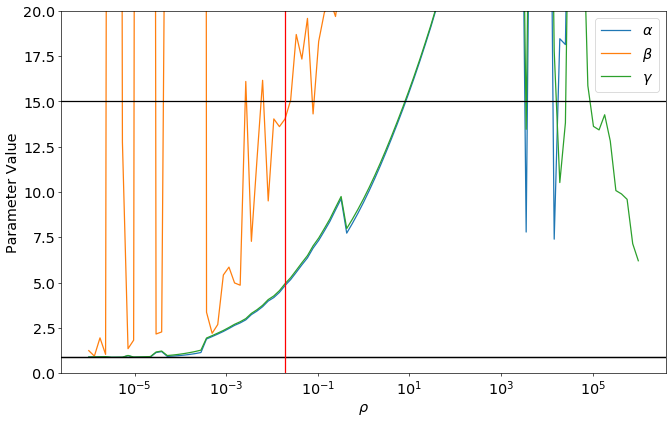

In [19]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(pranges, [float(s['x'][-3]) for s in sols], label=r'$\alpha$')
ax.plot(pranges, [float(s['x'][-2]) for s in sols], label=r'$\beta$')
ax.plot(pranges, [float(s['x'][-1]) for s in sols], label=r'$\gamma$')
for q in p0:
    ax.axhline(q, color='k')
ax.legend(loc="best",fontsize='xx-large')

ax.axvline(pranges[idx], color='r')
ax.set_xlabel(r'$\rho$',size='xx-large')
ax.set_ylabel('Parameter Value', size='xx-large')
ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_ylim(0, 20)
ax.tick_params(labelsize='xx-large')

In [20]:
getp = ca.Function('getx', [solver_setup['x']], model.ps)
getp(sols[idx]['x'])

(DM(4.84144), DM(14.035), DM(4.94147))

9.30607 11.8575


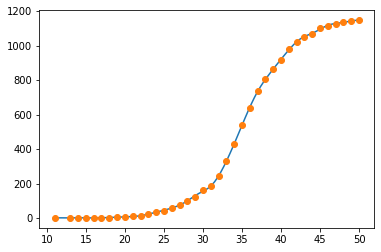

In [21]:
idx = 35
print(f1_ex(sols[idx]['x']), f2_ex(sols[idx]['x']))
plt.plot(model.observation_times, getx(sols[idx]['x'])[-1], label='model')
plt.plot(time, data, 'o', label='data')

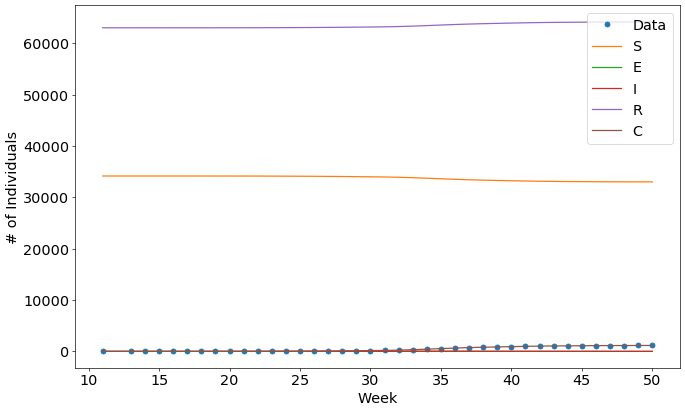

In [22]:
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(time, data, 'o', label='Data')
ax.plot(model.observation_times, getx(sols[idx]['x'])[0], label='S')
ax.plot(model.observation_times, getx(sols[idx]['x'])[1], label='E')
ax.plot(model.observation_times, getx(sols[idx]['x'])[2], label='I')
ax.plot(model.observation_times, getx(sols[idx]['x'])[3], label='R')
ax.plot(model.observation_times, getx(sols[idx]['x'])[4], label='C')
ax.legend(fontsize='xx-large')
ax.set_xlabel('Week',size='xx-large')
ax.set_ylabel('# of Individuals',size='xx-large')
ax.tick_params(labelsize='xx-large')

In [23]:
N = np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1)
print(np.mean(N), np.std(N))

97604.57027374979 458.1712936915086


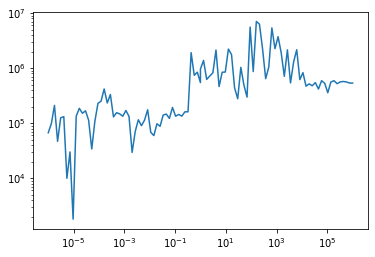

In [24]:
getN = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]).sum(axis=1))
plt.loglog(pranges, [getN(i) for i,_ in enumerate(pranges)])

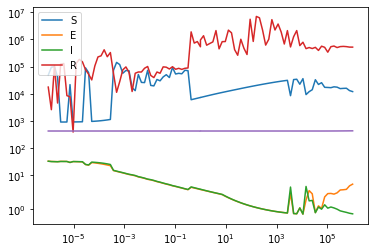

In [25]:
getM = lambda idx: np.mean(np.hstack([np.array(x) for x in getx(sols[idx]['x'])]), axis=0)
plt.semilogx(pranges, [getM(i) for i,_ in enumerate(pranges)])
plt.yscale('symlog')
plt.legend("SEIR")

In [26]:
[x[0] for x in getx(sols[idx]['x'])]

[DM(34151.4), DM(0.0983828), DM(0.0687191), DM(63014.6), DM(1.0059)]

In [27]:
pfin = np.array([float(p) for p in getp(sols[idx]['x'])])
print(f"Recovery Period (Infectious Period): {7/pfin[0]} days")
print(fr"$\beta$: {pfin[1]} effective contacts/week")
print(f"Latent Period: {7/pfin[2]} days")
print(f"$R_0$: {pfin[1]/pfin[0]}")

Recovery Period (Infectious Period): 1.4458516345630728 days
$\beta$: 14.035029235801067 effective contacts/week
Latent Period: 1.4165835713031296 days
$R_0$: 2.8989385659604983


In [28]:
# applying the final size relation
from scipy.optimize import brentq
def rinf(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    r0 = pfin[1]/pfin[0]
    S0, E0, I0, R0, C0 = [float(x[0]) for x in getx(sol['x'])]
    N = sum((S0, E0, I0, R0))
    f = lambda y: y/S0 - np.exp(r0*(y-N)/N) 
    sinf = brentq(f, 0, S0) 
    return N-sinf

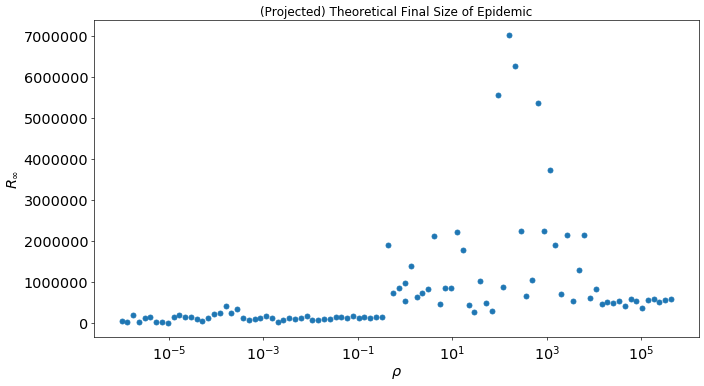

In [37]:
fig, ax = plt.subplots(figsize=[13, 7], dpi=60)
ax.semilogx(pranges[:-3], [rinf(sol) for sol in sols][:-3], 'o')
ax.set_title("(Projected) Theoretical Final Size of Epidemic", fontsize="x-large")
ax.set_xlabel(r"$\rho$", size='xx-large')
ax.set_ylabel(r"$R_\infty$", size='xx-large')
ax.tick_params(labelsize='xx-large')


(0, 20)

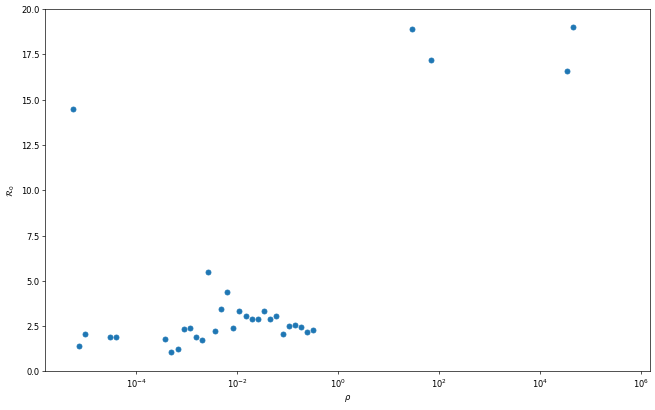

In [30]:
def r0(sol):
    pfin = np.array([float(p) for p in getp(sol['x'])])
    return pfin[1]/pfin[0]
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)
ax.plot(pranges[6:-3], [r0(sol) for sol in sols][6:-3], 'o')
ax.set_xscale('log')
ax.set_xlabel(r'$\rho$')
ax.set_ylabel(r'$\mathcal{R}_0$')
ax.set_ylim(0, 20)

## Profiling

In [31]:
profiler_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
}
opts = {'ipopt': {'dual_inf_tol': 1e-1, 'max_iter': 300, 'print_frequency_iter': 10}}
profiler = ca.nlpsol('solver', 'ipopt', profiler_setup, opts)

In [32]:
idx = 43
rho = pranges[idx]
pref = getp(sols[idx]['x'])
lbx = [-np.inf]*(config['basis_number']*config['model_form']['state']) + [0]*config['model_form']['parameters']
ubx = [np.inf]*(config['basis_number']*config['model_form']['state'] + config['model_form']['parameters'])

profiles = []
for pdx in range(config['model_form']['parameters']):
    pdx_mod = config['basis_number']*config['model_form']['state'] + pdx
    pvals = np.logspace(-1, 1, num=50)
    profiles.append([])
    for pval in pvals:
        lbx0 = np.array(lbx)
        ubx0 = np.array(ubx)
        lbx0[pdx_mod] = pval
        ubx0[pdx_mod] = pval
        profiles[pdx].append(profiler(x0=np.array(sols[idx]['x']).flatten(), p=[rho, 0], lbx=lbx0, ubx=ubx0))

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1971

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  90  7.0171187e+01 0.00e+00 1.37e+00  -2.5 6.09e+01  -8.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  7.0107632e+01 0.00e+00 9.15e-01  -2.5 1.55e+01  -7.3 1.00e+00 5.00e-01f  2
 110  6.9956839e+01 0.00e+00 1.15e+00  -3.8 1.79e+01  -5.8 1.00e+00 5.00e-01f  2
 120  6.9897219e+01 0.00e+00 7.70e-02  -3.8 3.21e+00  -6.0 1.00e+00 1.00e+00f  1
 130  6.9740272e+01 0.00e+00 8.36e-01  -3.8 9.70e+00  -5.4 1.00e+00 1.00e+00f  1
 140  6.9696527e+01 0.00e+00 2.29e+00  -3.8 1.75e+01  -6.5 1.00e+00 1.00e+00f  1
 150  6.9610903e+01 0.00e+00 2.68e+00  -3.8 2.07e+01  -6.8 1.00e+00 1.00e+00f  1
 160  6.9563262e+01 0.00e+00 1.61e+00  -3.8 3.39e+01  -7.0 1.00e+00 5.00e-01f  2
 170  6.9449542e+01 0.00e+00 1.38e-01  -3.8 5.65e+00  -5.5 1.00e+00 1.00e+00f  1
 180  6.9296550e+01 0.00e+00 1.09e-01  -3.8 5.43e+00  -5.7 1.00e+00 1.00e+00f  1
 190  6.9138812e+01 0.00e+00 5.83e-01  -3.8 2.79e+01  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1971

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.8698992e+02 0.00e+00 7.98e+01  -1.0 0.00e+00    -  0.00e+00 0.

 120  5.6460388e+01 0.00e+00 2.93e+00  -5.7 6.44e+02  -8.3 1.00e+00 1.00e+00f  1
 130  5.6223683e+01 0.00e+00 1.42e+00  -5.7 1.89e+02  -7.7 1.00e+00 1.00e+00f  1
 140  5.5975524e+01 0.00e+00 4.86e-02  -5.7 2.11e+00  -4.3 1.00e+00 1.00e+00f  1
 150  5.5929688e+01 0.00e+00 1.06e+00  -5.7 4.42e+01  -6.4 1.00e+00 2.50e-01f  3
 160  5.5495189e+01 0.00e+00 1.39e+01  -5.7 2.14e+03  -8.5 1.00e+00 1.00e+00f  1
 170  5.4804840e+01 0.00e+00 3.50e-02  -5.7 5.82e-01  -4.2 1.00e+00 1.00e+00f  1
 180  5.4579273e+01 0.00e+00 1.21e+00  -5.7 2.50e+01  -6.3 1.00e+00 1.00e+00f  1
 190  5.3798333e+01 0.00e+00 2.91e+00  -5.7 5.36e+02  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.2891667e+01 0.00e+00 2.96e-01  -5.7 2.25e+01  -5.9 1.00e+00 1.00e+00f  1
 210  5.1894044e+01 0.00e+00 6.91e-03  -5.7 7.26e+00  -5.2 1.00e+00 1.00e+00f  1
 220  5.0167347e+01 0.00e+00 4.46e-02  -5.7 2.15e+01  -5.5 1.00e+00 1.00e+00f  1
 230  4.7629541e+01 0.00e+00

  40  1.0424235e+02 0.00e+00 1.30e-01  -2.5 2.33e+00  -1.3 1.00e+00 1.00e+00f  1
  50  5.3752249e+01 0.00e+00 9.81e-01  -2.5 1.56e+01  -3.3 1.00e+00 1.00e+00f  1
  60  5.0748565e+01 0.00e+00 3.40e+00  -2.5 5.96e+01  -8.1 1.00e+00 5.00e-01f  2
  70  5.0553262e+01 0.00e+00 8.50e-01  -2.5 2.90e+00  -4.5 1.00e+00 1.00e+00f  1
  80  5.0465744e+01 0.00e+00 1.46e+00  -2.5 1.75e+03  -9.3 1.00e+00 1.00e+00f  1
  90  5.0427807e+01 0.00e+00 1.08e+00  -2.5 3.80e+02  -8.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.0246671e+01 0.00e+00 3.81e-01  -3.8 1.52e+01  -7.1 1.00e+00 1.00e+00f  1
 110  5.0182211e+01 0.00e+00 1.06e+00  -3.8 8.09e+00  -6.5 1.00e+00 1.00e+00f  1
 120  5.0122116e+01 0.00e+00 1.12e+00  -3.8 9.34e+00  -6.7 1.00e+00 1.00e+00f  1
 130  4.9990900e+01 0.00e+00 2.19e+00  -3.8 1.41e+01  -6.1 1.00e+00 1.00e+00f  1
 140  4.9760025e+01 0.00e+00 1.04e+00  -3.8 1.08e+01  -5.4 1.00e+00 1.00e+00f  1
 150  4.9617003e+01 0.00e+00

 130  4.3313399e+01 0.00e+00 1.32e+00  -5.7 7.56e+02  -8.6 1.00e+00 1.00e+00f  1
 140  4.3156894e+01 0.00e+00 4.31e+00  -5.7 2.17e+02  -7.9 1.00e+00 5.00e-01f  2
 150  4.2977129e+01 0.00e+00 5.94e-02  -5.7 2.60e+00  -4.6 1.00e+00 1.00e+00f  1
 160  4.2656325e+01 0.00e+00 2.24e-02  -5.7 3.14e-01  -3.9 1.00e+00 1.00e+00f  1
 170  4.2517513e+01 0.00e+00 5.53e-01  -5.7 9.12e+00  -5.1 1.00e+00 1.00e+00f  1
 180  4.2447471e+01 0.00e+00 2.48e+00  -5.7 4.34e+01  -6.3 1.00e+00 5.00e-01f  2
 190  4.2288947e+01 0.00e+00 1.29e+01  -5.7 1.67e+02  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.1922346e+01 0.00e+00 1.81e-01  -5.7 6.96e+00  -5.9 1.00e+00 1.00e+00f  1
 210  4.1360302e+01 0.00e+00 1.41e+01  -5.7 1.06e+03  -7.9 1.00e+00 1.00e+00f  1
 220  4.0328797e+01 0.00e+00 5.03e-01  -5.7 6.86e+00  -5.5 1.00e+00 1.00e+00f  1
 230  3.8828288e+01 0.00e+00 5.54e-01  -5.7 1.77e+02  -6.6 1.00e+00 1.00e+00f  1
 240  3.6059876e+01 0.00e+00

  70  3.7645859e+01 0.00e+00 1.43e-02  -3.8 5.01e-01  -2.5 1.00e+00 1.00e+00f  1
  80  3.7609738e+01 0.00e+00 1.04e-01  -3.8 1.82e+01  -7.3 1.00e+00 1.00e+00f  1
  90  3.7522643e+01 0.00e+00 3.18e-01  -3.8 3.58e+00  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.7386127e+01 0.00e+00 1.61e-01  -3.8 2.87e+00  -4.2 1.00e+00 1.00e+00f  1
 110  3.7307915e+01 0.00e+00 1.71e+00  -3.8 1.53e+03  -9.0 1.00e+00 1.00e+00f  1
 120  3.7280975e+01 0.00e+00 8.72e-02  -3.8 3.42e+02  -8.3 1.00e+00 1.00e+00f  1
 130  3.7160476e+01 0.00e+00 2.87e+00  -3.8 9.35e+01  -7.7 1.00e+00 1.00e+00f  1
 140  3.6920190e+01 0.00e+00 1.52e+00  -3.8 1.23e+01  -6.1 1.00e+00 1.00e+00f  1
 150  3.6813336e+01 0.00e+00 2.11e+00  -3.8 1.58e+01  -6.4 1.00e+00 1.00e+00f  1
 160  3.6755225e+01 0.00e+00 6.72e-01  -3.8 1.52e+01  -6.6 1.00e+00 1.00e+00f  1
 170  3.6506698e+01 0.00e+00 2.88e+00  -3.8 3.65e+01  -6.9 1.00e+00 1.00e+00f  1
 180  3.6319538e+01 0.00e+00

  40  3.2748104e+01 0.00e+00 4.63e-01  -1.7 1.70e+01  -4.9 1.00e+00 1.00e+00f  1
  50  3.2570247e+01 0.00e+00 3.13e+00  -1.7 1.97e+03  -9.6 1.00e+00 1.00e+00f  1
  60  3.2343196e+01 0.00e+00 8.19e-01  -2.5 2.62e+00  -4.3 1.00e+00 1.00e+00f  1
  70  3.2274580e+01 0.00e+00 8.32e-01  -2.5 7.44e+02  -9.1 1.00e+00 2.50e-01f  3
  80  3.2189936e+01 0.00e+00 4.39e-01  -2.5 2.33e+01  -7.5 1.00e+00 1.00e+00f  1
  90  3.2107851e+01 0.00e+00 6.97e-01  -2.5 4.98e+00  -6.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.2032683e+01 0.00e+00 7.73e-01  -2.5 5.77e+00  -4.4 1.00e+00 1.00e+00f  1
 110  3.1998228e+01 0.00e+00 9.05e-01  -2.5 1.69e+03  -9.2 1.00e+00 3.12e-02f  6
 120  3.1886962e+01 0.00e+00 1.11e+00  -2.5 5.56e+01  -7.6 1.00e+00 2.50e-01f  3
 130  3.1787512e+01 0.00e+00 1.13e+00  -2.5 1.51e+01  -7.0 1.00e+00 1.00e+00f  1
 140  3.1715286e+01 0.00e+00 3.94e-01  -2.5 6.86e+01  -5.4 1.00e+00 1.25e-01f  4
 150  3.1502476e+01 0.00e+00

 170  2.6178671e+01 0.00e+00 2.85e+00  -5.7 2.99e+01  -6.7 1.00e+00 1.00e+00f  1
 180  2.5969022e+01 0.00e+00 1.67e+00  -5.7 6.66e+01  -7.0 1.00e+00 1.00e+00f  1
 190  2.5514092e+01 0.00e+00 3.01e-01  -5.7 1.78e+02  -7.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.4764122e+01 0.00e+00 5.91e+00  -5.7 5.35e+02  -7.5 1.00e+00 1.00e+00f  1
 210  2.3824181e+01 0.00e+00 1.49e-03  -5.7 5.94e-01  -4.1 1.00e+00 1.00e+00f  1
 220  2.3381325e+01 0.00e+00 6.58e-01  -5.7 5.52e+01  -6.2 1.00e+00 1.00e+00f  1
 230  2.2188691e+01 0.00e+00 7.36e-01  -5.7 1.55e+02  -6.4 1.00e+00 1.00e+00f  1
 240  2.0591329e+01 0.00e+00 3.95e-01  -5.7 5.56e+01  -5.8 1.00e+00 1.00e+00f  1
 250  1.8333584e+01 0.00e+00 1.12e+01  -5.7 1.65e+02  -6.0 1.00e+00 1.00e+00f  1
 260  1.5724074e+01 0.00e+00 1.38e+00  -5.7 5.13e+01  -5.4 1.00e+00 1.00e+00f  1
 270  1.2585270e+01 0.00e+00 1.31e+01  -5.7 7.63e+01  -5.7 1.00e+00 1.00e+00f  1
 280  1.2206181e+01 0.00e+00

 150  2.1242998e+01 0.00e+00 2.46e+00  -3.8 3.29e+01  -5.7 1.00e+00 5.00e-01f  2
 160  2.0923025e+01 0.00e+00 7.35e-01  -3.8 9.50e+00  -5.0 1.00e+00 1.00e+00f  1
 170  2.0456917e+01 0.00e+00 6.50e-01  -3.8 3.86e+01  -6.2 1.00e+00 1.00e+00f  1
 180  1.9162889e+01 0.00e+00 2.07e-03  -3.8 2.18e+00  -4.6 1.00e+00 1.00e+00f  1
 190  1.8355233e+01 0.00e+00 2.56e-03  -5.7 4.85e+00  -4.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.7180128e+01 0.00e+00 1.23e+00  -5.7 9.87e+01  -6.1 1.00e+00 1.00e+00f  1
 210  1.5746185e+01 0.00e+00 3.32e-01  -5.7 3.10e+01  -5.4 1.00e+00 1.00e+00f  1
 220  1.3023489e+01 0.00e+00 1.53e-01  -5.7 9.83e+00  -4.8 1.00e+00 1.00e+00f  1
 230  1.2055152e+01 0.00e+00 1.07e+00  -5.7 2.42e+01  -5.9 1.00e+00 1.00e+00f  1
 240  1.2043225e+01 0.00e+00 7.50e-01  -5.7 4.64e+04    -  1.00e+00 6.25e-02f  5
 250  1.2042346e+01 0.00e+00 1.31e-02  -5.7 2.10e+00  -7.1 1.00e+00 1.00e+00f  1
 260  1.2042157e+01 0.00e+00

  90  2.0359733e+01 0.00e+00 5.15e-01  -3.8 2.01e+01  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.0306100e+01 0.00e+00 1.17e-01  -3.8 2.55e+00  -6.0 1.00e+00 1.00e+00f  1
 110  2.0213574e+01 0.00e+00 1.71e-04  -5.7 4.97e-02  -2.5 1.00e+00 1.00e+00f  1
 120  2.0207228e+01 0.00e+00 2.71e-01  -5.7 1.47e+01  -7.2 1.00e+00 1.00e+00f  1
 130  2.0151971e+01 0.00e+00 5.94e-01  -5.7 6.64e+00  -6.6 1.00e+00 1.00e+00f  1
 140  2.0128172e+01 0.00e+00 7.88e+00  -5.7 4.82e+02  -8.6 1.00e+00 1.00e+00f  1
 150  2.0045999e+01 0.00e+00 2.47e-01  -5.7 1.31e+02  -8.0 1.00e+00 1.00e+00f  1
 160  1.9972712e+01 0.00e+00 3.99e+00  -5.7 3.51e+01  -7.4 1.00e+00 1.00e+00f  1
 170  1.9919089e+01 0.00e+00 1.45e+00  -5.7 7.13e+01  -7.6 1.00e+00 2.50e-01f  3
 180  1.9790853e+01 0.00e+00 3.06e+00  -5.7 1.69e+02  -7.9 1.00e+00 2.50e-01f  3
 190  1.9681561e+01 0.00e+00 3.92e-03  -5.7 5.10e-01  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 130  1.7096055e+01 0.00e+00 5.25e-01  -5.7 5.82e+00  -4.1 1.00e+00 1.00e+00f  1
 140  1.6995192e+01 0.00e+00 2.30e-01  -5.7 4.00e+00  -4.3 1.00e+00 1.00e+00f  1
 150  1.6962882e+01 0.00e+00 5.31e+00  -5.7 8.00e+01  -7.3 1.00e+00 5.00e-01f  2
 160  1.6879752e+01 0.00e+00 9.02e-01  -5.7 9.86e+00  -5.7 1.00e+00 1.00e+00f  1
 170  1.6749092e+01 0.00e+00 7.43e-01  -5.7 9.66e+00  -6.0 1.00e+00 1.00e+00f  1
 180  1.6403098e+01 0.00e+00 6.17e-01  -5.7 1.49e+01  -6.3 1.00e+00 1.00e+00f  1
 190  1.6018061e+01 0.00e+00 4.48e-01  -5.7 3.92e+01  -6.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.5445946e+01 0.00e+00 4.81e-03  -5.7 1.85e+00  -5.0 1.00e+00 1.00e+00f  1
 210  1.5163334e+01 0.00e+00 1.66e-01  -5.7 3.02e+01  -6.1 1.00e+00 1.00e+00f  1
 220  1.4698404e+01 0.00e+00 3.57e-01  -5.7 7.13e+01  -6.4 1.00e+00 1.00e+00f  1
 230  1.3470303e+01 0.00e+00 1.89e-01  -5.7 2.74e+01  -5.7 1.00e+00 1.00e+00f  1
 240  1.2499879e+01 0.00e+00

  40  1.6151574e+01 0.00e+00 1.83e-01  -3.8 2.06e+03 -10.3 1.00e+00 1.00e+00f  1
  50  1.5867514e+01 0.00e+00 4.80e-03  -3.8 9.68e-02  -1.3 1.00e+00 1.00e+00f  1
  60  1.5814339e+01 0.00e+00 2.22e-01  -3.8 1.68e+00  -6.1 1.00e+00 1.00e+00f  1
  70  1.5714489e+01 0.00e+00 6.20e-02  -3.8 1.16e+00  -3.6 1.00e+00 1.00e+00f  1
  80  1.5681270e+01 0.00e+00 1.32e+00  -3.8 2.55e+02  -8.4 1.00e+00 1.00e+00f  1
  90  1.5632734e+01 0.00e+00 2.72e-01  -3.8 6.22e+01  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.5590850e+01 0.00e+00 1.59e-01  -3.8 1.23e+02  -8.0 1.00e+00 1.00e+00f  1
 110  1.5535212e+01 0.00e+00 1.40e+00  -3.8 1.44e+01  -6.5 1.00e+00 5.00e-01f  2
 120  1.5478706e+01 0.00e+00 5.67e-01  -3.8 9.07e+00  -5.8 1.00e+00 5.00e-01f  2
 130  1.5372396e+01 0.00e+00 8.76e-01  -3.8 7.14e+00  -5.2 1.00e+00 1.00e+00f  1
 140  1.5321846e+01 0.00e+00 1.03e+00  -3.8 8.45e+00  -5.4 1.00e+00 1.00e+00f  1
 150  1.5226390e+01 0.00e+00

 120  1.3756926e+01 0.00e+00 4.97e-02  -3.8 2.40e+02  -7.9 1.00e+00 1.00e+00f  1
 130  1.3575862e+01 0.00e+00 2.16e-01  -3.8 9.50e+00  -6.4 1.00e+00 1.00e+00f  1
 140  1.3393623e+01 0.00e+00 4.13e-01  -3.8 4.95e+00  -4.8 1.00e+00 1.00e+00f  1
 150  1.3197926e+01 0.00e+00 1.25e-02  -3.8 9.26e-01  -4.2 1.00e+00 1.00e+00f  1
 160  1.3134194e+01 0.00e+00 6.75e-01  -3.8 7.23e+00  -5.4 1.00e+00 1.00e+00f  1
 170  1.3009475e+01 0.00e+00 6.72e-01  -3.8 7.68e+00  -5.6 1.00e+00 1.00e+00f  1
 180  1.2929728e+01 0.00e+00 6.68e-01  -3.8 8.31e+00  -5.9 1.00e+00 1.00e+00f  1
 190  1.2730330e+01 0.00e+00 4.55e-03  -3.8 4.96e-01  -4.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.2631748e+01 0.00e+00 2.91e-01  -3.8 3.10e+01  -6.4 1.00e+00 1.00e+00f  1
 210  1.2331825e+01 0.00e+00 1.91e+01  -3.8 5.49e+02  -7.5 1.00e+00 1.00e+00f  1
 220  1.1984194e+01 0.00e+00 2.05e+00  -3.8 1.61e+02  -6.9 1.00e+00 1.00e+00f  1
 230  1.1829737e+01 0.00e+00

  70  1.3126256e+01 0.00e+00 3.52e-01  -3.8 4.91e+01  -8.0 1.00e+00 1.00e+00f  1
  80  1.3021222e+01 0.00e+00 1.30e-01  -5.7 1.69e+00  -3.5 1.00e+00 1.00e+00f  1
  90  1.3003604e+01 0.00e+00 6.56e-01  -5.7 1.63e+02  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2920995e+01 0.00e+00 2.29e-01  -5.7 2.75e+00  -4.7 1.00e+00 1.00e+00f  1
 110  1.2895244e+01 0.00e+00 1.12e-01  -5.7 2.24e+00  -5.0 1.00e+00 1.00e+00f  1
 120  1.2843946e+01 0.00e+00 1.31e-01  -5.7 2.46e+00  -4.3 1.00e+00 1.00e+00f  1
 130  1.2827425e+01 0.00e+00 5.56e-01  -5.7 5.58e+00  -6.4 1.00e+00 1.00e+00f  1
 140  1.2753508e+01 0.00e+00 3.50e-01  -5.7 4.81e+00  -5.7 1.00e+00 1.00e+00f  1
 150  1.2688572e+01 0.00e+00 4.09e-01  -5.7 5.44e+00  -5.1 1.00e+00 1.00e+00f  1
 160  1.2630454e+01 0.00e+00 5.70e-01  -5.7 6.88e+00  -5.4 1.00e+00 1.00e+00f  1
 170  1.2609977e+01 0.00e+00 2.06e+00  -5.7 7.05e+01  -7.4 1.00e+00 1.00e+00f  1
 180  1.2526527e+01 0.00e+00

 120  1.1580360e+01 0.00e+00 4.00e-01  -5.7 3.86e+00  -4.5 1.00e+00 1.00e+00f  1
 130  1.1519786e+01 0.00e+00 4.34e-01  -5.7 4.36e+00  -4.8 1.00e+00 1.00e+00f  1
 140  1.1445153e+01 0.00e+00 5.00e-01  -5.7 5.04e+00  -5.0 1.00e+00 1.00e+00f  1
 150  1.1410379e+01 0.00e+00 1.17e+00  -5.7 7.39e+01  -7.1 1.00e+00 2.50e-01f  3
 160  1.1298456e+01 0.00e+00 3.34e-03  -5.7 2.66e-01  -3.7 1.00e+00 1.00e+00f  1
 170  1.1232097e+01 0.00e+00 5.99e-02  -5.7 2.13e+00  -4.9 1.00e+00 1.00e+00f  1
 180  1.1137161e+01 0.00e+00 2.17e-01  -5.7 9.07e+00  -6.1 1.00e+00 1.00e+00f  1
 190  1.1079952e+01 0.00e+00 1.79e-01  -5.7 1.68e+01  -6.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0957541e+01 0.00e+00 6.61e+00  -5.7 2.08e+04    -  6.35e-01 6.25e-02f  5
 210  1.0864426e+01 0.00e+00 3.82e-03  -5.7 6.67e-01  -5.3 1.00e+00 1.00e+00f  1
 220  1.0858674e+01 0.00e+00 7.32e-01  -5.7 1.35e+05    -  3.15e-01 6.25e-02f  5
 230  1.0857548e+01 0.00e+00

  30  1.2001161e+01 0.00e+00 1.43e-01  -2.5 1.92e+03 -10.0 1.00e+00 1.00e+00f  1
  40  1.1903620e+01 0.00e+00 1.13e-01  -2.5 8.85e-01  -4.7 1.00e+00 1.00e+00f  1
  50  1.1850790e+01 0.00e+00 1.06e-01  -2.5 4.31e+02  -9.4 1.00e+00 1.00e+00f  1
  60  1.1717682e+01 0.00e+00 3.82e-01  -2.5 4.77e+03 -10.6 1.00e+00 1.00e+00f  1
  70  1.1691740e+01 0.00e+00 3.39e-01  -2.5 4.57e+00  -7.1 1.00e+00 1.00e+00f  1
  80  1.1656658e+01 0.00e+00 2.62e-01  -2.5 7.49e+00  -5.5 1.00e+00 2.50e-01f  3
  90  1.1625493e+01 0.00e+00 2.35e-02  -2.5 9.02e-01  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1614229e+01 0.00e+00 5.95e-01  -3.8 2.79e+02  -8.7 1.00e+00 2.50e-01f  3
 110  1.1595020e+01 0.00e+00 2.00e-01  -3.8 8.39e+00  -7.2 1.00e+00 1.00e+00f  1
 120  1.1576482e+01 0.00e+00 3.33e-01  -3.8 1.64e+01  -7.4 1.00e+00 1.00e+00f  1
 130  1.1534738e+01 0.00e+00 7.21e-01  -3.8 5.65e+00  -5.9 1.00e+00 1.00e+00f  1
 140  1.1518101e+01 0.00e+00

 130  1.1179079e+01 0.00e+00 6.56e-02  -5.7 1.61e+00  -5.8 1.00e+00 1.00e+00f  1
 140  1.1153262e+01 0.00e+00 1.39e-01  -5.7 2.48e+00  -5.2 1.00e+00 1.00e+00f  1
 150  1.1120558e+01 0.00e+00 4.88e-03  -5.7 4.09e-01  -3.6 1.00e+00 1.00e+00f  1
 160  1.1115073e+01 0.00e+00 7.69e-03  -5.7 1.59e+02  -8.4 1.00e+00 1.00e+00f  1
 170  1.1097090e+01 0.00e+00 4.99e-01  -5.7 3.87e+01  -7.7 1.00e+00 1.00e+00f  1
 180  1.1063500e+01 0.00e+00 1.06e+00  -5.7 3.36e+01  -7.1 1.00e+00 2.50e-01f  3
 190  1.1049570e+01 0.00e+00 1.57e+00  -5.7 1.62e+02  -8.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.1024863e+01 0.00e+00 1.96e+00  -5.7 3.28e+02  -8.5 1.00e+00 1.00e+00f  1
 210  1.0991637e+01 0.00e+00 2.26e+00  -5.7 8.63e+01  -7.9 1.00e+00 1.00e+00f  1
 220  1.0961890e+01 0.00e+00 3.32e-03  -5.7 4.67e-01  -4.5 1.00e+00 1.00e+00f  1
 230  1.0948793e+01 0.00e+00 1.48e-01  -5.7 4.23e+00  -5.7 1.00e+00 1.00e+00f  1
 240  1.0924015e+01 0.00e+00

  50  1.1054119e+01 0.00e+00 1.93e-01  -3.8 4.87e+01  -8.5 1.00e+00 2.50e-01f  3
  60  1.1018239e+01 0.00e+00 4.49e-01  -3.8 2.04e+00  -7.0 1.00e+00 1.00e+00f  1
  70  1.0981277e+01 0.00e+00 2.49e-01  -3.8 1.70e+00  -3.4 1.00e+00 1.00e+00f  1
  80  1.0967634e+01 0.00e+00 2.50e-01  -3.8 3.22e+01  -8.2 1.00e+00 5.00e-01f  2
  90  1.0950158e+01 0.00e+00 3.74e-01  -3.8 2.61e+00  -6.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0908308e+01 0.00e+00 1.20e-02  -3.8 4.99e-01  -3.1 1.00e+00 1.00e+00f  1
 110  1.0902594e+01 0.00e+00 3.33e-01  -3.8 2.40e+01  -7.9 1.00e+00 1.00e+00f  1
 120  1.0889847e+01 0.00e+00 2.53e-01  -3.8 2.79e+00  -6.3 1.00e+00 1.00e+00f  1
 130  1.0878682e+01 0.00e+00 5.94e-02  -3.8 1.58e+00  -5.7 1.00e+00 1.00e+00f  1
 140  1.0863799e+01 0.00e+00 1.46e-01  -3.8 2.52e+00  -5.0 1.00e+00 1.00e+00f  1
 150  1.0847110e+01 0.00e+00 8.71e-02  -3.8 2.07e+00  -4.4 1.00e+00 1.00e+00f  1
 160  1.0841280e+01 0.00e+00

  80  1.0713527e+01 0.00e+00 4.95e-01  -3.8 3.05e+01  -8.0 1.00e+00 1.00e+00f  1
  90  1.0694086e+01 0.00e+00 4.02e-01  -5.7 2.37e+00  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0680030e+01 0.00e+00 6.05e-01  -5.7 6.17e+02  -9.2 1.00e+00 1.00e+00f  1
 110  1.0663848e+01 0.00e+00 3.85e-01  -5.7 1.86e+01  -7.7 1.00e+00 1.00e+00f  1
 120  1.0652313e+01 0.00e+00 2.04e-01  -5.7 2.24e+00  -6.1 1.00e+00 1.00e+00f  1
 130  1.0642627e+01 0.00e+00 4.70e-02  -5.7 1.25e+00  -5.5 1.00e+00 1.00e+00f  1
 140  1.0625468e+01 0.00e+00 2.21e-02  -5.7 8.48e-01  -3.9 1.00e+00 1.00e+00f  1
 150  1.0619451e+01 0.00e+00 1.39e-01  -5.7 2.62e+02  -8.7 1.00e+00 1.00e+00f  1
 160  1.0598398e+01 0.00e+00 5.22e-01  -5.7 5.68e+02  -9.0 1.00e+00 1.00e+00f  1
 170  1.0593766e+01 0.00e+00 2.43e-02  -5.7 1.25e+02  -8.3 1.00e+00 1.00e+00f  1
 180  1.0576440e+01 0.00e+00 5.31e-02  -5.7 3.84e+00  -6.8 1.00e+00 1.00e+00f  1
 190  1.0567384e+01 0.00e+00

 140  1.0498273e+01 0.00e+00 7.11e-02  -5.7 1.24e+03  -9.4 1.00e+00 5.00e-01f  2
 150  1.0493305e+01 0.00e+00 7.92e-03  -5.7 2.04e+02  -8.7 1.00e+00 1.00e+00f  1
 160  1.0487874e+01 0.00e+00 9.23e-02  -5.7 2.04e+00  -6.3 1.00e+00 1.00e+00f  1
 170  1.0478624e+01 0.00e+00 1.04e-01  -5.7 2.27e+00  -5.6 1.00e+00 1.00e+00f  1
 180  1.0468017e+01 0.00e+00 1.89e-03  -5.7 3.14e-01  -4.1 1.00e+00 1.00e+00f  1
 190  1.0462161e+01 0.00e+00 3.35e-01  -5.7 3.41e+02  -8.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0457888e+01 0.00e+00 2.83e-01  -5.7 1.96e+01  -5.5 1.00e+00 2.50e-01f  3
 210  1.0451674e+01 0.00e+00 3.02e-01  -5.7 4.61e+00  -5.7 1.00e+00 1.00e+00f  1
 220  1.0437458e+01 0.00e+00 2.09e-02  -5.7 1.28e+00  -5.1 1.00e+00 1.00e+00f  1
 230  1.0429810e+01 0.00e+00 3.85e-02  -5.7 1.81e+00  -5.3 1.00e+00 1.00e+00f  1
 240  1.0427826e+01 0.00e+00 3.39e-02  -5.7 1.30e+01  -7.4 1.00e+00 1.00e+00f  1
 250  1.0424636e+01 0.00e+00

  40  1.0586464e+01 0.00e+00 1.34e-01  -3.8 1.44e+00  -7.4 1.00e+00 5.00e-01f  2
  50  1.0553717e+01 0.00e+00 2.38e-01  -3.8 1.23e+03 -10.3 1.00e+00 6.25e-02f  5
  60  1.0531863e+01 0.00e+00 2.89e-01  -3.8 1.52e+00  -4.1 1.00e+00 1.00e+00f  1
  70  1.0519668e+01 0.00e+00 8.66e-02  -3.8 5.99e+01  -8.9 1.00e+00 1.00e+00f  1
  80  1.0509493e+01 0.00e+00 3.15e-01  -3.8 7.60e+00  -7.3 1.00e+00 2.50e-01f  3
  90  1.0498942e+01 0.00e+00 3.08e-01  -3.8 4.10e+00  -4.9 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0492694e+01 0.00e+00 3.11e-02  -3.8 4.32e+02  -9.6 1.00e+00 1.00e+00f  1
 110  1.0484985e+01 0.00e+00 3.20e-01  -5.7 9.75e+00  -6.1 1.00e+00 2.50e-01f  3
 120  1.0478604e+01 0.00e+00 1.53e-04  -5.7 5.06e-02  -2.5 1.00e+00 1.00e+00f  1
 130  1.0476540e+01 0.00e+00 2.03e-01  -5.7 8.36e+00  -7.3 1.00e+00 2.50e-01f  3
 140  1.0469169e+01 0.00e+00 1.98e-01  -5.7 2.44e+00  -4.8 1.00e+00 1.00e+00f  1
 150  1.0465335e+01 0.00e+00

  80  1.0441861e+01 0.00e+00 3.53e-03  -3.8 2.14e-01  -2.6 1.00e+00 1.00e+00f  1
  90  1.0436762e+01 0.00e+00 7.47e-02  -3.8 1.37e+00  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0430138e+01 0.00e+00 4.33e-02  -3.8 8.94e-01  -5.8 1.00e+00 1.00e+00f  1
 110  1.0424381e+01 0.00e+00 2.90e-01  -3.8 1.84e+03 -10.6 1.00e+00 1.00e+00f  1
 120  1.0419824e+01 0.00e+00 7.01e-02  -5.7 1.28e+00  -7.0 1.00e+00 1.00e+00f  1
 130  1.0414206e+01 0.00e+00 2.15e-02  -5.7 8.35e-01  -5.5 1.00e+00 1.00e+00f  1
 140  1.0409706e+01 0.00e+00 6.53e-02  -5.7 2.38e+03 -10.3 1.00e+00 5.00e-01f  2
 150  1.0407237e+01 0.00e+00 1.46e-01  -5.7 4.35e+01  -8.7 1.00e+00 1.00e+00f  1
 160  1.0396525e+01 0.00e+00 3.38e-01  -5.7 6.69e+00  -6.3 1.00e+00 5.00e-01f  2
 170  1.0387557e+01 0.00e+00 6.80e-02  -5.7 3.11e+03 -11.0 1.00e+00 1.00e+00f  1
 180  1.0385193e+01 0.00e+00 6.47e-02  -5.7 3.99e+02  -9.5 1.00e+00 1.00e+00f  1
 190  1.0379620e+01 0.00e+00

  20  1.0515868e+01 0.00e+00 6.50e-02  -3.8 4.16e+01  -9.1 1.00e+00 1.00e+00f  1
  30  1.0468004e+01 0.00e+00 8.00e-02  -3.8 9.35e+02 -10.2 1.00e+00 1.00e+00f  1
  40  1.0430164e+01 0.00e+00 4.52e-03  -3.8 2.14e-01  -3.1 1.00e+00 1.00e+00f  1
  50  1.0414588e+01 0.00e+00 8.99e-02  -3.8 4.12e+00  -7.8 1.00e+00 2.50e-01f  3
  60  1.0398297e+01 0.00e+00 1.83e-02  -3.8 7.19e+02  -9.9 1.00e+00 1.00e+00f  1
  70  1.0391638e+01 0.00e+00 1.52e-02  -3.8 4.23e-01  -6.3 1.00e+00 1.00e+00f  1
  80  1.0383810e+01 0.00e+00 9.77e-03  -5.7 3.21e-01  -2.8 1.00e+00 1.00e+00f  1
  90  1.0379263e+01 0.00e+00 1.12e-01  -5.7 4.21e+00  -7.6 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0372002e+01 0.00e+00 1.24e-01  -5.7 1.33e+00  -4.0 1.00e+00 1.00e+00f  1
 110  1.0369053e+01 0.00e+00 1.18e-01  -5.7 4.50e+01  -8.8 1.00e+00 1.00e+00f  1
 120  1.0360713e+01 0.00e+00 1.17e-01  -5.7 2.56e+00  -5.2 1.00e+00 5.00e-01f  2
 130  1.0358326e+01 0.00e+00

 120  1.0339459e+01 0.00e+00 2.76e-01  -3.8 8.36e+03 -10.8 1.00e+00 1.25e-01f  4
 130  1.0334520e+01 0.00e+00 1.55e-01  -5.7 1.79e+00  -5.5 1.00e+00 1.00e+00f  1
 140  1.0332545e+01 0.00e+00 6.49e-01  -5.7 8.34e+02 -10.3 1.00e+00 1.00e+00f  1
 150  1.0328969e+01 0.00e+00 1.19e-01  -5.7 3.02e+00  -6.7 1.00e+00 5.00e-01f  2
 160  1.0326558e+01 0.00e+00 2.63e-01  -5.7 5.45e+00  -5.2 1.00e+00 5.00e-01f  2
 170  1.0325479e+01 0.00e+00 1.43e-01  -5.7 4.73e+02  -9.9 1.00e+00 6.25e-02f  5
 180  1.0324018e+01 0.00e+00 5.45e-02  -5.7 1.20e+02  -9.3 1.00e+00 1.00e+00f  1
 190  1.0321049e+01 0.00e+00 6.15e-02  -5.7 1.55e+00  -5.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0320275e+01 0.00e+00 1.45e-01  -5.7 2.47e+00  -6.0 1.00e+00 1.00e+00f  1
 210  1.0319160e+01 0.00e+00 8.57e-02  -5.7 1.98e+00  -5.3 1.00e+00 1.00e+00f  1
 220  1.0318285e+01 0.00e+00 1.67e-01  -5.7 1.01e+03 -10.1 1.00e+00 5.00e-01f  2
 230  1.0317503e+01 0.00e+00

 150  9.4107255e+01 0.00e+00 2.06e+01  -3.8 1.42e+02  -7.7 1.00e+00 2.50e-01f  3
 160  9.3647386e+01 0.00e+00 6.29e-01  -3.8 3.46e+00  -5.2 1.00e+00 1.00e+00f  1
 170  9.3560332e+01 0.00e+00 8.33e-01  -3.8 6.12e+01  -7.3 1.00e+00 1.00e+00f  1
 180  9.3304392e+01 0.00e+00 2.52e+00  -3.8 1.45e+01  -6.6 1.00e+00 1.00e+00f  1
 190  9.2635316e+01 0.00e+00 1.84e+00  -3.8 9.84e+00  -6.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  9.2417557e+01 0.00e+00 9.32e+00  -3.8 4.49e+02  -8.1 1.00e+00 6.25e-02f  5
 210  9.1676378e+01 0.00e+00 1.04e+00  -3.8 1.07e+01  -5.6 1.00e+00 1.00e+00f  1
 220  9.1469386e+01 0.00e+00 3.90e+00  -3.8 5.22e+01  -6.8 1.00e+00 5.00e-01f  2
 230  9.1125224e+01 0.00e+00 7.61e-01  -3.8 4.97e+01  -7.0 1.00e+00 1.00e+00f  1
 240  8.9848857e+01 0.00e+00 8.99e-01  -3.8 8.50e+02  -8.2 1.00e+00 1.00e+00f  1
 250  8.9239664e+01 0.00e+00 2.15e-01  -3.8 2.58e+01  -6.6 1.00e+00 1.00e+00f  1
 260  8.7703775e+01 0.00e+00

  80  1.0157532e+02 0.00e+00 4.44e+01  -3.8 4.74e+01  -4.1 1.00e+00 1.00e+00f  1
  90  9.5337252e+01 0.00e+00 1.09e+00  -3.8 4.89e+00  -3.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.3770207e+01 0.00e+00 5.19e-01  -3.8 2.84e+00  -5.5 1.00e+00 1.00e+00f  1
 110  9.3534525e+01 0.00e+00 3.04e+00  -3.8 3.38e+00  -5.8 1.00e+00 1.00e+00f  1
 120  9.3177401e+01 0.00e+00 1.74e+00  -3.8 3.27e+00  -5.1 1.00e+00 1.00e+00f  1
 130  9.2971468e+01 0.00e+00 8.97e-01  -3.8 5.13e+02  -8.1 1.00e+00 1.00e+00f  1
 140  9.2812209e+01 0.00e+00 9.54e-01  -3.8 1.44e+01  -6.5 1.00e+00 1.00e+00f  1
 150  9.2520508e+01 0.00e+00 2.93e+01  -3.8 2.09e+02  -7.7 1.00e+00 1.00e+00f  1
 160  9.1766409e+01 0.00e+00 2.55e-01  -3.8 3.25e+00  -5.2 1.00e+00 1.00e+00f  1
 170  9.1426316e+01 0.00e+00 1.52e+00  -3.8 6.92e+02  -8.2 1.00e+00 1.00e+00f  1
 180  9.1129356e+01 0.00e+00 4.75e-02  -3.8 1.62e+02  -7.5 1.00e+00 1.00e+00f  1
 190  9.0568088e+01 0.00e+00

  30  4.0297141e+02 0.00e+00 9.67e+00  -2.5 8.64e+00  -1.9 1.00e+00 1.00e+00f  1
  40  3.2569185e+02 0.00e+00 1.16e+01  -2.5 1.15e+01  -2.2 1.00e+00 1.00e+00f  1
  50  2.4817841e+02 0.00e+00 1.32e+01  -2.5 1.36e+01  -2.4 1.00e+00 1.00e+00f  1
  60  1.6473993e+02 0.00e+00 6.27e-02  -2.5 1.72e+00  -1.8 1.00e+00 1.00e+00f  1
  70  1.1836672e+02 0.00e+00 3.04e-01  -2.5 1.41e+00  -2.0 1.00e+00 1.00e+00f  1
  80  9.4973138e+01 0.00e+00 1.78e+01  -2.5 3.52e+01  -4.1 1.00e+00 1.00e+00f  1
  90  9.1555253e+01 0.00e+00 1.68e+00  -2.5 3.59e+01  -4.3 1.00e+00 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  9.1234617e+01 0.00e+00 9.51e-01  -2.5 1.66e+00  -4.6 1.00e+00 1.00e+00f  1
 110  8.9721027e+01 0.00e+00 4.88e-01  -2.5 1.02e+00  -3.0 1.00e+00 1.00e+00f  1
 120  8.9534206e+01 0.00e+00 3.91e-01  -2.5 4.11e+02  -7.8 1.00e+00 1.00e+00f  1
 130  8.8966154e+01 0.00e+00 2.60e+00  -2.5 1.06e+01  -5.4 1.00e+00 5.00e-01f  2
 140  8.7796330e+01 0.00e+00

 140  8.4234214e+01 0.00e+00 2.71e-01  -3.8 2.19e+02  -7.4 1.00e+00 1.00e+00f  1
 150  8.2968905e+01 0.00e+00 2.60e-01  -3.8 4.07e+02  -7.7 1.00e+00 1.00e+00f  1
 160  8.2330803e+01 0.00e+00 2.41e-01  -3.8 9.42e+01  -7.0 1.00e+00 1.00e+00f  1
 170  8.1348780e+01 0.00e+00 1.43e-02  -3.8 2.21e+01  -6.4 1.00e+00 1.00e+00f  1
 180  8.0262297e+01 0.00e+00 5.66e-01  -3.8 4.16e+01  -6.6 1.00e+00 1.00e+00f  1
 190  7.8059623e+01 0.00e+00 2.81e-01  -3.8 6.51e+02  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  7.5027779e+01 0.00e+00 1.05e+00  -3.8 1.30e+03  -8.1 1.00e+00 1.00e+00f  1
 210  7.3013244e+01 0.00e+00 3.51e+00  -3.8 2.49e+03  -8.3 1.00e+00 1.00e+00f  1
 220  7.0821927e+01 0.00e+00 1.51e-01  -3.8 5.96e+02  -7.7 1.00e+00 1.00e+00f  1
 230  6.6465525e+01 0.00e+00 3.83e-02  -3.8 1.89e+01  -6.1 1.00e+00 1.00e+00f  1
 240  6.2429446e+01 0.00e+00 6.54e+00  -3.8 2.42e+03  -8.2 1.00e+00 1.00e+00f  1
 250  4.8281988e+01 0.00e+00

  90  8.3261086e+01 0.00e+00 2.82e-01  -2.5 1.29e+02  -7.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  8.2587009e+01 0.00e+00 1.26e-01  -2.5 2.28e+02  -7.3 1.00e+00 1.00e+00f  1
 110  8.1378136e+01 0.00e+00 2.55e-01  -2.5 4.01e+02  -7.6 1.00e+00 1.00e+00f  1
 120  8.0490118e+01 0.00e+00 6.93e+00  -3.8 2.67e+01  -6.0 1.00e+00 5.00e-01f  2
 130  7.8056419e+01 0.00e+00 3.17e-01  -3.8 3.50e+00  -4.5 1.00e+00 1.00e+00f  1
 140  7.7664948e+01 0.00e+00 6.12e+00  -3.8 8.14e+01  -6.5 1.00e+00 2.50e-01f  3
 150  7.6445609e+01 0.00e+00 3.51e+00  -3.8 9.75e+01  -5.9 1.00e+00 2.50e-01f  3
 160  7.5214709e+01 0.00e+00 1.05e+00  -3.8 1.46e+01  -6.1 1.00e+00 1.00e+00f  1
 170  7.3008006e+01 0.00e+00 8.01e+00  -3.8 2.21e+02  -7.3 1.00e+00 1.00e+00f  1
 180  7.1689820e+01 0.00e+00 9.93e+00  -3.8 1.13e+02  -6.6 1.00e+00 5.00e-01f  2
 190  6.9790885e+01 0.00e+00 7.72e-02  -3.8 1.20e+01  -6.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 160  6.4642703e+01 0.00e+00 6.22e-01  -3.8 1.07e+03  -7.9 1.00e+00 1.00e+00f  1
 170  6.3744814e+01 0.00e+00 1.29e-02  -3.8 2.43e+02  -7.3 1.00e+00 1.00e+00f  1
 180  6.1197852e+01 0.00e+00 1.37e-01  -3.8 7.09e+00  -5.7 1.00e+00 1.00e+00f  1
 190  5.8148759e+01 0.00e+00 5.65e-01  -3.8 1.05e+02  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  5.3761432e+01 0.00e+00 6.01e-01  -3.8 1.99e+02  -7.2 1.00e+00 1.00e+00f  1
 210  5.1612933e+01 0.00e+00 6.17e-01  -3.8 3.68e+02  -7.4 1.00e+00 1.00e+00f  1
 220  4.7274026e+01 0.00e+00 3.60e-01  -3.8 8.81e+01  -6.8 1.00e+00 1.00e+00f  1
 230  4.2292919e+01 0.00e+00 1.84e+00  -3.8 1.37e+03  -7.9 1.00e+00 1.00e+00f  1
 240  3.6365372e+01 0.00e+00 2.57e+00  -3.8 3.36e+02  -7.3 1.00e+00 1.00e+00f  1
 250  2.7742197e+01 0.00e+00 1.29e-01  -3.8 8.45e+01  -6.6 1.00e+00 1.00e+00f  1
 260  2.2859138e+01 0.00e+00 7.11e-02  -3.8 1.58e+02  -6.9 1.00e+00 1.00e+00f  1
 270  1.6198407e+01 0.00e+00

 150  5.2409335e+01 0.00e+00 8.36e+00  -3.8 4.94e+03  -8.6 1.00e+00 1.00e+00f  1
 160  5.0793049e+01 0.00e+00 1.88e+00  -3.8 1.11e+03  -6.1 8.94e-01 1.56e-02f  7
 170  4.9128013e+01 0.00e+00 9.60e-01  -3.8 3.14e+01  -6.4 1.00e+00 1.00e+00f  1
 180  4.4969645e+01 0.00e+00 1.33e+01  -3.8 4.67e+02  -7.5 1.00e+00 1.00e+00f  1
 190  4.3194482e+01 0.00e+00 3.51e+00  -3.8 8.54e+02  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  4.0137680e+01 0.00e+00 4.19e+00  -3.8 1.58e+03  -8.1 1.00e+00 1.00e+00f  1
 210  3.4798809e+01 0.00e+00 1.04e-01  -3.8 4.73e+01  -6.5 1.00e+00 1.00e+00f  1
 220  2.7312595e+01 0.00e+00 1.00e+00  -3.8 7.42e+02  -7.7 1.00e+00 1.00e+00f  1
 230  2.3084375e+01 0.00e+00 3.50e+00  -3.8 1.38e+03  -7.9 1.00e+00 1.00e+00f  1
 240  2.0117705e+01 0.00e+00 4.01e-03  -3.8 3.90e+01  -6.4 1.00e+00 1.00e+00f  1
 250  1.6082435e+01 0.00e+00 1.30e+02  -3.8 6.49e+03  -8.4 1.00e+00 5.00e-01f  2
 260  1.2801820e+01 0.00e+00

  60  6.4868370e+01 0.00e+00 4.94e+00  -2.5 3.40e+01  -6.3 1.00e+00 1.25e-01f  4
  70  5.8694416e+01 0.00e+00 8.17e-01  -3.8 1.30e+00  -2.7 1.00e+00 1.00e+00f  1
  80  5.8305871e+01 0.00e+00 2.27e-02  -3.8 4.17e+02  -7.5 1.00e+00 1.00e+00f  1
  90  5.6180543e+01 0.00e+00 5.72e-01  -3.8 1.09e+01  -6.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  5.5461325e+01 0.00e+00 4.01e-01  -3.8 1.57e+02  -7.1 1.00e+00 1.00e+00f  1
 110  5.4278997e+01 0.00e+00 2.03e-01  -3.8 2.82e+02  -7.4 1.00e+00 1.00e+00f  1
 120  5.2295811e+01 0.00e+00 8.09e-02  -3.8 5.05e+02  -7.6 1.00e+00 1.00e+00f  1
 130  4.9167264e+01 0.00e+00 2.14e+00  -3.8 1.41e+01  -6.1 1.00e+00 1.00e+00f  1
 140  4.7577360e+01 0.00e+00 1.99e+00  -3.8 2.53e+01  -6.3 1.00e+00 1.00e+00f  1
 150  4.6758135e+01 0.00e+00 2.01e+00  -3.8 1.74e+01  -5.7 1.00e+00 1.00e+00f  1
 160  4.6000433e+01 0.00e+00 2.00e+01  -3.8 8.20e+01  -6.8 1.00e+00 1.00e+00f  1
 170  4.4650306e+01 0.00e+00

 150  3.8229815e+01 0.00e+00 3.30e-01  -3.8 8.61e+00  -5.9 1.00e+00 1.00e+00f  1
 160  3.6246874e+01 0.00e+00 6.29e-01  -3.8 1.41e+01  -6.1 1.00e+00 1.00e+00f  1
 170  3.2166519e+01 0.00e+00 9.20e-01  -3.8 2.52e+01  -6.4 1.00e+00 1.00e+00f  1
 180  2.9733033e+01 0.00e+00 2.64e+00  -3.8 3.63e+02  -7.5 1.00e+00 1.00e+00f  1
 190  2.5758123e+01 0.00e+00 2.85e+00  -3.8 6.56e+02  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.4017012e+01 0.00e+00 3.72e+00  -3.8 1.19e+03  -8.1 1.00e+00 1.00e+00f  1
 210  2.1017281e+01 0.00e+00 8.86e-02  -3.8 3.36e+01  -6.5 1.00e+00 1.00e+00f  1
 220  1.7562855e+01 0.00e+00 1.63e-01  -3.8 6.00e+01  -6.8 1.00e+00 1.00e+00f  1
 230  1.5044795e+01 0.00e+00 2.43e+00  -3.8 8.24e+02  -7.9 1.00e+00 1.00e+00f  1
 240  1.3945323e+01 0.00e+00 4.57e-03  -3.8 2.21e+01  -6.4 1.00e+00 1.00e+00f  1
 250  1.2930625e+01 0.00e+00 4.35e-01  -3.8 2.89e+02  -7.5 1.00e+00 1.00e+00f  1
 260  1.2277091e+01 0.00e+00

  90  4.1319023e+01 0.00e+00 3.90e+00  -3.8 7.43e+00  -5.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.9989102e+01 0.00e+00 1.66e+00  -3.8 1.25e+01  -5.3 1.00e+00 5.00e-01f  2
 110  3.7449089e+01 0.00e+00 6.83e-01  -3.8 6.03e+00  -4.7 1.00e+00 1.00e+00f  1
 120  3.6929902e+01 0.00e+00 1.06e+00  -3.8 1.78e+01  -5.8 1.00e+00 5.00e-01f  2
 130  3.6222256e+01 0.00e+00 3.70e+00  -3.8 1.59e+02  -7.0 1.00e+00 1.25e-01f  4
 140  3.5134374e+01 0.00e+00 1.08e+00  -3.8 3.21e+03  -7.2 2.05e-01 3.91e-03f  9
 150  3.3245946e+01 0.00e+00 5.21e-01  -3.8 2.84e+02  -7.5 1.00e+00 1.00e+00f  1
 160  3.0857413e+01 0.00e+00 3.09e+00  -3.8 3.98e+03  -8.6 1.00e+00 1.00e+00f  1
 170  3.0352177e+01 0.00e+00 2.21e-01  -3.8 8.92e+02  -8.0 1.00e+00 1.00e+00f  1
 180  2.9527536e+01 0.00e+00 9.65e-01  -3.8 2.48e+01  -6.4 1.00e+00 1.00e+00f  1
 190  2.7450895e+01 0.00e+00 3.84e+00  -3.8 3.52e+02  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

 150  2.7831736e+01 0.00e+00 2.15e-01  -3.8 1.22e+03  -8.2 1.00e+00 1.00e+00f  1
 160  2.5329408e+01 0.00e+00 4.56e-01  -3.8 2.62e+02  -7.5 1.00e+00 1.00e+00f  1
 170  2.3729470e+01 0.00e+00 2.14e+00  -3.8 3.68e+03  -8.7 1.00e+00 1.00e+00f  1
 180  2.2511534e+01 0.00e+00 2.49e-02  -3.8 2.36e+00  -5.4 1.00e+00 1.00e+00f  1
 190  2.1620964e+01 0.00e+00 1.32e+00  -3.8 2.26e+01  -6.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  2.0325113e+01 0.00e+00 1.29e+01  -3.8 3.21e+02  -7.7 1.00e+00 1.00e+00f  1
 210  1.9588168e+01 0.00e+00 1.47e+01  -3.8 2.95e+02  -7.0 1.00e+00 2.50e-01f  3
 220  1.8501083e+01 0.00e+00 2.21e-01  -3.8 1.59e+01  -6.4 1.00e+00 1.00e+00f  1
 230  1.7490621e+01 0.00e+00 1.15e+00  -3.8 2.27e+02  -7.5 1.00e+00 1.00e+00f  1
 240  1.6290364e+01 0.00e+00 7.27e-01  -3.8 4.01e+02  -7.8 1.00e+00 1.00e+00f  1
 250  1.4175395e+01 0.00e+00 4.73e+01  -3.8 5.29e+03  -8.9 1.00e+00 1.00e+00f  1
 260  1.3455985e+01 0.00e+00

  70  3.3206218e+01 0.00e+00 3.62e-01  -3.8 1.29e+00  -4.5 1.00e+00 1.00e+00f  1
  80  3.2035917e+01 0.00e+00 1.40e+00  -3.8 3.20e+00  -3.9 1.00e+00 1.00e+00f  1
  90  3.1330142e+01 0.00e+00 4.74e-01  -3.8 1.49e+01  -4.1 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  3.0886449e+01 0.00e+00 1.93e+00  -3.8 6.77e+00  -5.3 1.00e+00 1.00e+00f  1
 110  2.9441327e+01 0.00e+00 9.93e-01  -3.8 6.49e+00  -4.7 1.00e+00 1.00e+00f  1
 120  2.6843175e+01 0.00e+00 3.44e+00  -3.8 3.34e+01  -4.0 1.00e+00 5.00e-01f  2
 130  2.6336166e+01 0.00e+00 1.24e+00  -3.8 2.06e+01  -5.2 1.00e+00 5.00e-01f  2
 140  2.5755106e+01 0.00e+00 1.36e+00  -3.8 1.44e+01  -6.3 1.00e+00 1.00e+00f  1
 150  2.4915118e+01 0.00e+00 2.75e+00  -3.8 2.52e+01  -6.6 1.00e+00 1.00e+00f  1
 160  2.4495486e+01 0.00e+00 1.28e+00  -3.8 2.89e+01  -5.9 1.00e+00 5.00e-01f  2
 170  2.4109618e+01 0.00e+00 1.83e+01  -3.8 6.34e+02  -8.0 1.00e+00 2.50e-01f  3
 180  2.2962093e+01 0.00e+00

 110  2.4830935e+01 0.00e+00 2.07e+00  -3.8 1.82e+01  -6.5 1.00e+00 1.00e+00f  1
 120  2.3672549e+01 0.00e+00 2.25e+00  -3.8 1.18e+01  -5.8 1.00e+00 1.00e+00f  1
 130  2.3406915e+01 0.00e+00 5.81e-01  -3.8 5.51e+01  -7.0 1.00e+00 1.00e+00f  1
 140  2.2195429e+01 0.00e+00 2.22e+00  -3.8 1.43e+01  -6.3 1.00e+00 1.00e+00f  1
 150  2.1573089e+01 0.00e+00 2.55e+00  -3.8 2.05e+01  -6.6 1.00e+00 1.00e+00f  1
 160  2.1268959e+01 0.00e+00 1.28e+00  -3.8 2.73e+01  -5.9 1.00e+00 5.00e-01f  2
 170  2.1015100e+01 0.00e+00 1.01e+01  -3.8 5.15e+02  -8.0 1.00e+00 1.25e-01f  4
 180  2.0406751e+01 0.00e+00 1.15e+00  -3.8 1.52e+01  -6.4 1.00e+00 1.00e+00f  1
 190  1.9683937e+01 0.00e+00 1.59e+01  -3.8 1.97e+02  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.9341226e+01 0.00e+00 5.60e+00  -3.8 8.00e+01  -7.0 1.00e+00 5.00e-01f  2
 210  1.8288625e+01 0.00e+00 3.88e+00  -3.8 4.81e+03  -9.0 1.00e+00 1.00e+00f  1
 220  1.7158197e+01 0.00e+00

  40  2.7035828e+01 0.00e+00 1.09e+01  -1.7 3.65e+02  -7.6 1.00e+00 1.00e+00f  1
  50  2.4308404e+01 0.00e+00 4.93e-01  -2.5 9.98e-01  -4.0 1.00e+00 1.00e+00f  1
  60  2.3662467e+01 0.00e+00 9.81e-01  -2.5 8.99e+00  -3.4 1.00e+00 2.50e-01f  3
  70  2.3263711e+01 0.00e+00 2.04e-01  -2.5 8.26e+02  -8.2 1.00e+00 1.00e+00f  1
  80  2.2682208e+01 0.00e+00 2.26e+00  -2.5 1.40e+03  -8.4 1.00e+00 1.00e+00f  1
  90  2.1740361e+01 0.00e+00 1.31e+00  -2.5 3.71e+01  -6.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.1404446e+01 0.00e+00 1.39e+00  -2.5 6.54e+01  -7.1 1.00e+00 1.00e+00f  1
 110  2.0940932e+01 0.00e+00 1.85e+00  -2.5 1.14e+02  -7.4 1.00e+00 5.00e-01f  2
 120  2.0250091e+01 0.00e+00 1.38e+00  -2.5 3.62e+01  -6.7 1.00e+00 2.50e-01f  3
 130  1.9587598e+01 0.00e+00 1.38e+00  -3.8 2.73e+03  -8.8 1.00e+00 1.00e+00f  1
 140  1.8845997e+01 0.00e+00 3.52e+00  -3.8 4.68e+03  -9.0 1.00e+00 1.00e+00f  1
 150  1.8733665e+01 0.00e+00

 140  1.5228669e+01 0.00e+00 8.19e-01  -5.7 7.73e+00  -5.2 1.00e+00 1.00e+00f  1
 150  1.5099586e+01 0.00e+00 1.69e+00  -5.7 5.66e+01  -7.3 1.00e+00 5.00e-01f  2
 160  1.4883230e+01 0.00e+00 4.88e-02  -5.7 8.00e+02  -8.5 1.00e+00 1.00e+00f  1
 170  1.4387741e+01 0.00e+00 4.57e+00  -5.7 1.72e+02  -7.8 1.00e+00 1.00e+00f  1
 180  1.3883108e+01 0.00e+00 5.34e-01  -5.7 8.56e+00  -6.3 1.00e+00 1.00e+00f  1
 190  1.3636256e+01 0.00e+00 4.25e-01  -5.7 8.23e+00  -6.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.3523318e+01 0.00e+00 4.81e-02  -5.7 1.44e+01  -6.8 1.00e+00 1.00e+00f  1
 210  1.3321700e+01 0.00e+00 5.15e-01  -5.7 1.64e+03  -8.8 1.00e+00 1.00e+00f  1
 220  1.3093817e+01 0.00e+00 3.12e-01  -5.7 8.72e+00  -6.4 1.00e+00 1.00e+00f  1
 230  1.2727184e+01 0.00e+00 1.28e-02  -5.7 1.88e+00  -5.7 1.00e+00 1.00e+00f  1
 240  1.2509982e+01 0.00e+00 9.98e-01  -5.7 1.72e+01  -6.9 1.00e+00 1.00e+00f  1
 250  1.2228211e+01 0.00e+00

  70  1.7956318e+01 0.00e+00 1.99e+00  -2.5 5.35e+02  -8.2 1.00e+00 1.25e-01f  4
  80  1.7622683e+01 0.00e+00 7.37e-02  -2.5 1.13e+02  -7.5 1.00e+00 1.00e+00f  1
  90  1.7374063e+01 0.00e+00 1.86e-01  -2.5 1.98e+02  -7.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.7002088e+01 0.00e+00 2.03e+00  -2.5 4.27e+01  -7.1 1.00e+00 1.00e+00f  1
 110  1.6792732e+01 0.00e+00 1.02e+00  -2.5 7.50e+01  -7.4 1.00e+00 1.25e-01f  4
 120  1.6421955e+01 0.00e+00 1.80e+00  -2.5 3.96e+01  -6.7 1.00e+00 2.50e-01f  3
 130  1.5910332e+01 0.00e+00 8.60e-01  -2.5 1.41e+01  -6.1 1.00e+00 5.00e-01f  2
 140  1.5787907e+01 0.00e+00 1.40e+00  -2.5 4.84e+01  -7.2 1.00e+00 1.00e+00f  1
 150  1.5509613e+01 0.00e+00 7.95e-01  -2.5 6.73e+02  -8.4 1.00e+00 1.00e+00f  1
 160  1.3952491e+01 0.00e+00 1.66e+00  -3.8 1.55e+01  -6.8 1.00e+00 1.00e+00f  1
 170  1.3708599e+01 0.00e+00 1.97e+00  -3.8 3.17e+01  -7.1 1.00e+00 5.00e-01f  2
 180  1.3582545e+01 0.00e+00

 180  1.2236052e+01 0.00e+00 5.93e-01  -5.7 4.34e+01  -7.5 1.00e+00 1.00e+00f  1
 190  1.2058747e+01 0.00e+00 8.22e-02  -5.7 7.51e+01  -7.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.1984986e+01 0.00e+00 2.85e-01  -5.7 1.66e+01  -7.1 1.00e+00 1.00e+00f  1
 210  1.1921137e+01 0.00e+00 2.05e-03  -5.7 2.36e+02  -8.2 1.00e+00 1.00e+00f  1
 220  1.1832746e+01 0.00e+00 2.85e-01  -5.7 5.20e+01  -7.6 1.00e+00 1.00e+00f  1
 230  1.1723028e+01 0.00e+00 1.76e+01  -5.7 7.27e+02  -8.8 1.00e+00 1.00e+00f  1
 240  1.1526629e+01 0.00e+00 6.85e-03  -5.7 1.06e+00  -5.4 1.00e+00 1.00e+00f  1
 250  1.1448459e+01 0.00e+00 2.49e-01  -5.7 8.29e+00  -6.6 1.00e+00 1.00e+00f  1
 260  1.1339519e+01 0.00e+00 4.86e-01  -5.7 1.21e+01  -6.8 1.00e+00 1.00e+00f  1
 270  1.1253719e+01 0.00e+00 6.44e+00  -5.7 1.83e+02  -8.0 1.00e+00 2.50e-01f  3
 280  1.1129473e+01 0.00e+00 8.64e-01  -5.7 2.25e+01  -7.3 1.00e+00 1.00e+00f  1
 290  1.1077160e+01 0.00e+00

 130  1.2898666e+01 0.00e+00 6.40e-01  -3.8 6.28e+00  -5.2 1.00e+00 1.00e+00f  1
 140  1.2676270e+01 0.00e+00 1.23e+00  -3.8 9.25e+00  -4.5 1.00e+00 1.00e+00f  1
 150  1.2525427e+01 0.00e+00 8.39e-01  -3.8 2.71e+03  -9.3 1.00e+00 1.00e+00f  1
 160  1.2488411e+01 0.00e+00 2.09e-02  -3.8 5.96e+02  -8.6 1.00e+00 1.00e+00f  1
 170  1.2266818e+01 0.00e+00 5.71e-02  -3.8 1.25e+02  -8.0 1.00e+00 1.00e+00f  1
 180  1.2198730e+01 0.00e+00 4.74e-01  -3.8 5.15e+02  -7.4 1.00e+00 1.56e-02f  7
 190  1.2091254e+01 0.00e+00 6.16e-02  -3.8 4.82e+01  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.1956555e+01 0.00e+00 2.20e-01  -3.8 8.32e+01  -7.9 1.00e+00 1.00e+00f  1
 210  1.1887950e+01 0.00e+00 1.04e+00  -3.8 1.83e+01  -7.2 1.00e+00 1.00e+00f  1
 220  1.1680886e+01 0.00e+00 8.90e-01  -3.8 1.42e+01  -6.6 1.00e+00 1.00e+00f  1
 230  1.1644305e+01 0.00e+00 4.67e+00  -3.8 4.37e+02  -8.6 1.00e+00 2.50e-01f  3
 240  1.1558148e+01 0.00e+00

  10  7.8838200e+01 0.00e+00 1.25e+02  -1.0 2.20e+01  -1.4 1.00e+00 1.00e+00f  1
  20  1.5005922e+01 0.00e+00 2.92e+00  -2.5 8.26e+00  -3.5 8.74e-01 2.50e-01f  3
  30  1.4412112e+01 0.00e+00 1.74e-01  -2.5 4.89e+02  -8.2 1.00e+00 1.00e+00f  1
  40  1.3897597e+01 0.00e+00 3.32e-01  -2.5 8.79e-01  -4.7 1.00e+00 1.00e+00f  1
  50  1.3350397e+01 0.00e+00 5.47e+00  -3.8 4.84e+03  -9.4 1.00e+00 1.00e+00f  1
  60  1.3266003e+01 0.00e+00 5.84e-01  -3.8 7.74e+00  -5.9 1.00e+00 2.50e-01f  3
  70  1.2966141e+01 0.00e+00 6.84e-03  -5.7 2.95e-01  -2.3 1.00e+00 1.00e+00f  1
  80  1.2943070e+01 0.00e+00 3.11e-01  -5.7 1.91e+01  -7.1 1.00e+00 1.00e+00f  1
  90  1.2791048e+01 0.00e+00 3.50e-01  -5.7 4.11e+00  -6.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.2547685e+01 0.00e+00 1.41e-01  -5.7 2.14e+00  -4.9 1.00e+00 1.00e+00f  1
 110  1.2491564e+01 0.00e+00 9.93e-01  -5.7 5.91e+00  -6.1 1.00e+00 1.00e+00f  1
 120  1.2328252e+01 0.00e+00

  20  1.3578502e+01 0.00e+00 3.34e+00  -1.7 4.47e+00  -4.4 1.00e+00 5.00e-01f  2
  30  1.3040575e+01 0.00e+00 1.51e+00  -2.5 2.72e+03  -9.1 1.00e+00 1.00e+00f  1
  40  1.2949116e+01 0.00e+00 3.59e-01  -2.5 9.89e-01  -5.6 1.00e+00 1.00e+00f  1
  50  1.2540064e+01 0.00e+00 2.39e-02  -3.8 3.59e-01  -2.0 1.00e+00 1.00e+00f  1
  60  1.2500380e+01 0.00e+00 1.42e-01  -3.8 8.09e+00  -6.8 1.00e+00 1.00e+00f  1
  70  1.2134396e+01 0.00e+00 2.40e-01  -3.8 1.82e+00  -3.2 1.00e+00 1.00e+00f  1
  80  1.2112110e+01 0.00e+00 6.42e-01  -3.8 1.08e+02  -8.0 1.00e+00 2.50e-01f  3
  90  1.1956493e+01 0.00e+00 2.11e-01  -5.7 2.14e+00  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1915027e+01 0.00e+00 2.15e+00  -5.7 1.58e+03  -9.2 1.00e+00 1.25e-01f  4
 110  1.1740963e+01 0.00e+00 4.40e-02  -5.7 1.34e+00  -5.7 1.00e+00 1.00e+00f  1
 120  1.1621204e+01 0.00e+00 1.14e-01  -5.7 2.03e+00  -4.1 1.00e+00 1.00e+00f  1
 130  1.1591659e+01 0.00e+00

 140  1.1089075e+01 0.00e+00 3.03e-01  -5.7 3.70e+00  -6.5 1.00e+00 1.00e+00f  1
 150  1.1066494e+01 0.00e+00 4.38e-01  -5.7 2.08e+01  -7.6 1.00e+00 1.00e+00f  1
 160  1.0973922e+01 0.00e+00 3.42e-01  -5.7 7.73e+00  -6.1 1.00e+00 5.00e-01f  2
 170  1.0919962e+01 0.00e+00 1.50e-02  -5.7 1.01e+00  -4.5 1.00e+00 1.00e+00f  1
 180  1.0904504e+01 0.00e+00 6.13e-02  -5.7 8.34e+02  -9.3 1.00e+00 1.00e+00f  1
 190  1.0721186e+01 0.00e+00 4.26e-01  -5.7 5.97e+00  -5.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0646752e+01 0.00e+00 6.97e+00  -5.7 8.06e+03 -10.5 1.00e+00 1.00e+00f  1
 210  1.0608499e+01 0.00e+00 9.32e-01  -8.6 9.60e+00  -7.0 1.00e+00 1.00e+00f  1
 220  1.0601044e+01 0.00e+00 2.33e-01  -8.6 4.08e+01  -8.1 1.00e+00 1.00e+00f  1
 230  1.0567388e+01 0.00e+00 8.56e-02  -8.6 8.74e+00  -7.5 1.00e+00 1.00e+00f  1
 240  1.0551414e+01 0.00e+00 1.78e-01  -8.6 1.00e+03  -9.5 1.00e+00 1.00e+00f  1
 250  1.0537828e+01 0.00e+00

  20  1.2060656e+01 0.00e+00 2.78e-01  -2.5 1.90e+00  -5.3 1.00e+00 1.00e+00f  1
  30  1.1726529e+01 0.00e+00 4.89e+00  -2.5 1.18e+04 -10.0 1.00e+00 5.00e-01f  2
  40  1.1552811e+01 0.00e+00 3.19e-01  -3.8 9.14e-01  -4.5 1.00e+00 1.00e+00f  1
  50  1.1445290e+01 0.00e+00 1.42e-01  -3.8 1.28e+03  -9.3 1.00e+00 1.00e+00f  1
  60  1.1262675e+01 0.00e+00 4.42e-01  -3.8 1.82e+00  -3.7 1.00e+00 1.00e+00f  1
  70  1.1230824e+01 0.00e+00 4.81e-01  -3.8 1.63e+02  -8.5 1.00e+00 1.00e+00f  1
  80  1.1084795e+01 0.00e+00 4.37e-02  -3.8 8.65e-01  -4.9 1.00e+00 1.00e+00f  1
  90  1.1020198e+01 0.00e+00 1.68e-01  -3.8 2.20e+03  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0936327e+01 0.00e+00 1.98e-01  -3.8 2.01e+00  -6.1 1.00e+00 1.00e+00f  1
 110  1.0868054e+01 0.00e+00 4.13e-04  -5.7 9.94e-02  -2.6 1.00e+00 1.00e+00f  1
 120  1.0863477e+01 0.00e+00 4.29e-02  -5.7 8.53e+00  -7.4 1.00e+00 1.00e+00f  1
 130  1.0777703e+01 0.00e+00

  50  1.1110204e+01 0.00e+00 1.02e-02  -3.8 2.45e-01  -1.8 1.00e+00 1.00e+00f  1
  60  1.1082333e+01 0.00e+00 4.02e-01  -3.8 3.54e+00  -6.6 1.00e+00 5.00e-01f  2
  70  1.0959875e+01 0.00e+00 1.42e-01  -3.8 1.24e+00  -3.1 1.00e+00 1.00e+00f  1
  80  1.0945873e+01 0.00e+00 6.03e-01  -3.8 2.63e+01  -7.8 1.00e+00 5.00e-01f  2
  90  1.0861299e+01 0.00e+00 1.20e-01  -3.8 1.45e+00  -4.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0846173e+01 0.00e+00 1.15e-01  -3.8 3.82e+02  -9.0 1.00e+00 1.00e+00f  1
 110  1.0789055e+01 0.00e+00 3.85e-02  -5.7 1.06e+00  -5.5 1.00e+00 1.00e+00f  1
 120  1.0718255e+01 0.00e+00 7.95e-01  -5.7 4.86e+03 -10.3 1.00e+00 1.00e+00f  1
 130  1.0650128e+01 0.00e+00 1.59e-01  -5.7 2.28e+00  -6.7 1.00e+00 1.00e+00f  1
 140  1.0637736e+01 0.00e+00 1.88e-01  -5.7 2.68e+00  -6.1 1.00e+00 1.00e+00f  1
 150  1.0617318e+01 0.00e+00 7.84e-02  -5.7 1.83e+00  -4.5 1.00e+00 1.00e+00f  1
 160  1.0611404e+01 0.00e+00

 120  1.0620693e+01 0.00e+00 1.36e-01  -5.7 2.09e+00  -5.9 1.00e+00 1.00e+00f  1
 130  1.0587082e+01 0.00e+00 8.68e-04  -5.7 3.49e-02  -2.4 1.00e+00 1.00e+00f  1
 140  1.0585438e+01 0.00e+00 7.46e-02  -5.7 2.83e+00  -7.2 1.00e+00 1.00e+00f  1
 150  1.0568187e+01 0.00e+00 1.62e-01  -5.7 2.62e+00  -5.6 1.00e+00 1.00e+00f  1
 160  1.0536300e+01 0.00e+00 1.26e+00  -5.7 4.35e+03 -10.4 1.00e+00 1.00e+00f  1
 170  1.0532773e+01 0.00e+00 5.56e-01  -5.7 5.28e+00  -6.8 1.00e+00 1.00e+00f  1
 180  1.0518680e+01 0.00e+00 2.94e-01  -5.7 4.06e+00  -5.3 1.00e+00 1.00e+00f  1
 190  1.0508389e+01 0.00e+00 2.38e-01  -5.7 1.83e+03 -10.1 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0505247e+01 0.00e+00 8.68e-01  -5.7 3.96e+02  -9.4 1.00e+00 1.00e+00f  1
 210  1.0495748e+01 0.00e+00 1.12e+00  -5.7 6.94e+02  -9.7 1.00e+00 1.00e+00f  1
 220  1.0486244e+01 0.00e+00 1.77e-02  -5.7 1.52e+02  -9.0 1.00e+00 1.00e+00f  1
 230  1.0479276e+01 0.00e+00

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1947

Total number of variables............................:      122
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.2956505e+02 0.00e+00 4.50e+01  -1.0 0.00e+00    -  0.00e+00 0.

  20  1.3850974e+02 0.00e+00 3.06e-01  -2.5 7.82e+01  -3.5 1.00e+00 1.00e+00f  1
  30  1.1651972e+02 0.00e+00 4.59e-02  -3.8 3.79e+01  -4.6 1.00e+00 1.00e+00f  1
  40  1.1615681e+02 0.00e+00 9.81e-02  -3.8 1.03e+03  -9.4 1.00e+00 1.00e+00f  1
  50  1.1534998e+02 0.00e+00 2.98e-01  -3.8 9.40e+00  -5.1 1.00e+00 5.00e-01f  2
  60  1.1466785e+02 0.00e+00 4.29e+00  -3.8 1.28e+04  -9.9 1.00e+00 1.00e+00f  1
  70  1.1173178e+02 0.00e+00 2.57e-01  -3.8 1.24e+01  -5.6 1.00e+00 1.00e+00f  1
  80  9.0952066e+01 0.00e+00 5.57e+00  -3.8 7.13e+03  -6.8 4.41e-01 5.09e-02f  5
  90  2.9759055e+01 0.00e+00 4.00e+00  -3.8 1.13e+02  -5.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  2.6857439e+01 0.00e+00 3.68e-01  -3.8 5.74e+02  -9.1 1.00e+00 1.00e+00f  1
 110  2.6714158e+01 0.00e+00 2.38e-01  -3.8 1.40e+02  -8.5 1.00e+00 1.00e+00f  1
 120  2.6495225e+01 0.00e+00 1.39e-01  -3.8 3.75e+02  -8.7 1.00e+00 1.00e+00f  1
 130  2.6172690e+01 0.00e+00

 100  1.9840849e+01 0.00e+00 2.17e+00  -3.8 7.05e+02  -9.1 1.00e+00 1.00e+00f  1
 110  1.9560547e+01 0.00e+00 1.70e+00  -3.8 6.16e+00  -3.9 1.00e+00 1.00e+00f  1
 120  1.9399194e+01 0.00e+00 1.60e+00  -3.8 5.74e+01  -8.7 1.00e+00 1.00e+00f  1
 130  1.9314736e+01 0.00e+00 1.74e+00  -3.8 3.24e+02  -9.9 1.00e+00 1.00e+00f  1
 140  1.9279485e+01 0.00e+00 4.59e+00  -3.8 4.86e+03 -11.0 1.00e+00 5.00e-01f  2
 150  1.9259998e+01 0.00e+00 3.38e+00  -3.8 1.55e+02 -10.4 1.00e+00 1.00e+00f  1
 160  1.9252834e+01 0.00e+00 2.44e+00  -3.8 1.00e+03 -11.5 1.00e+00 1.00e+00f  1
 170  1.9250893e+01 0.00e+00 6.83e-01  -3.8 1.27e+02 -10.9 1.00e+00 1.00e+00f  1
 180  1.9250644e+01 0.00e+00 1.67e-01  -3.8 2.82e+02 -12.1 1.00e+00 1.00e+00f  1
 190  1.9250613e+01 0.00e+00 3.68e-02  -3.8 3.59e+02 -12.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.9250567e+01 0.00e+00 1.77e-02  -5.7 2.00e+02 -11.7 1.00e+00 1.00e+00f  1
 210  1.9250517e+01 0.00e+00

 250  1.6330925e+01 0.00e+00 2.71e+00  -3.8 3.56e+02 -10.9 1.00e+00 1.00e+00f  1
 260  1.6314570e+01 0.00e+00 6.16e+00  -3.8 9.02e+02 -11.6 1.00e+00 1.00e+00f  1
 270  1.6302225e+01 0.00e+00 5.08e+00  -3.8 1.61e+03 -11.9 1.00e+00 1.00e+00f  1
 280  1.6293458e+01 0.00e+00 2.49e+00  -3.8 1.41e+03 -11.7 1.00e+00 1.00e+00f  1
 290  1.6287655e+01 0.00e+00 2.80e+00  -3.8 4.49e+02 -11.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  1.6283893e+01 0.00e+00 3.68e+00  -3.8 2.40e+03 -12.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:   1.6283892676249863e+01    1.6283892676249863e+01
Dual infeasibility......:   3.6831156706555448e+00    3.6831156706555448e+00
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.5042121850017591e-04    1.5042121850017591e-04
Overall NLP error.....

 140  1.5596914e+01 0.00e+00 5.08e-01  -5.7 3.61e+01  -8.6 1.00e+00 1.00e+00f  1
 150  1.5581806e+01 0.00e+00 6.25e-02  -5.7 1.08e+02  -8.9 1.00e+00 1.00e+00f  1
 160  1.5562930e+01 0.00e+00 1.84e-01  -5.7 1.72e+01  -6.5 1.00e+00 1.00e+00f  1
 170  1.5538449e+01 0.00e+00 5.27e-02  -5.7 8.49e+00  -5.8 1.00e+00 1.00e+00f  1
 180  1.5508504e+01 0.00e+00 1.24e-01  -5.7 9.25e+01  -8.8 1.00e+00 1.25e-01f  4
 190  1.5461085e+01 0.00e+00 6.69e-02  -5.7 1.92e+02  -9.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.5410708e+01 0.00e+00 2.32e-01  -5.7 1.31e+02  -9.3 1.00e+00 1.25e-01f  4
 210  1.5342580e+01 0.00e+00 5.13e-01  -5.7 1.53e+01  -6.8 1.00e+00 1.00e+00f  1
 220  1.5262526e+01 0.00e+00 4.90e-01  -5.7 1.76e+01  -6.2 1.00e+00 5.00e-01f  2
 230  1.5176915e+01 0.00e+00 1.45e+00  -5.7 2.18e+01  -5.5 1.00e+00 5.00e-01f  2
 240  1.5089926e+01 0.00e+00 1.73e+00  -5.7 3.43e+02  -8.5 1.00e+00 1.25e-01f  4
 250  1.5036323e+01 0.00e+00

 140  1.4554519e+01 0.00e+00 3.12e-01  -3.8 7.56e+01  -8.6 1.00e+00 2.50e-01f  3
 150  1.4548665e+01 0.00e+00 6.66e-02  -3.8 5.45e+02  -9.8 1.00e+00 5.00e-01f  2
 160  1.4542386e+01 0.00e+00 1.19e-01  -3.8 2.63e+02  -7.4 1.00e+00 6.25e-02f  5
 170  1.4532036e+01 0.00e+00 1.33e-01  -3.8 1.11e+02  -9.4 1.00e+00 2.50e-01f  3
 180  1.4520769e+01 0.00e+00 2.70e-02  -3.8 4.98e+00  -7.9 1.00e+00 1.00e+00f  1
 190  1.4507190e+01 0.00e+00 1.11e-01  -3.8 6.46e+01  -9.0 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.4490890e+01 0.00e+00 1.97e-01  -3.8 2.10e+01  -8.4 1.00e+00 1.00e+00f  1
 210  1.4470100e+01 0.00e+00 2.10e-02  -3.8 4.16e+00  -4.1 1.00e+00 1.00e+00f  1
 220  1.4448064e+01 0.00e+00 1.20e-01  -3.8 8.11e+01  -8.9 1.00e+00 1.00e+00f  1
 230  1.4422854e+01 0.00e+00 2.99e-01  -3.8 1.48e+01  -7.3 1.00e+00 5.00e-01f  2
 240  1.4395815e+01 0.00e+00 4.02e-01  -3.8 2.58e+01  -5.8 1.00e+00 2.50e-01f  3
 250  1.4369777e+01 0.00e+00

  70  5.4196595e+01 0.00e+00 4.29e-01  -3.8 4.25e+01  -7.1 1.00e+00 1.00e+00f  1
  80  2.9832384e+01 0.00e+00 1.44e+01  -3.8 2.37e+04  -7.3 1.00e+00 6.25e-02f  5
  90  1.4496922e+01 0.00e+00 4.98e+00  -3.8 8.85e+02  -5.8 7.37e-01 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.4051943e+01 0.00e+00 2.20e-02  -3.8 3.49e+00  -6.9 1.00e+00 1.00e+00f  1
 110  1.4050268e+01 0.00e+00 1.44e-02  -3.8 3.46e+01  -8.1 1.00e+00 1.00e+00f  1
 120  1.4048687e+01 0.00e+00 2.38e-02  -3.8 2.79e+00  -5.6 1.00e+00 1.00e+00f  1
 130  1.4047164e+01 0.00e+00 9.68e-03  -3.8 2.28e+00  -6.8 1.00e+00 1.00e+00f  1
 140  1.4046015e+01 0.00e+00 1.04e-01  -5.7 3.63e+01  -7.9 1.00e+00 2.50e-01f  3
 150  1.4043959e+01 0.00e+00 2.90e-02  -5.7 5.92e+00  -5.5 1.00e+00 5.00e-01f  2
 160  1.4041685e+01 0.00e+00 6.31e-02  -5.7 3.15e+00  -5.7 1.00e+00 1.00e+00f  1
 170  1.4038959e+01 0.00e+00 2.94e-02  -5.7 1.96e+00  -6.0 1.00e+00 1.00e+00f  1
 180  1.4036696e+01 0.00e+00

 130  1.3805158e+01 0.00e+00 2.02e-02  -3.8 9.01e+01  -9.5 1.00e+00 1.00e+00f  1
 140  1.3804010e+01 0.00e+00 7.83e-02  -3.8 1.16e+01  -7.9 1.00e+00 1.00e+00f  1
 150  1.3803463e+01 0.00e+00 2.11e-02  -3.8 5.42e+01  -9.1 1.00e+00 1.00e+00f  1
 160  1.3802159e+01 0.00e+00 9.74e-02  -3.8 1.13e+01  -7.5 1.00e+00 1.00e+00f  1
 170  1.3801516e+01 0.00e+00 9.15e-03  -3.8 3.60e+01  -8.7 1.00e+00 1.00e+00f  1
 180  1.3800818e+01 0.00e+00 8.87e-02  -3.8 1.05e+01  -7.2 1.00e+00 1.00e+00f  1
 190  1.3800232e+01 0.00e+00 4.67e-02  -3.8 7.29e+00  -7.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.3799651e+01 0.00e+00 1.38e-01  -3.8 3.40e+01  -8.6 1.00e+00 1.00e+00f  1
 210  1.3798610e+01 0.00e+00 2.18e-01  -3.8 1.05e+02  -8.8 1.00e+00 1.00e+00f  1
 220  1.3797906e+01 0.00e+00 4.12e-02  -3.8 5.94e+00  -7.3 1.00e+00 1.00e+00f  1
 230  1.3796889e+01 0.00e+00 3.37e-02  -3.8 4.16e+01  -8.4 1.00e+00 1.00e+00f  1
 240  1.3795800e+01 0.00e+00

  10  1.0831101e+02 0.00e+00 3.76e-01  -1.7 7.46e+01  -2.3 9.96e-01 1.00e+00f  1
  20  3.9754724e+01 0.00e+00 1.46e-01  -2.5 1.19e+01  -3.5 1.00e+00 1.00e+00f  1
  30  3.8484277e+01 0.00e+00 1.00e+00  -3.8 5.51e+01  -8.2 1.00e+00 5.00e-01f  2
  40  3.8186635e+01 0.00e+00 2.54e-01  -3.8 3.68e+00  -4.7 1.00e+00 1.00e+00f  1
  50  3.8055824e+01 0.00e+00 4.81e-01  -3.8 1.47e+03  -9.4 1.00e+00 1.00e+00f  1
  60  3.7852229e+01 0.00e+00 7.81e-01  -3.8 3.18e+01  -5.9 1.00e+00 2.50e-01f  3
  70  3.7369231e+01 0.00e+00 6.80e+00  -3.8 5.21e+03  -9.8 1.00e+00 1.00e+00f  1
  80  3.6819969e+01 0.00e+00 3.59e-01  -3.8 9.51e+01  -7.3 1.00e+00 1.00e+00f  1
  90  3.1443669e+01 0.00e+00 1.13e+01  -3.8 3.46e+03  -8.5 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3634692e+01 0.00e+00 3.49e-01  -3.8 9.75e+01  -7.8 1.00e+00 1.00e+00f  1
 110  1.3617986e+01 0.00e+00 7.93e-02  -3.8 2.78e+02  -9.0 1.00e+00 6.25e-02f  5
 120  1.3616164e+01 0.00e+00

 110  1.3399244e+01 0.00e+00 9.88e-02  -3.8 4.50e+02 -10.5 1.00e+00 1.25e-01f  4
 120  1.3395745e+01 0.00e+00 6.72e-02  -3.8 1.02e+02  -9.9 1.00e+00 1.00e+00f  1
 130  1.3392436e+01 0.00e+00 9.12e-02  -3.8 1.89e+02 -10.1 1.00e+00 1.00e+00f  1
 140  1.3389757e+01 0.00e+00 1.32e-01  -3.8 5.87e+01  -8.6 1.00e+00 2.50e-01f  3
 150  1.3387640e+01 0.00e+00 5.44e-02  -3.8 1.25e+03 -10.6 1.00e+00 2.50e-01f  3
 160  1.3385885e+01 0.00e+00 2.42e-01  -3.8 2.24e+01  -8.2 1.00e+00 1.00e+00f  1
 170  1.3384547e+01 0.00e+00 7.93e-02  -3.8 6.69e+02 -10.2 1.00e+00 2.50e-01f  3
 180  1.3383398e+01 0.00e+00 1.04e-01  -3.8 1.65e+03 -10.9 1.00e+00 2.50e-01f  3
 190  1.3382165e+01 0.00e+00 7.32e-02  -3.8 1.61e+01  -8.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.3381400e+01 0.00e+00 7.47e-02  -3.8 4.45e+04    -  1.00e+00 3.12e-02f  6
 210  1.3380490e+01 0.00e+00 9.19e-02  -3.8 1.87e+01  -6.6 1.00e+00 1.00e+00f  1
 220  1.3379795e+01 0.00e+00

 140  1.3086646e+01 0.00e+00 6.39e-02  -3.8 1.34e+01  -8.7 1.00e+00 1.00e+00f  1
 150  1.3084939e+01 0.00e+00 3.25e-01  -3.8 3.13e+01  -8.1 1.00e+00 1.00e+00f  1
 160  1.3083494e+01 0.00e+00 1.43e-01  -3.8 1.58e+02 -10.2 1.00e+00 1.25e-01f  4
 170  1.3082283e+01 0.00e+00 9.32e-02  -3.8 9.60e+01 -10.8 1.00e+00 1.00e+00f  1
 180  1.3081194e+01 0.00e+00 1.73e-01  -3.8 3.61e+01  -8.8 1.00e+00 1.00e+00f  1
 190  1.3080219e+01 0.00e+00 1.37e-01  -3.8 3.52e+01 -10.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.3079429e+01 0.00e+00 4.23e-02  -3.8 1.01e+02 -10.2 1.00e+00 1.00e+00f  1
 210  1.3078831e+01 0.00e+00 2.80e-01  -3.8 2.09e+03 -10.4 1.00e+00 6.25e-02f  5
 220  1.3078197e+01 0.00e+00 1.95e-01  -3.8 9.83e+02 -11.1 1.00e+00 1.25e-01f  4
 230  1.3077623e+01 0.00e+00 7.61e-02  -3.8 6.36e+01 -10.5 1.00e+00 1.00e+00f  1
 240  1.3077145e+01 0.00e+00 3.22e-01  -3.8 2.44e+02 -10.7 1.00e+00 2.50e-01f  3
 250  1.3076691e+01 0.00e+00

 140  1.2728274e+01 0.00e+00 3.76e-01  -5.7 1.11e+02  -9.7 1.00e+00 2.50e-01f  3
 150  1.2726272e+01 0.00e+00 5.12e-01  -5.7 6.91e+01 -10.0 1.00e+00 1.00e+00f  1
 160  1.2724630e+01 0.00e+00 3.82e-01  -5.7 5.56e+01  -9.7 1.00e+00 5.00e-01f  2
 170  1.2723104e+01 0.00e+00 3.83e-01  -5.7 1.20e+02 -10.0 1.00e+00 2.50e-01f  3
 180  1.2721897e+01 0.00e+00 5.29e-01  -5.7 7.12e+01 -10.2 1.00e+00 5.00e-01f  2
 190  1.2720798e+01 0.00e+00 4.69e-01  -5.7 1.46e+02 -10.5 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.2719903e+01 0.00e+00 5.17e-01  -5.7 1.59e+02 -10.3 1.00e+00 2.50e-01f  3
 210  1.2719097e+01 0.00e+00 4.19e-01  -5.7 1.58e+02 -10.5 1.00e+00 2.50e-01f  3
 220  1.2717920e+01 0.00e+00 1.18e-01  -5.7 3.50e+01  -9.4 1.00e+00 1.00e+00f  1
 230  1.2717320e+01 0.00e+00 1.99e-01  -5.7 4.26e+01 -10.6 1.00e+00 1.00e+00f  1
 240  1.2716812e+01 0.00e+00 2.63e-01  -5.7 4.89e+01 -10.8 1.00e+00 1.00e+00f  1
 250  1.2716368e+01 0.00e+00

  40  1.9144701e+01 0.00e+00 3.85e-01  -3.8 3.40e+00  -3.8 1.00e+00 1.00e+00f  1
  50  1.9019102e+01 0.00e+00 3.77e-01  -3.8 3.31e+02  -8.5 1.00e+00 1.00e+00f  1
  60  1.8764326e+01 0.00e+00 9.96e-02  -3.8 2.68e+00  -5.0 1.00e+00 1.00e+00f  1
  70  1.8431013e+01 0.00e+00 9.19e-02  -3.8 4.47e+05  -9.8 3.71e-01 1.16e-02f  6
  80  1.8022049e+01 0.00e+00 2.19e-01  -3.8 2.94e+03  -9.1 1.00e+00 1.00e+00f  1
  90  1.7771764e+01 0.00e+00 4.36e+00  -3.8 1.33e+03  -8.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.3479184e+01 0.00e+00 2.98e+00  -3.8 1.30e+04  -8.7 3.94e-01 1.84e-02f  6
 110  1.2348989e+01 0.00e+00 4.38e-01  -3.8 2.08e+01  -8.1 1.00e+00 1.00e+00f  1
 120  1.2345069e+01 0.00e+00 1.73e-01  -3.8 7.84e+01  -9.7 1.00e+00 1.00e+00f  1
 130  1.2341874e+01 0.00e+00 2.78e-01  -3.8 3.40e+01  -6.7 1.00e+00 5.00e-01f  2
 140  1.2339256e+01 0.00e+00 2.75e-01  -3.8 6.89e+01  -9.7 1.00e+00 2.50e-01f  3
 150  1.2336946e+01 0.00e+00

  60  1.5728851e+01 0.00e+00 7.26e-01  -3.8 9.47e+02  -8.8 1.00e+00 1.00e+00f  1
  70  1.4973681e+01 0.00e+00 1.90e-01  -5.7 4.38e+00  -4.3 1.00e+00 1.00e+00f  1
  80  1.3566569e+01 0.00e+00 1.08e+00  -5.7 9.18e+02  -8.2 1.00e+00 1.00e+00f  1
  90  1.2070945e+01 0.00e+00 4.04e-01  -5.7 1.71e+01  -5.8 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1973993e+01 0.00e+00 7.35e-02  -5.7 1.63e+02  -9.6 1.00e+00 1.00e+00f  1
 110  1.1967906e+01 0.00e+00 2.42e-02  -5.7 5.10e+01  -9.4 1.00e+00 1.00e+00f  1
 120  1.1963945e+01 0.00e+00 8.06e-02  -5.7 1.20e+03 -10.5 1.00e+00 2.50e-01f  3
 130  1.1960637e+01 0.00e+00 6.02e-02  -5.7 7.14e+02 -10.3 1.00e+00 5.00e-01f  2
 140  1.1957408e+01 0.00e+00 1.67e-01  -5.7 1.13e+01  -7.8 1.00e+00 1.00e+00f  1
 150  1.1954541e+01 0.00e+00 2.27e-01  -5.7 5.56e+01  -9.9 1.00e+00 2.50e-01f  3
 160  1.1952351e+01 0.00e+00 2.52e-01  -5.7 5.79e+01 -10.2 1.00e+00 5.00e-01f  2
 170  1.1950388e+01 0.00e+00

 160  1.1597880e+01 0.00e+00 9.58e-02  -5.7 8.43e+00  -8.6 1.00e+00 1.00e+00f  1
 170  1.1596398e+01 0.00e+00 2.32e-01  -5.7 1.28e+01  -8.9 1.00e+00 1.00e+00f  1
 180  1.1594956e+01 0.00e+00 1.69e-01  -5.7 8.27e+01 -10.0 1.00e+00 1.25e-01f  4
 190  1.1593942e+01 0.00e+00 5.54e-02  -5.7 1.00e+04    -  7.11e-01 6.25e-02f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.1592901e+01 0.00e+00 2.12e-01  -5.7 4.98e+01 -10.1 1.00e+00 2.50e-01f  3
 210  1.1592110e+01 0.00e+00 2.57e-01  -5.7 5.57e+01  -9.9 1.00e+00 2.50e-01f  3
 220  1.1591350e+01 0.00e+00 2.30e-01  -5.7 7.16e+01 -10.1 1.00e+00 2.50e-01f  3
 230  1.1590712e+01 0.00e+00 2.94e-01  -5.7 1.13e+02 -10.3 1.00e+00 5.00e-01f  2
 240  1.1589970e+01 0.00e+00 3.29e-02  -5.7 2.46e+02 -10.5 1.00e+00 1.00e+00f  1
 250  1.1589434e+01 0.00e+00 7.71e-02  -5.7 3.39e+02 -10.8 1.00e+00 1.00e+00f  1
 260  1.1588906e+01 0.00e+00 6.08e-01  -5.7 8.15e+01 -11.0 1.00e+00 1.00e+00f  1
 270  1.1588496e+01 0.00e+00

  60  1.3548735e+01 0.00e+00 7.38e-01  -3.8 5.43e+03 -10.4 1.00e+00 5.00e-01f  2
  70  1.3399373e+01 0.00e+00 3.61e-01  -3.8 9.99e+00  -7.1 1.00e+00 5.00e-01f  2
  80  1.3187024e+01 0.00e+00 3.30e-01  -3.8 6.06e+00  -4.6 1.00e+00 1.00e+00f  1
  90  1.3091624e+01 0.00e+00 3.96e+00  -3.8 1.92e+03  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1840845e+01 0.00e+00 7.91e-02  -3.8 1.22e+03  -8.7 1.00e+00 1.00e+00f  1
 110  1.1471066e+01 0.00e+00 1.01e+00  -3.8 1.96e+02  -7.2 1.00e+00 1.00e+00f  1
 120  1.1310496e+01 0.00e+00 1.98e-01  -3.8 1.65e+03 -11.0 1.00e+00 2.50e-01f  3
 130  1.1306244e+01 0.00e+00 1.77e-01  -3.8 2.42e+02 -10.4 1.00e+00 2.50e-01f  3
 140  1.1302372e+01 0.00e+00 8.29e-02  -3.8 4.68e+02 -10.6 1.00e+00 1.00e+00f  1
 150  1.1299545e+01 0.00e+00 3.13e-01  -3.8 1.14e+03  -9.5 1.00e+00 6.25e-02f  5
 160  1.1296659e+01 0.00e+00 2.77e-01  -3.8 2.05e+02 -10.7 1.00e+00 2.50e-01f  3
 170  1.1294471e+01 0.00e+00

 110  1.1671390e+01 0.00e+00 3.44e-01  -5.7 9.52e+00  -5.2 1.00e+00 1.00e+00f  1
 120  1.1269728e+01 0.00e+00 2.18e+00  -5.7 2.78e+03  -9.0 1.00e+00 1.25e-01f  4
 130  1.1051796e+01 0.00e+00 1.44e-01  -5.7 9.84e+01 -10.2 1.00e+00 1.25e-01f  4
 140  1.1049027e+01 0.00e+00 2.39e-01  -5.7 1.58e+02 -10.5 1.00e+00 5.00e-01f  2
 150  1.1046680e+01 0.00e+00 1.09e-01  -5.7 8.83e+00  -8.9 1.00e+00 1.00e+00f  1
 160  1.1044897e+01 0.00e+00 1.09e-01  -5.7 9.26e+02 -10.5 1.00e+00 5.00e-01f  2
 170  1.1043252e+01 0.00e+00 4.38e-02  -5.7 8.72e+02 -10.7 1.00e+00 5.00e-01f  2
 180  1.1041831e+01 0.00e+00 1.22e-01  -5.7 1.19e+01  -9.2 1.00e+00 1.00e+00f  1
 190  1.1040663e+01 0.00e+00 2.22e-01  -5.7 4.94e+02 -10.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.1039736e+01 0.00e+00 5.34e-01  -5.7 3.92e+01  -9.7 1.00e+00 5.00e-01f  2
 210  1.1038729e+01 0.00e+00 9.02e-02  -5.7 1.34e+01 -10.0 1.00e+00 1.00e+00f  1
 220  1.1037964e+01 0.00e+00

  10  1.2789756e+01 0.00e+00 1.73e-01  -1.7 1.37e+00  -2.3 1.00e+00 1.00e+00f  1
  20  1.2350412e+01 0.00e+00 5.15e-01  -2.5 2.47e+00  -7.1 1.00e+00 1.00e+00f  1
  30  1.2171219e+01 0.00e+00 2.24e-01  -3.8 1.06e+04 -10.9 7.62e-01 1.25e-01f  4
  40  1.1989074e+01 0.00e+00 4.51e-03  -3.8 2.89e+02  -9.4 1.00e+00 1.00e+00f  1
  50  1.1867145e+01 0.00e+00 3.45e-02  -3.8 1.41e+00  -4.9 1.00e+00 1.00e+00f  1
  60  1.1800779e+01 0.00e+00 5.71e-01  -3.8 1.56e+03  -9.7 1.00e+00 1.00e+00f  1
  70  1.1749677e+01 0.00e+00 1.01e-01  -5.7 2.69e+00  -6.2 1.00e+00 1.00e+00f  1
  80  1.1574449e+01 0.00e+00 6.87e-01  -5.7 1.75e+04 -10.0 1.00e+00 2.50e-01f  3
  90  1.1556453e+01 0.00e+00 3.68e-01  -5.7 1.07e+01  -6.5 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1281875e+01 0.00e+00 1.19e+00  -5.7 4.57e+03  -9.4 1.00e+00 1.25e-01f  4
 110  1.1118974e+01 0.00e+00 5.41e-01  -5.7 2.78e+02  -7.9 1.00e+00 1.00e+00f  1
 120  1.0908491e+01 0.00e+00

  50  1.1489901e+01 0.00e+00 1.99e-01  -3.8 3.81e+02  -9.4 1.00e+00 2.50e-01f  3
  60  1.1419532e+01 0.00e+00 7.94e-02  -3.8 1.99e+00  -5.9 1.00e+00 1.00e+00f  1
  70  1.1370159e+01 0.00e+00 1.11e-01  -3.8 8.00e+02  -9.8 1.00e+00 1.00e+00f  1
  80  1.1302032e+01 0.00e+00 3.68e-02  -3.8 9.85e+00  -7.3 1.00e+00 1.00e+00f  1
  90  1.1161033e+01 0.00e+00 1.17e-01  -3.8 5.40e+02  -9.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.1013094e+01 0.00e+00 1.93e-02  -5.7 1.82e+00  -4.0 1.00e+00 1.00e+00f  1
 110  1.0970832e+01 0.00e+00 2.16e+00  -5.7 8.38e+02  -8.8 1.00e+00 1.00e+00f  1
 120  1.0707901e+01 0.00e+00 2.31e-03  -5.7 1.24e+02  -9.0 1.00e+00 1.00e+00f  1
 130  1.0703931e+01 0.00e+00 3.66e-01  -5.7 1.19e+01  -7.5 1.00e+00 1.00e+00f  1
 140  1.0701265e+01 0.00e+00 3.17e-01  -5.7 4.58e+01  -7.7 1.00e+00 2.50e-01f  3
 150  1.0699067e+01 0.00e+00 1.81e-01  -5.7 8.61e+01 -10.7 1.00e+00 2.50e-01f  3
 160  1.0697197e+01 0.00e+00

 150  1.0583753e+01 0.00e+00 1.63e-01  -3.8 5.78e+00  -7.0 1.00e+00 1.00e+00f  1
 160  1.0582494e+01 0.00e+00 2.41e-02  -3.8 2.35e+00  -7.2 1.00e+00 1.00e+00f  1
 170  1.0581532e+01 0.00e+00 3.41e-02  -3.8 1.94e+01  -9.7 1.00e+00 1.00e+00f  1
 180  1.0580784e+01 0.00e+00 5.41e-02  -3.8 3.24e+01 -10.0 1.00e+00 1.00e+00f  1
 190  1.0580056e+01 0.00e+00 1.96e-02  -3.8 4.12e+03 -11.1 1.00e+00 1.25e-01f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0579390e+01 0.00e+00 5.63e-01  -3.8 2.70e+01  -6.0 1.00e+00 5.00e-01f  2
 210  1.0578646e+01 0.00e+00 7.09e-02  -3.8 2.16e+02 -10.7 1.00e+00 1.00e+00f  1
 220  1.0578115e+01 0.00e+00 7.68e-02  -3.8 4.09e+02 -11.0 1.00e+00 5.00e-01f  2
 230  1.0577712e+01 0.00e+00 4.51e-01  -3.8 1.89e+02  -7.6 1.00e+00 6.25e-02f  5
 240  1.0577252e+01 0.00e+00 3.45e-02  -3.8 3.33e+00  -7.0 1.00e+00 1.00e+00f  1
 250  1.0576896e+01 0.00e+00 3.17e-01  -3.8 1.85e+01 -10.8 1.00e+00 5.00e-01f  2
 260  1.0576556e+01 0.00e+00

 130  1.0503868e+01 0.00e+00 1.14e-01  -5.7 1.35e+02 -10.4 1.00e+00 2.50e-01f  3
 140  1.0502408e+01 0.00e+00 1.67e-01  -5.7 1.72e+02 -11.6 1.00e+00 1.00e+00f  1
 150  1.0501110e+01 0.00e+00 2.92e-01  -5.7 3.05e+01  -7.3 1.00e+00 2.50e-01f  3
 160  1.0499927e+01 0.00e+00 1.89e-01  -5.7 7.53e+01 -10.3 1.00e+00 2.50e-01f  3
 170  1.0499014e+01 0.00e+00 2.22e-01  -5.7 1.24e+02 -10.5 1.00e+00 5.00e-01f  2
 180  1.0498164e+01 0.00e+00 2.73e-01  -5.7 1.22e+02 -10.8 1.00e+00 5.00e-01f  2
 190  1.0497390e+01 0.00e+00 8.21e-02  -5.7 2.67e+02 -11.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0496795e+01 0.00e+00 4.63e-02  -5.7 3.40e+00  -7.7 1.00e+00 1.00e+00f  1
 210  1.0496286e+01 0.00e+00 1.27e-01  -5.7 1.66e+03 -10.6 1.00e+00 2.50e-01f  3
 220  1.0495762e+01 0.00e+00 2.36e-01  -5.7 5.53e+02 -10.9 1.00e+00 2.50e-01f  3
 230  1.0495355e+01 0.00e+00 8.00e-02  -5.7 8.58e+02 -11.1 1.00e+00 2.50e-01f  3
 240  1.0494994e+01 0.00e+00

 140  1.0503381e+01 0.00e+00 1.05e-01  -5.7 1.33e+02  -8.5 1.00e+00 1.00e+00f  1
 150  1.0446999e+01 0.00e+00 8.60e-02  -5.7 3.99e+00  -5.1 1.00e+00 1.00e+00f  1
 160  1.0440787e+01 0.00e+00 3.90e-01  -5.7 2.80e+02  -9.9 1.00e+00 1.00e+00f  1
 170  1.0438862e+01 0.00e+00 1.18e-01  -5.7 5.78e+00  -8.3 1.00e+00 1.00e+00f  1
 180  1.0438094e+01 0.00e+00 3.29e-02  -5.7 7.10e+01 -10.4 1.00e+00 1.00e+00f  1
 190  1.0437491e+01 0.00e+00 1.41e-01  -5.7 1.26e+01  -9.7 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0436988e+01 0.00e+00 2.91e-01  -5.7 1.76e+01  -8.2 1.00e+00 5.00e-01f  2
 210  1.0436469e+01 0.00e+00 2.50e-01  -5.7 1.02e+02 -11.1 1.00e+00 5.00e-01f  2
 220  1.0436011e+01 0.00e+00 7.70e-02  -5.7 5.93e+01 -10.5 1.00e+00 1.00e+00f  1
 230  1.0435724e+01 0.00e+00 1.72e-01  -5.7 2.59e+01 -10.8 1.00e+00 1.00e+00f  1
 240  1.0435447e+01 0.00e+00 1.89e-01  -5.7 1.23e+02  -9.2 1.00e+00 6.25e-02f  5
 250  1.0435109e+01 0.00e+00

 150  1.0398780e+01 0.00e+00 2.96e-01  -5.7 2.92e+01  -8.3 1.00e+00 1.00e+00f  1
 160  1.0396609e+01 0.00e+00 1.05e-01  -5.7 1.55e+01  -6.8 1.00e+00 2.50e-01f  3
 170  1.0395859e+01 0.00e+00 8.71e-02  -5.7 1.07e+02  -9.7 1.00e+00 1.25e-01f  4
 180  1.0395141e+01 0.00e+00 1.26e-01  -5.7 1.67e+02 -10.9 1.00e+00 5.00e-01f  2
 190  1.0394568e+01 0.00e+00 1.14e-01  -5.7 4.51e+00  -7.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0394055e+01 0.00e+00 9.74e-02  -5.7 6.12e+01 -10.5 1.00e+00 1.25e-01f  4
 210  1.0393599e+01 0.00e+00 1.84e-01  -5.7 1.20e+02 -10.8 1.00e+00 5.00e-01f  2
 220  1.0393237e+01 0.00e+00 2.72e-01  -5.7 2.89e+01  -6.5 1.00e+00 2.50e-01f  3
 230  1.0392866e+01 0.00e+00 1.38e-01  -5.7 1.43e+02 -11.3 1.00e+00 1.00e+00f  1
 240  1.0392594e+01 0.00e+00 8.14e-02  -5.7 5.72e+01 -10.6 1.00e+00 1.00e+00f  1
 250  1.0392327e+01 0.00e+00 1.56e-01  -5.7 7.13e+00  -9.1 1.00e+00 1.00e+00f  1
 260  1.0392098e+01 0.00e+00

  40  1.0530068e+01 0.00e+00 1.19e-01  -3.8 1.46e+00  -4.7 1.00e+00 1.00e+00f  1
  50  1.0507706e+01 0.00e+00 8.88e-02  -3.8 1.07e+02  -9.4 1.00e+00 1.00e+00f  1
  60  1.0481406e+01 0.00e+00 6.23e-02  -3.8 1.19e+03 -10.6 1.00e+00 1.00e+00f  1
  70  1.0452099e+01 0.00e+00 9.42e-02  -3.8 1.88e+00  -4.3 1.00e+00 1.00e+00f  1
  80  1.0443705e+01 0.00e+00 5.59e-02  -3.8 1.28e+02  -9.1 1.00e+00 1.00e+00f  1
  90  1.0412672e+01 0.00e+00 3.83e-02  -3.8 1.54e+00  -4.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0406026e+01 0.00e+00 2.04e-01  -3.8 5.52e+02  -9.6 1.00e+00 1.00e+00f  1
 110  1.0396159e+01 0.00e+00 4.81e-02  -3.8 2.19e+01  -8.1 1.00e+00 1.00e+00f  1
 120  1.0373627e+01 0.00e+00 2.26e-01  -3.8 1.63e+03 -10.1 1.00e+00 1.00e+00f  1
 130  1.0371333e+01 0.00e+00 8.26e-02  -3.8 5.60e+01  -8.6 1.00e+00 1.00e+00f  1
 140  1.0367412e+01 0.00e+00 2.47e-01  -3.8 5.60e+00  -7.0 1.00e+00 1.00e+00f  1
 150  1.0365688e+01 0.00e+00

  50  1.0440603e+01 0.00e+00 5.06e-02  -3.8 1.07e+00  -4.0 1.00e+00 1.00e+00f  1
  60  1.0428142e+01 0.00e+00 3.13e-02  -3.8 2.49e+01  -8.8 1.00e+00 1.00e+00f  1
  70  1.0413016e+01 0.00e+00 2.10e-01  -3.8 2.14e+03 -10.9 1.00e+00 5.00e-01f  2
  80  1.0391899e+01 0.00e+00 3.25e-01  -3.8 1.89e+04 -11.1 1.00e+00 2.50e-01f  3
  90  1.0383923e+01 0.00e+00 5.25e-02  -3.8 3.32e+00  -7.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100  1.0373117e+01 0.00e+00 1.55e-01  -3.8 6.66e+02  -9.6 1.00e+00 1.25e-01f  4
 110  1.0355588e+01 0.00e+00 6.66e-02  -3.8 3.30e+02  -9.9 1.00e+00 1.00e+00f  1
 120  1.0347072e+01 0.00e+00 1.03e-01  -5.7 3.14e+00  -6.5 1.00e+00 1.00e+00f  1
 130  1.0345283e+01 0.00e+00 3.66e-02  -5.7 1.69e+02 -10.4 1.00e+00 1.00e+00f  1
 140  1.0344537e+01 0.00e+00 1.63e-02  -5.7 4.61e+01  -9.7 1.00e+00 1.00e+00f  1
 150  1.0343764e+01 0.00e+00 4.77e-02  -5.7 9.14e+01 -10.9 1.00e+00 1.00e+00f  1
 160  1.0343116e+01 0.00e+00

 100  1.0339715e+01 0.00e+00 2.79e-03  -5.7 4.32e-01  -3.7 1.00e+00 1.00e+00f  1
 110  1.0337751e+01 0.00e+00 1.63e-02  -5.7 2.03e+01  -8.5 1.00e+00 1.00e+00f  1
 120  1.0333073e+01 0.00e+00 1.64e-02  -5.7 1.30e+00  -6.0 1.00e+00 1.00e+00f  1
 130  1.0330348e+01 0.00e+00 7.02e-02  -5.7 1.60e+03 -10.8 1.00e+00 1.00e+00f  1
 140  1.0329289e+01 0.00e+00 2.60e-02  -5.7 6.01e+01  -9.2 1.00e+00 1.00e+00f  1
 150  1.0327857e+01 0.00e+00 6.71e-02  -5.7 7.66e+01 -10.4 1.00e+00 1.00e+00f  1
 160  1.0327341e+01 0.00e+00 1.20e-01  -5.7 9.39e+00  -9.7 1.00e+00 1.00e+00f  1
 170  1.0326883e+01 0.00e+00 3.04e-02  -5.7 2.44e+01 -10.0 1.00e+00 1.00e+00f  1
 180  1.0326491e+01 0.00e+00 4.76e-02  -5.7 1.24e+02 -11.2 1.00e+00 1.00e+00f  1
 190  1.0326142e+01 0.00e+00 2.04e-01  -5.7 1.34e+02 -11.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200  1.0325791e+01 0.00e+00 6.40e-02  -5.7 1.18e+02 -11.7 1.00e+00 1.25e-01f  4
 210  1.0325513e+01 0.00e+00

In [33]:
pref

(DM(8.38018), DM(20.6363), DM(8.51614))

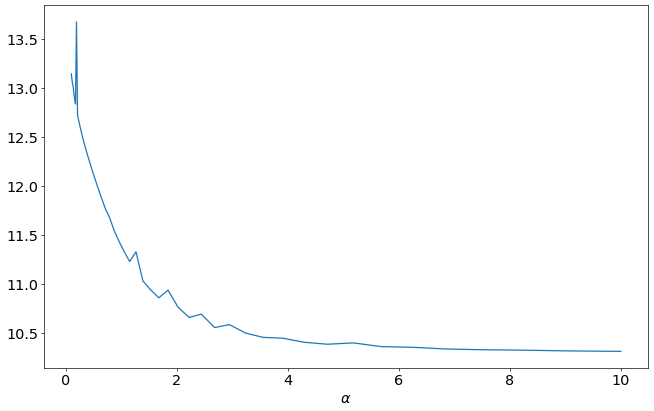

In [34]:
f0 = [x['f'] for x in profiles[0]]
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)

plt.plot(np.logspace(-1, 1, num=50).flatten(), f0)
plt.xlabel(r"$\alpha$",size='xx-large')
plt.tick_params(labelsize='xx-large')

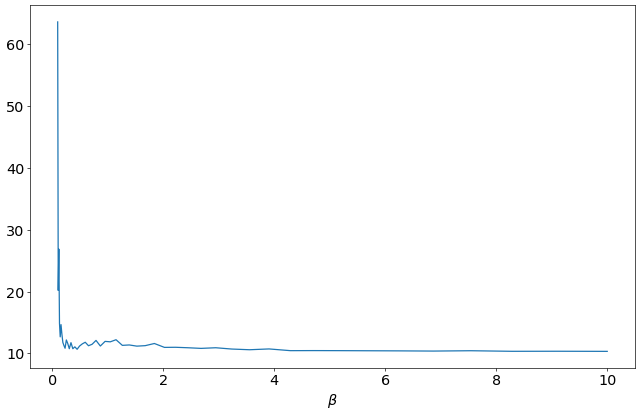

In [35]:
f1 = [x['f'] for x in profiles[1]]
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)

plt.plot(np.logspace(-1, 1, num=50).flatten(), f1)
plt.xlabel(r"$\beta$",size='xx-large')
plt.tick_params(labelsize='xx-large')

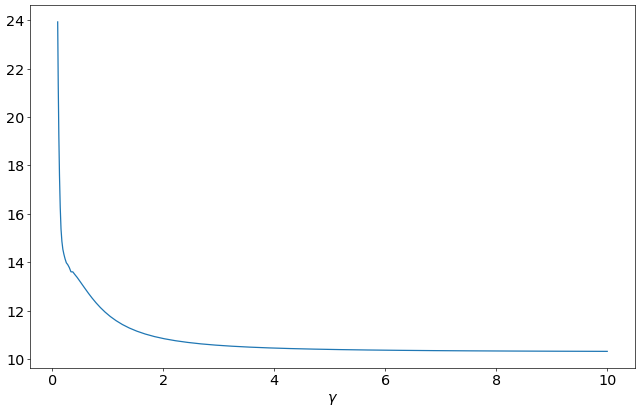

In [36]:
f2 = [x['f'] for x in profiles[2]]
fig, ax=plt.subplots(figsize=[13, 8], dpi=60)

plt.plot(np.logspace(-1, 1, num=50).flatten(), f2)
plt.xlabel(r"$\gamma$",size='xx-large')
plt.tick_params(labelsize='xx-large')